In [1]:
%load_ext autoreload
%autoreload 2

import copy
import os
import sys
from pathlib import Path
import subprocess
from platformdirs import user_cache_dir
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem

import ms_pred.common as common
from ms_pred.dag_pred.iceberg_elucidation import candidates_from_pubchem, iceberg_prediction, load_real_spec, load_pred_spec, elucidation_over_candidates, plot_top_mols, explain_peaks, modi_finder, generate_buyable_report, form_from_mgf_sirius, form_from_mgf_buddy, load_global_config

/home/roger/miniforge3/envs/ms-main/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/roger/ms-pred

/mnt/c/Users/runzh/OneDrive/Documents/2023/ms-pred


# Global configs
Please modify the the configs in `configs/iceberg/iceberg_elucidation.yaml` accordingly; for `python_path` on molgpu, you can either
1) set up your own ms-gen environment from source
2) use Mrunali's pre-built environment, after telling conda to look in her folder with `conda config --add envs_dirs /home/mrunali/miniconda3/envs`
3) Clone Mrunali's pre-built environment into your own environment with `conda --clone` and then source that instead.

In [3]:
config = load_global_config()
common.plot_utils.set_style()

## Build MS-distinguishable amine set

In [ ]:
import itertools
import matplotlib
from sklearn.manifold import MDS
from ms_pred.retrieval.retrieval_benchmark import entropy_dist_bin
from ml4co_kit import KaMISSolver
import networkx as nx
import json

energy = [20, 35]
pesticide_config = copy.deepcopy(config)
pesticide_config['nce'] = True # use nce for collision energy
pesticide_config['step_collision_energy'] = True # step collision energy i.e. multiple spectrum are obtained then merged

num_bins = 15000

for xls_path in Path('/home/roger/ms_collaborators/Bo-reaction-discovery/20240922_amine screening/').glob('*.xlsx'):

    df = pd.read_excel(xls_path)

    isomer_info = [
        # (name, filename, smiles)
        (row['amine_material'], None, row['product'], idx) for idx, row in df.iterrows()
    ]

    all_smiles = [info[2] for info in isomer_info]
    all_smiles, indices = common.sanitize(all_smiles, 'smi', return_indices=True)
    all_smiles = [common.rm_stereo(smi) for smi in all_smiles]
    all_names = [isomer_info[i][0] for i in indices]
    all_indices = [isomer_info[i][3] for i in indices]
    isomer_info = [(name, None, smi, idx) for name, smi, idx in zip(all_names, all_smiles, all_indices)]
    precursor_mz = common.mass_from_smi(isomer_info[0][2])

    def get_spec(smi):
        result_path, pmz = iceberg_prediction(all_smiles, energy, **pesticide_config)
        pred_smiles, pred_specs, __ = load_pred_spec(result_path, step_collision_energy=True)
        smi_idx = pred_smiles.tolist().index(smi)
        spec_binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in pred_specs[smi_idx].items()}
        return spec_binned

    num_isomers = len(isomer_info)
    dissim_mat = np.zeros((num_isomers, num_isomers))
    for (id1, (name1, fname1, smi1, _)), (id2, (name2, fname2, smi2, __)) in itertools.combinations(zip(range(num_isomers), isomer_info), 2):
        spec1_binned = [get_spec(smi1)]
        spec2_binned = get_spec(smi2)
        dist = entropy_dist_bin(spec1_binned, spec2_binned, ignore_peak=(precursor_mz - 1) * 10, sparse=False)
        dissim_mat[id1, id2] = dist[0]
        dissim_mat[id2, id1] = dist[0]

    # solve a MIS
    adj_mat = dissim_mat < 0.5
    g = nx.from_numpy_matrix(adj_mat)
    nx.write_gpickle(g, f'tmp-mis/{xls_path.stem}.gpickle')

    mis_solver = KaMISSolver()
    mis_solver.solve('tmp-mis')

    results_dic = json.load(open('tmp-mis/solve/results.json'))
    assert results_dic[f'{xls_path.stem}']["found_mis"]
    mis_graph_indices = results_dic[f'{xls_path.stem}']["mis"]
    selected_indices = [all_indices[i] for i in mis_graph_indices] # convert to index in "isomer_info"

    embedding = MDS(n_components=2, normalized_stress='auto', dissimilarity='precomputed')
    plot_pos = embedding.fit_transform(dissim_mat)
    for info, (x, y) in zip(isomer_info, plot_pos):
        if info[3] in selected_indices:
            plt.scatter(x, y, marker='^', c='c')
            plt.gca().annotate(info[0], (x + 0.01, y + 0.01))
        else:
            plt.scatter(x, y, marker='o', c='r')
            plt.gca().annotate(info[0], (x + 0.01, y + 0.01))

    colors = plt.cm.inferno(dissim_mat)
    for (id1, (x1, y1)), (id2, (x2, y2)) in itertools.combinations(zip(range(num_isomers), plot_pos), 2):
        plt.plot((x1, x2), (y1, y2), '--', c=colors[id1, id2], linewidth=0.5)
        # plt.text((x1 + x2) / 2, (y1 + y2) / 2, f"{dissim_mat[id1, id2]:.3f}", fontsize=5)
    plt.axis('off')
    plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=dissim_mat.min(), vmax=dissim_mat.max()), cmap='inferno'))

    row_to_choice = {}
    for info in isomer_info:
        idx = info[3]
        if idx in selected_indices:
            row_to_choice[idx] = 'selected'
        else:
            row_to_choice[idx] = 'not selected'

    df['choice'] = row_to_choice

    df.to_excel(xls_path.parent / 'mis' / (xls_path.stem + f'_{len(selected_indices)}mis.xlsx'))
    plt.savefig(xls_path.parent / 'mis' / (xls_path.stem + f'_{len(selected_indices)}mis.pdf'))
    plt.close()

## Elucidation

In [4]:
def elucidation(feature_id, spec, adduct, cand_smiles, vis_peaks=False, energy=[30, 40, 60]):
    _config = copy.deepcopy(config)
    _config['nce'] = True # use nce for collision energy
    _config['step_collision_energy'] = True  # step collision energy i.e. multiple spectrum are obtained then merged
    _config['real_spec_type'] = 'raw'
    _config['adduct'] = adduct

    # Run ICEBERG to predict spectra
    result_path, pmz = iceberg_prediction(cand_smiles, energy, **_config)

    # Compare spectrum similarity for elucidation
    topk_results = elucidation_over_candidates(result_path, spec, precursor_mass=pmz, mol_name=feature_id, topk=5, ignore_precursor=False, **_config)

    # Plot top results
    img = plot_top_mols(topk_results)

    # Visualize and explain peaks
    if vis_peaks:
        for smi, _, __ in topk_results:
            explain_peaks(result_path, spec, pmz, smi, num_peaks=10, **_config)

    return img

In [5]:
inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250405_pool/all_nitro_and_iodo_20250411_sirius.mgf'
# inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250221_cn_pool/cn_pool_latest_20250221.mgf'
# inp_mgf = '/home/roger/ms_collaborators/Bo-reaction-discovery/20250320_pool/isobaric_multirxn_20250313.mgf'
# feature_id_to_form = form_from_mgf_sirius(inp_mgf, top_k_sirius_preds=5, profile='orbitrap', **config)
feature_id_to_form = form_from_mgf_buddy(inp_mgf, top_k_buddy_preds=5, profile='orbitrap', halogen=True)
all_specs = common.parse_spectra_mgf(inp_mgf)
feature_id_to_rt = {
    entry[0]['FEATURE_ID']: entry[0]['RTINSECONDS']
    for entry in all_specs if entry[0]['MSLEVEL'] == '2'
}

msbuddy: molecular formula annotation for MS-based small molecule analysis.


7019 queries loaded.
8 batches in total.
Batch 1/8:
Subformula assignment: 100%|██████████| 1000/1000 [00:08<00:00, 122.52it/s]
Candidate formula ranking...
FDR calculation: 100%|██████████| 1000/1000 [00:00<00:00, 115819.96it/s]
Batch 2/8:
Subformula assignment: 100%|██████████| 1000/1000 [00:10<00:00, 91.99it/s]
Candidate formula ranking...
FDR calculation: 100%|██████████| 1000/1000 [00:00<00:00, 49138.37it/s]
Batch 3/8:
Subformula assignment: 100%|██████████| 1000/1000 [00:47<00:00, 20.97it/s]
Candidate formula ranking...
FDR calculation: 100%|██████████| 1000/1000 [00:00<00:00, 30554.25it/s]
Batch 4/8:
Subformula assignment: 100%|██████████| 1000/1000 [01:32<00:00, 10.80it/s]
Candidate formula ranking...
FDR calculation: 100%|██████████| 1000/1000 [00:00<00:00, 27688.83it/s]
Batch 5/8:
Subformula assignment: 100%|██████████| 1000/1000 [01:52<00:00,  8.90it/s]
Candidate formula ranking...
FDR calculation: 100%|██████████| 1000/1000 [00:00<00:00, 23758.78it/s]
Batch 6/8:
Subformula 

28076it [00:00, 36833.51it/s]


## Coupled compound

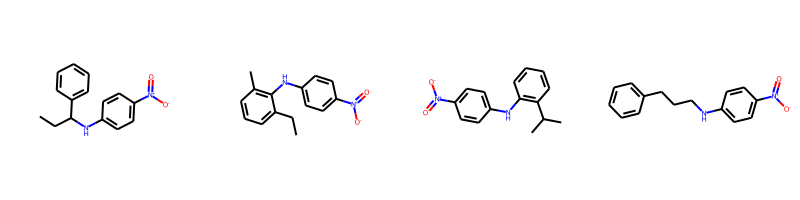

In [6]:
coupled_cmpds = ['CCC(NC6=CC=C(N(=O)=O)C=C6)C7=CC=CC=C7', 'CCC8=CC=CC(C)=C8NC9=CC=C(N(=O)=O)C=C9', 'CC(C)C%10=C(NC%11=CC=C(N(=O)=O)C=C%11)C=CC=C%10', 'C%12(CCCNC%13=CC=C(N(=O)=O)C=C%13)=CC=CC=C%12'] \

# coupled_cmpds = ['CCC(NC6=CC=CC=C6)C7=CC=CC=C7', 'CCC8=CC=CC(C)=C8NC9=CC=CC=C9', 'CC(C)C%10=C(NC%11=CC=CC=C%11)C=CC=C%10', 'C%12(CCCNC%13=CC=CC=C%13)=CC=CC=C%12'] \
                #+ ['CC(C)c1cc(-c2ccccc2)ccc1N', 'CCC(N)c1cccc(-c2ccccc2)c1', 'NCCCc1cccc(-c2ccccc2)c1', 'CCC(N)c1ccc(-c2ccccc2)cc1', 'NCCCc1ccc(-c2ccccc2)cc1', 'Cc1cccc(C(C)c2ccccc2)c1N', 'CCc1ccc(-c2ccccc2)c(C)c1N', 'Cc1cccc(CCc2ccccc2)c1N', 'CC(c1ccccc1)C(N)c1ccccc1', 'NCC(Cc1ccccc1)c1ccccc1', 'NC(CCc1ccccc1)c1ccccc1', 'CC(C)(c1ccccc1)c1ccccc1N', 'CC(C)c1ccc(-c2ccccc2)cc1N', 'CCC(N)c1ccccc1-c1ccccc1', 'CCC(N)(c1ccccc1)c1ccccc1', 'CC(Cc1ccccc1)c1ccccc1N', 'NCCCc1ccccc1-c1ccccc1', 'CC(C)c1c(N)cccc1-c1ccccc1', 'CCc1c(-c2ccccc2)ccc(C)c1N', 'NCCC(c1ccccc1)c1ccccc1', 'CC(C)c1cccc(-c2ccccc2)c1N', 'CCc1cccc(Cc2ccccc2)c1N', 'CCc1cc(-c2ccccc2)cc(C)c1N'] # potential side products

# coupled_cmpds = ['CCCCCNCCCC1=CC=CC=C1', 'CCCCCNC(CC)C2=CC=CC=C2', 'CC(C=CC=C3CC)=C3NCCCCC', 'CC(C)C4=CC=CC=C4NCCCCC'] # pooled_sn2

# coupled_cmpds = [r'CCC(C1=CC=CC=C1)/N=C2CCCCC/2', r'CCC(C3=CC=CC=C3)NC4CCCCC4', r'CC(C=CC=C5CC)=C5/N=C6CCCCC\6', r'CC(C)C7=CC=CC=C7/N=C8CCCCC\8', r'CC(C=CC=C9CC)=C9NC%10CCCCC%10', 'CC(C)C%11=CC=CC=C%11NC%12CCCCC%12', 'C%13(CCCNC%14CCCCC%14)=CC=CC=C%13', 'C%15(CCC/N=C%16CCCCC\%16)=CC=CC=C%15'] # pooled_redam

# coupled_cmpds = ['O=C(NC(CC)C1=CC=CC=C1)C2CCCCC2', 'CC(C=CC=C3CC)=C3NC(C4CCCCC4)=O', 'CC(C)C5=CC=CC=C5NC(C6CCCCC6)=O', 'O=C(C7CCCCC7)NCCCC8=CC=CC=C8'] # pooled_acyl_amide

# coupled_cmpds = ['O=C(NCCCC1=CC=CC=C1)C2=CC=CC=C2', 'CC3=CC=CC(CC)=C3NC(C4=CC=CC=C4)=O', 'CCC(NC(C5=CC=CC=C5)=O)C6=CC=CC=C6', 'O=C(NC7=CC=CC=C7C(C)C)C8=CC=CC=C8']
# coupled_cmpds = ['CC(C)c1ccccc1NC(O)=NC1CCCCC1', 'CCc1cccc(C)c1NC(O)=NC1CCCCC1', 'OC(=NC1CCCCC1)NCCCc1ccccc1', 'CCC(NC(O)=NC1CCCCC1)c1ccccc1', 'CC(C)c1ccccc1NC(=O)NC1CCCCC1', 'CCc1cccc(C)c1NC(=O)NC1CCCCC1', 'O=C(NCCCc1ccccc1)NC1CCCCC1', 'CCC(NC(=O)NC1CCCCC1)c1ccccc1']
Draw.MolsToGridImage([Chem.MolFromSmiles(m) for m in coupled_cmpds], molsPerRow=4)

In [7]:
[common.mass_from_smi(i) + common.ion2mass['[M+H]+'] for i in coupled_cmpds]

[257.128454204, 257.128454204, 257.128454204, 257.128454204]

In [23]:
for entry in all_specs:
    if entry[0]['MSLEVEL'] == '2' and np.any(np.abs(212.1433759 - float(entry[0]['PEPMASS'])) < 0.001):
        feat_id = entry[0]['FEATURE_ID']
        print(f'{feat_id}, {entry[0]["PEPMASS"]}: {feature_id_to_form[feat_id]}')

203, 212.1427: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]
4698, 212.1428: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]
6079, 212.1429: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]
6796, 212.1428: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]
7130, 212.1429: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]
7977, 212.1428: [{'rnk': 1, 'adduct': '[M+H]+', 'form': 'C15H17N'}, {'rnk': 2, 'adduct': '[M+H]+', 'form': 'C5H15F2N7'}]


In [24]:
interested_mass = [
    common.mass_from_smi(coupled_cmpds[0]) + common.ion2mass['[M+H]+'],
    # common.mass_from_smi(coupled_cmpds[0]) + common.ion2mass['[M+Na]+'],
]
interested_mass = np.array(interested_mass)

feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and np.any(np.abs(interested_mass - float(entry[0]['PEPMASS'])) < 0.001))
}
feat_id_to_specs.keys()

dict_keys(['203', '4698', '6079', '6796', '7130', '7977'])

FEAT_ID=203, RT=1.18 min


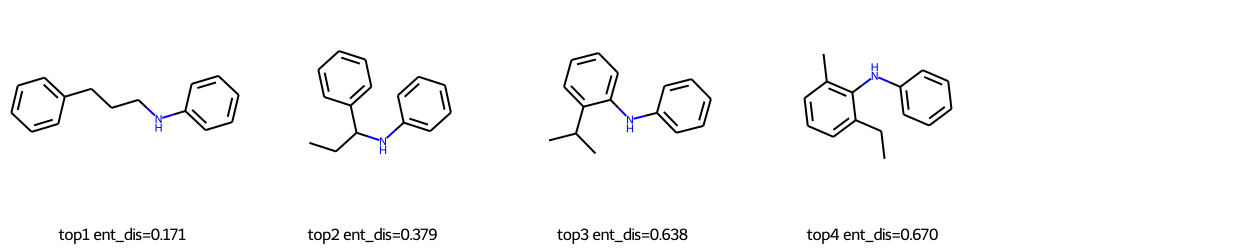

FEAT_ID=4698, RT=13.05 min


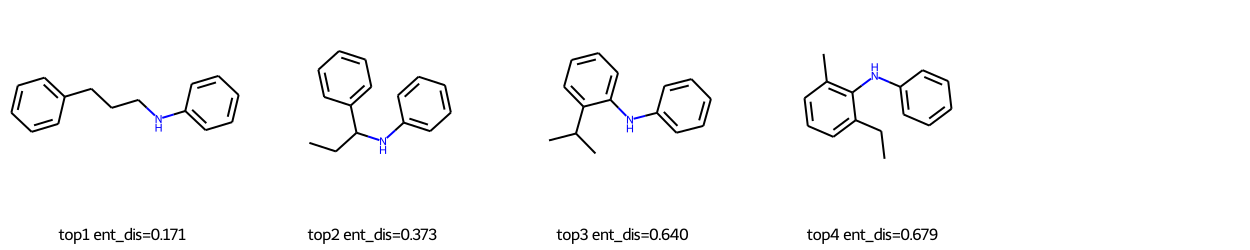

FEAT_ID=6079, RT=14.92 min


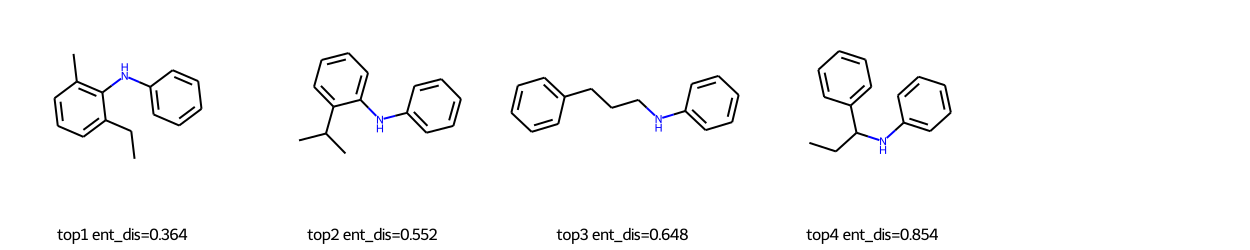

FEAT_ID=6796, RT=15.99 min


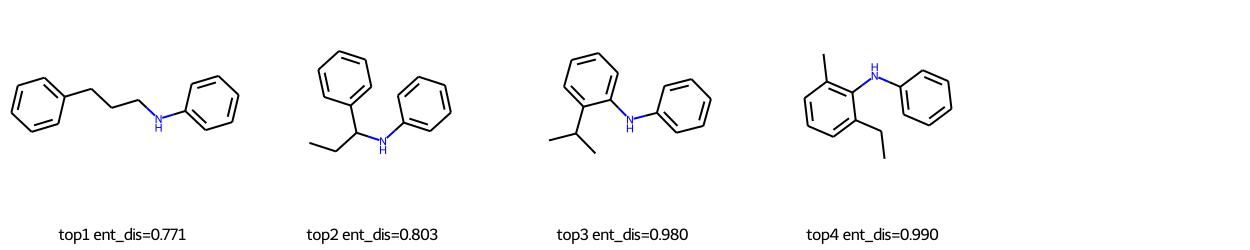

FEAT_ID=7130, RT=16.44 min


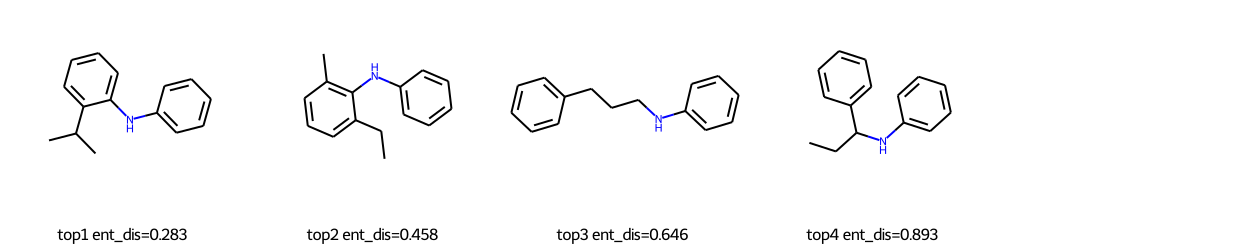

FEAT_ID=7977, RT=17.97 min


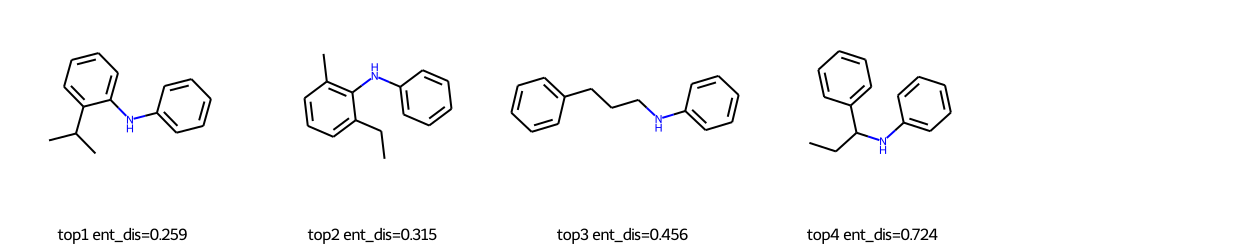

In [25]:
for feature_id in feat_id_to_specs.keys():
    spec = {'nan': feat_id_to_specs[feature_id]}
    img = elucidation(feature_id, spec, '[M+H]+', coupled_cmpds, vis_peaks=False, energy=[30, 45, 60])
    # img = elucidation(feature_id, spec, '[M+Na]+', coupled_cmpds, vis_peaks=True, energy=[30, 45, 60])
    print(f'FEAT_ID={feature_id}, RT={float(feature_id_to_rt[feature_id]) / 60:.2f} min')
    display(img)

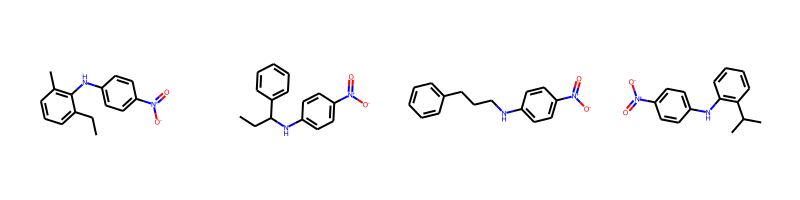

In [20]:
cmpds = ['CCC8=CC=CC(C)=C8NC9=CC=C(N(=O)=O)C=C9', 'CCC(NC6=CC=C(N(=O)=O)C=C6)C7=CC=CC=C7', 'C%12(CCCNC%13=CC=C(N(=O)=O)C=C%13)=CC=CC=C%12', 'CC(C)C%10=C(NC%11=CC=C(N(=O)=O)C=C%11)C=CC=C%10']
Draw.MolsToGridImage([Chem.MolFromSmiles(m) for m in cmpds], molsPerRow=4)

# Starting materials

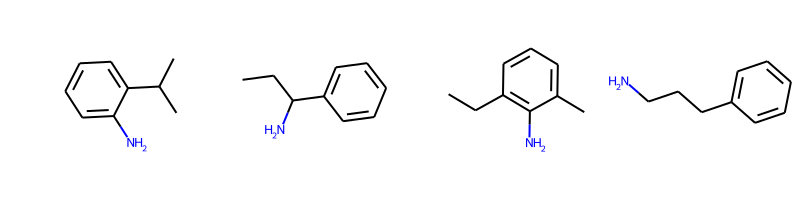

In [188]:
starting_cmpds = ['NC1=CC=CC=C1C(C)C','NC(C2=CC=CC=C2)CC','NC3=C(C=CC=C3C)CC','NCCCC4=CC=CC=C4']
Draw.MolsToGridImage([Chem.MolFromSmiles(m) for m in starting_cmpds], molsPerRow=4)

In [189]:
interested_mass = [
    common.mass_from_smi(starting_cmpds[0]) + common.ion2mass['[M+H]+'],
    # common.mass_from_smi(starting_cmpds[0]) + common.ion2mass['[M+Na]+'],
]
interested_mass = np.array(interested_mass)

feat_id_to_specs = {
    entry[0]['FEATURE_ID']: entry[1][0][1]
    for entry in all_specs if (entry[0]['MSLEVEL'] == '2' and np.any(np.abs(interested_mass - float(entry[0]['PEPMASS'])) < 0.001))
}
feat_id_to_specs.keys()

dict_keys(['66', '277', '395', '720'])

RT=63.78 sec


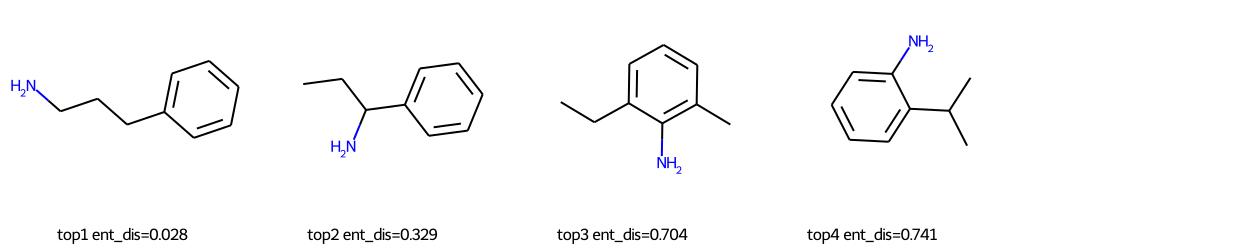

RT=197.90 sec


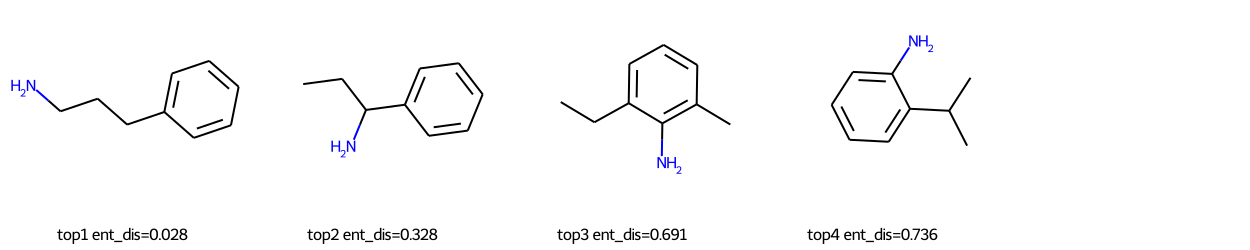

RT=260.08 sec


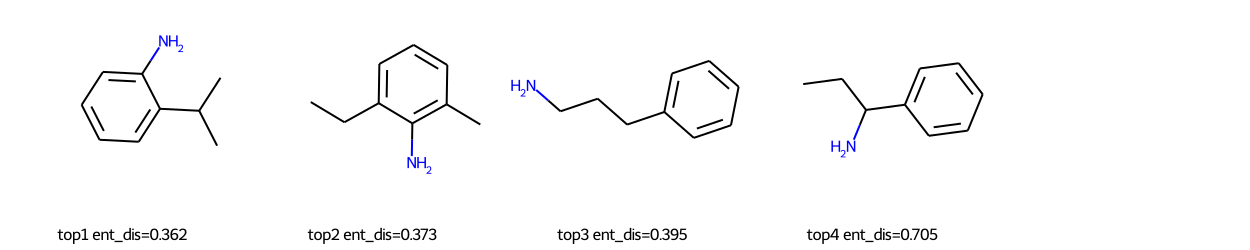

RT=345.50 sec


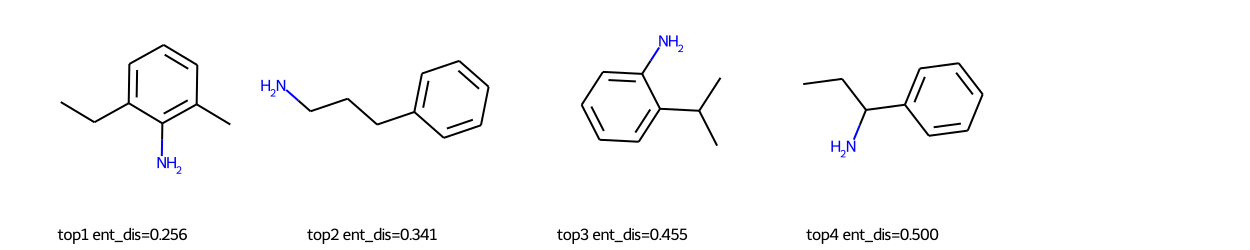

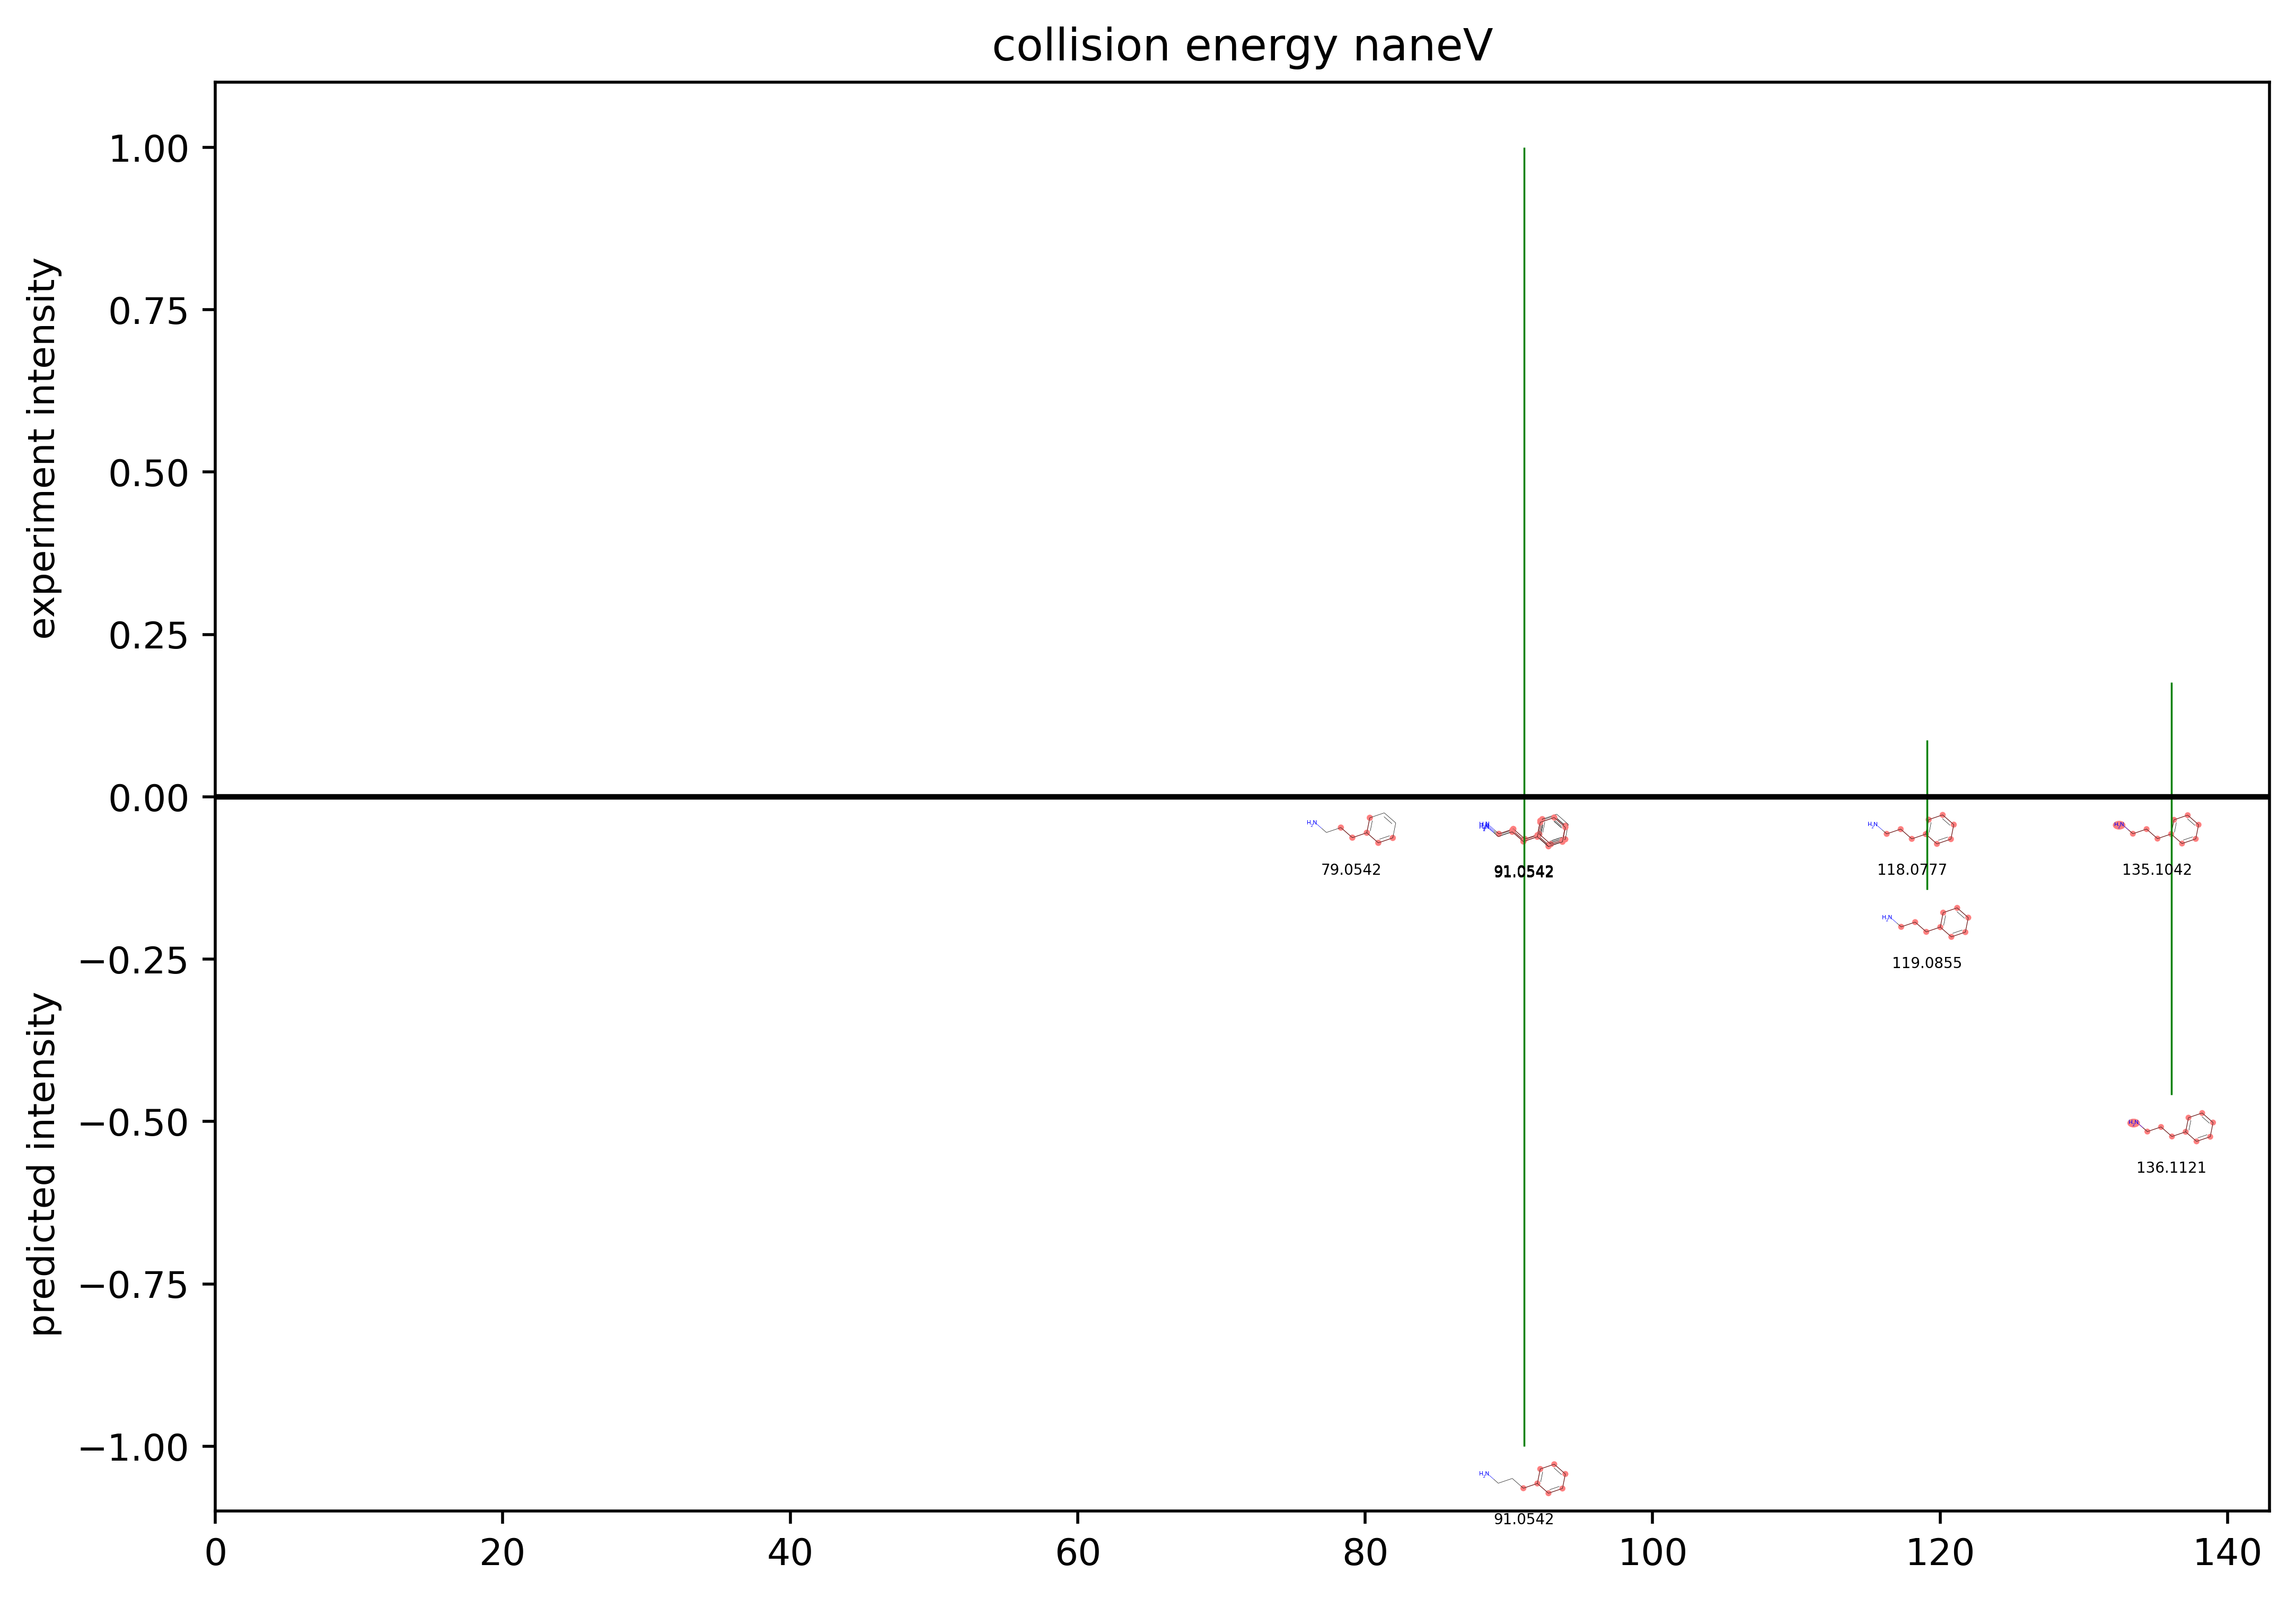

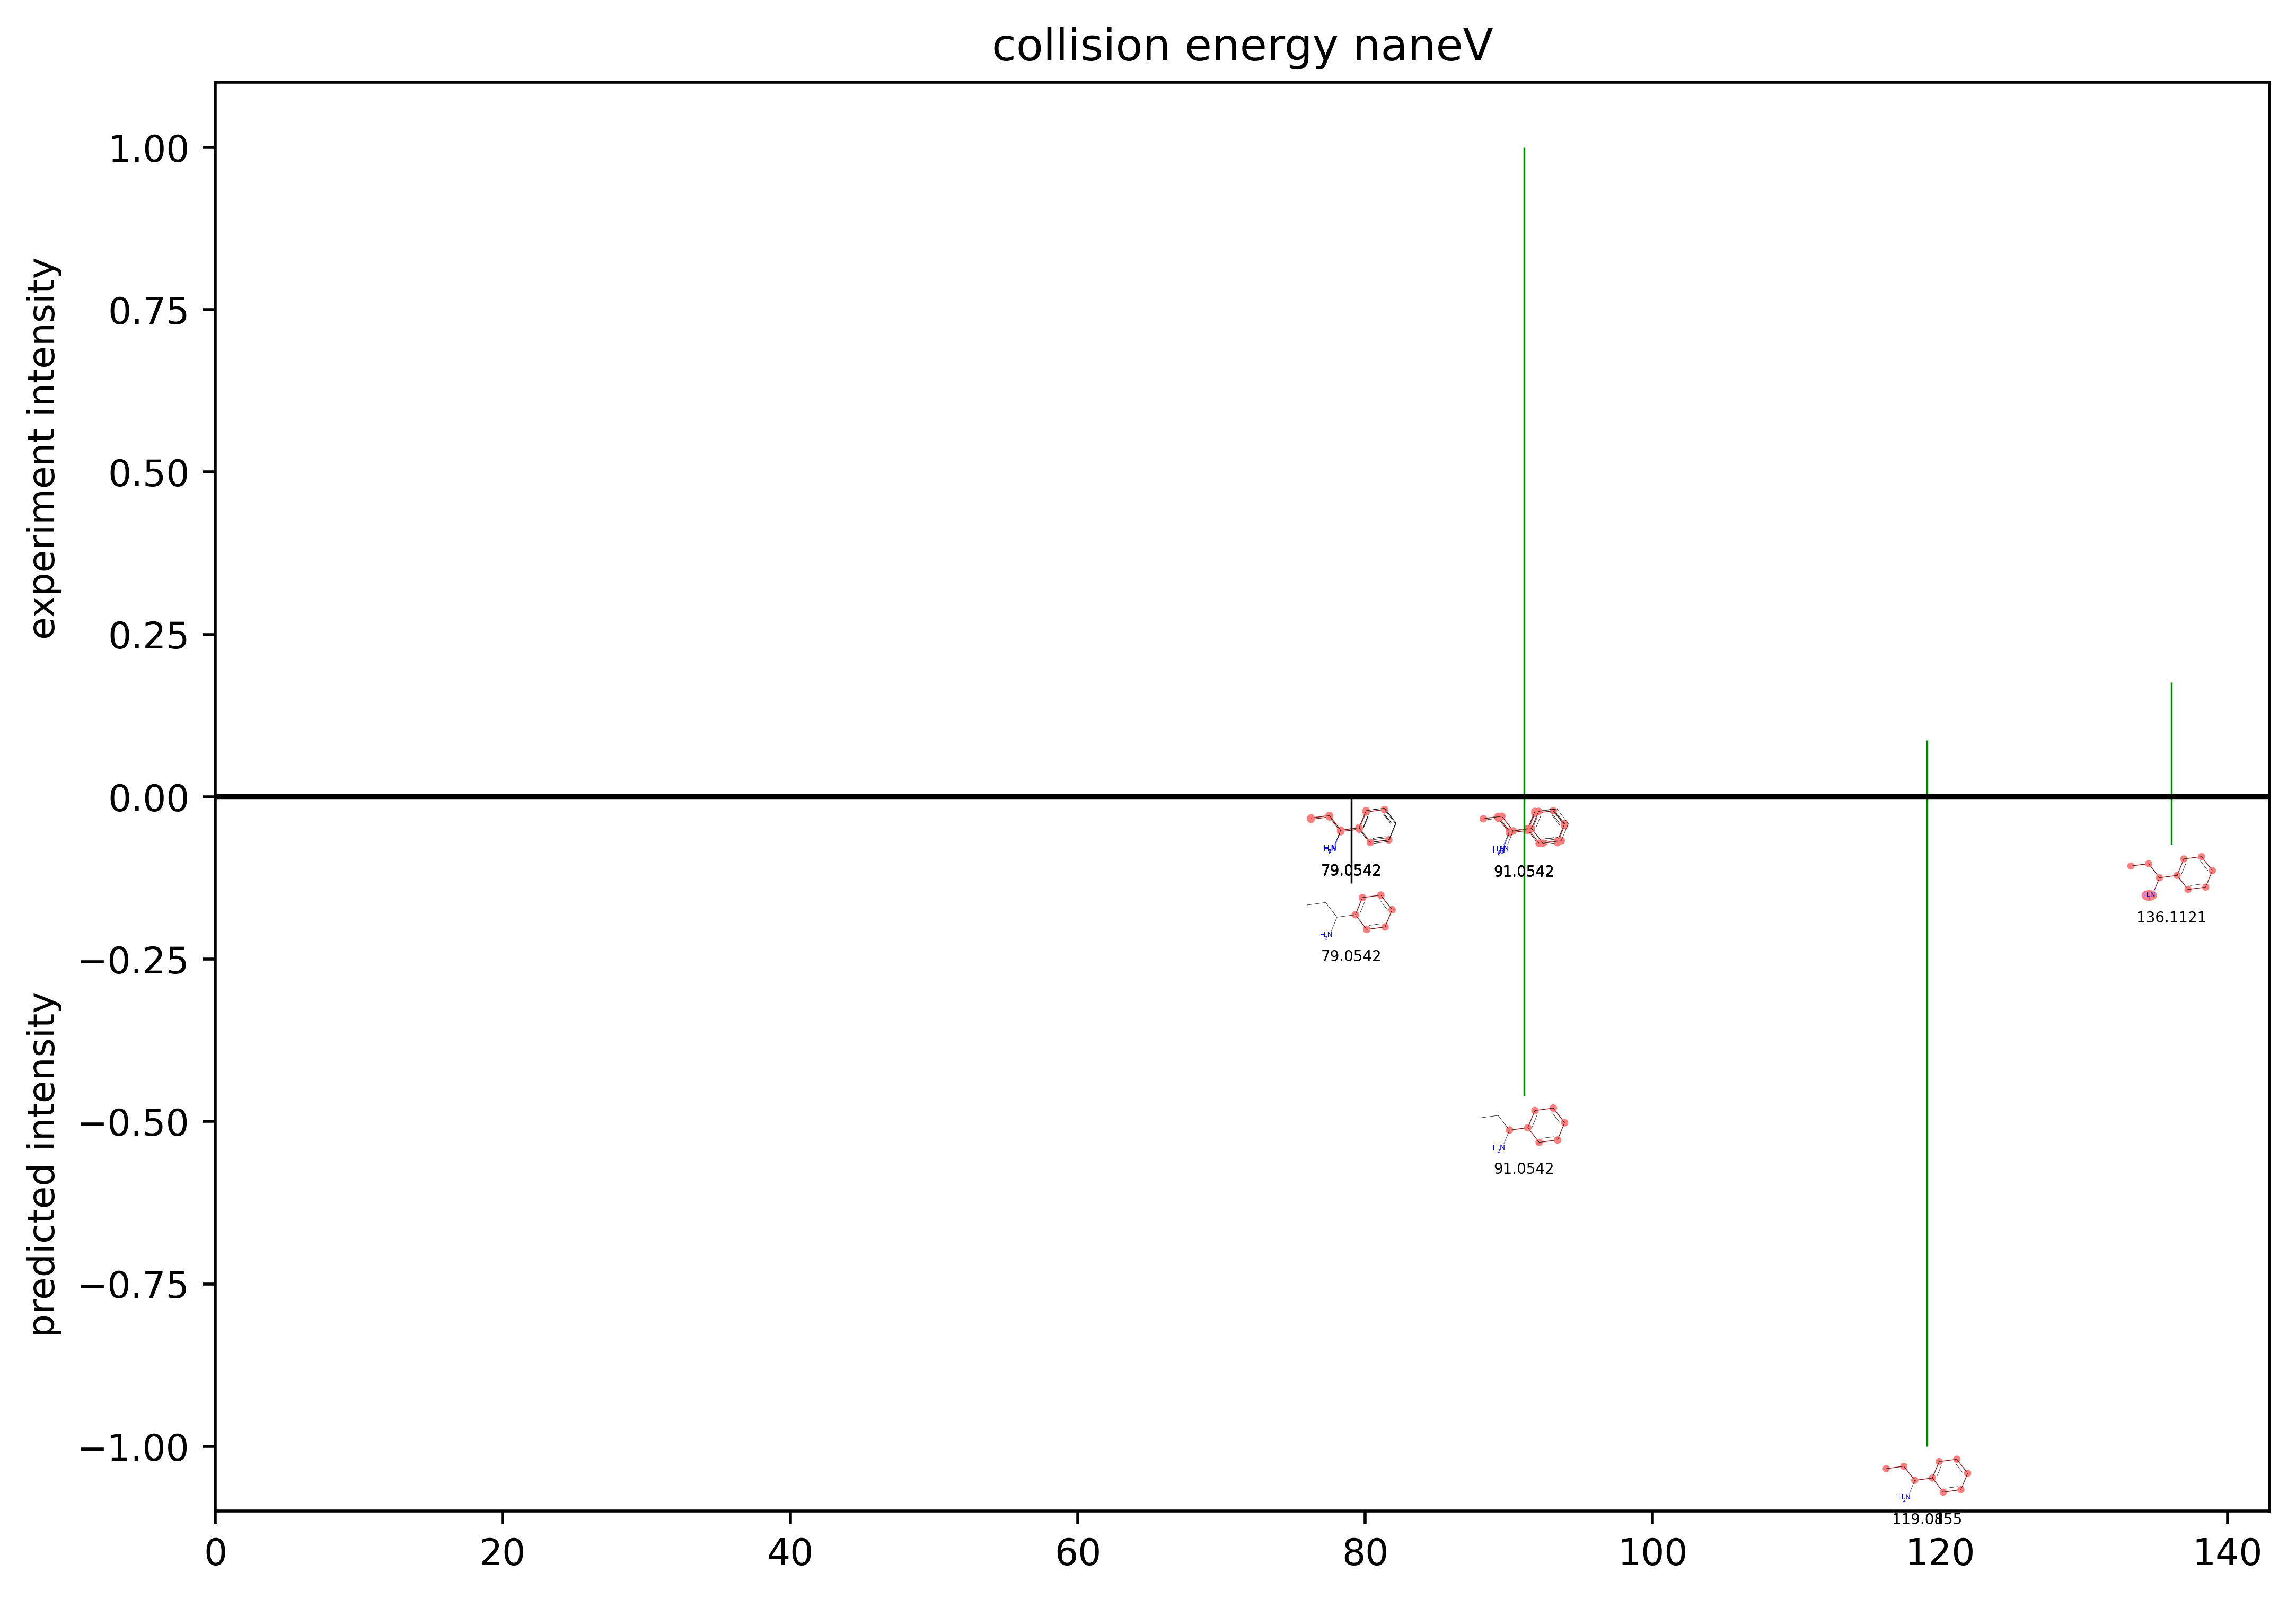

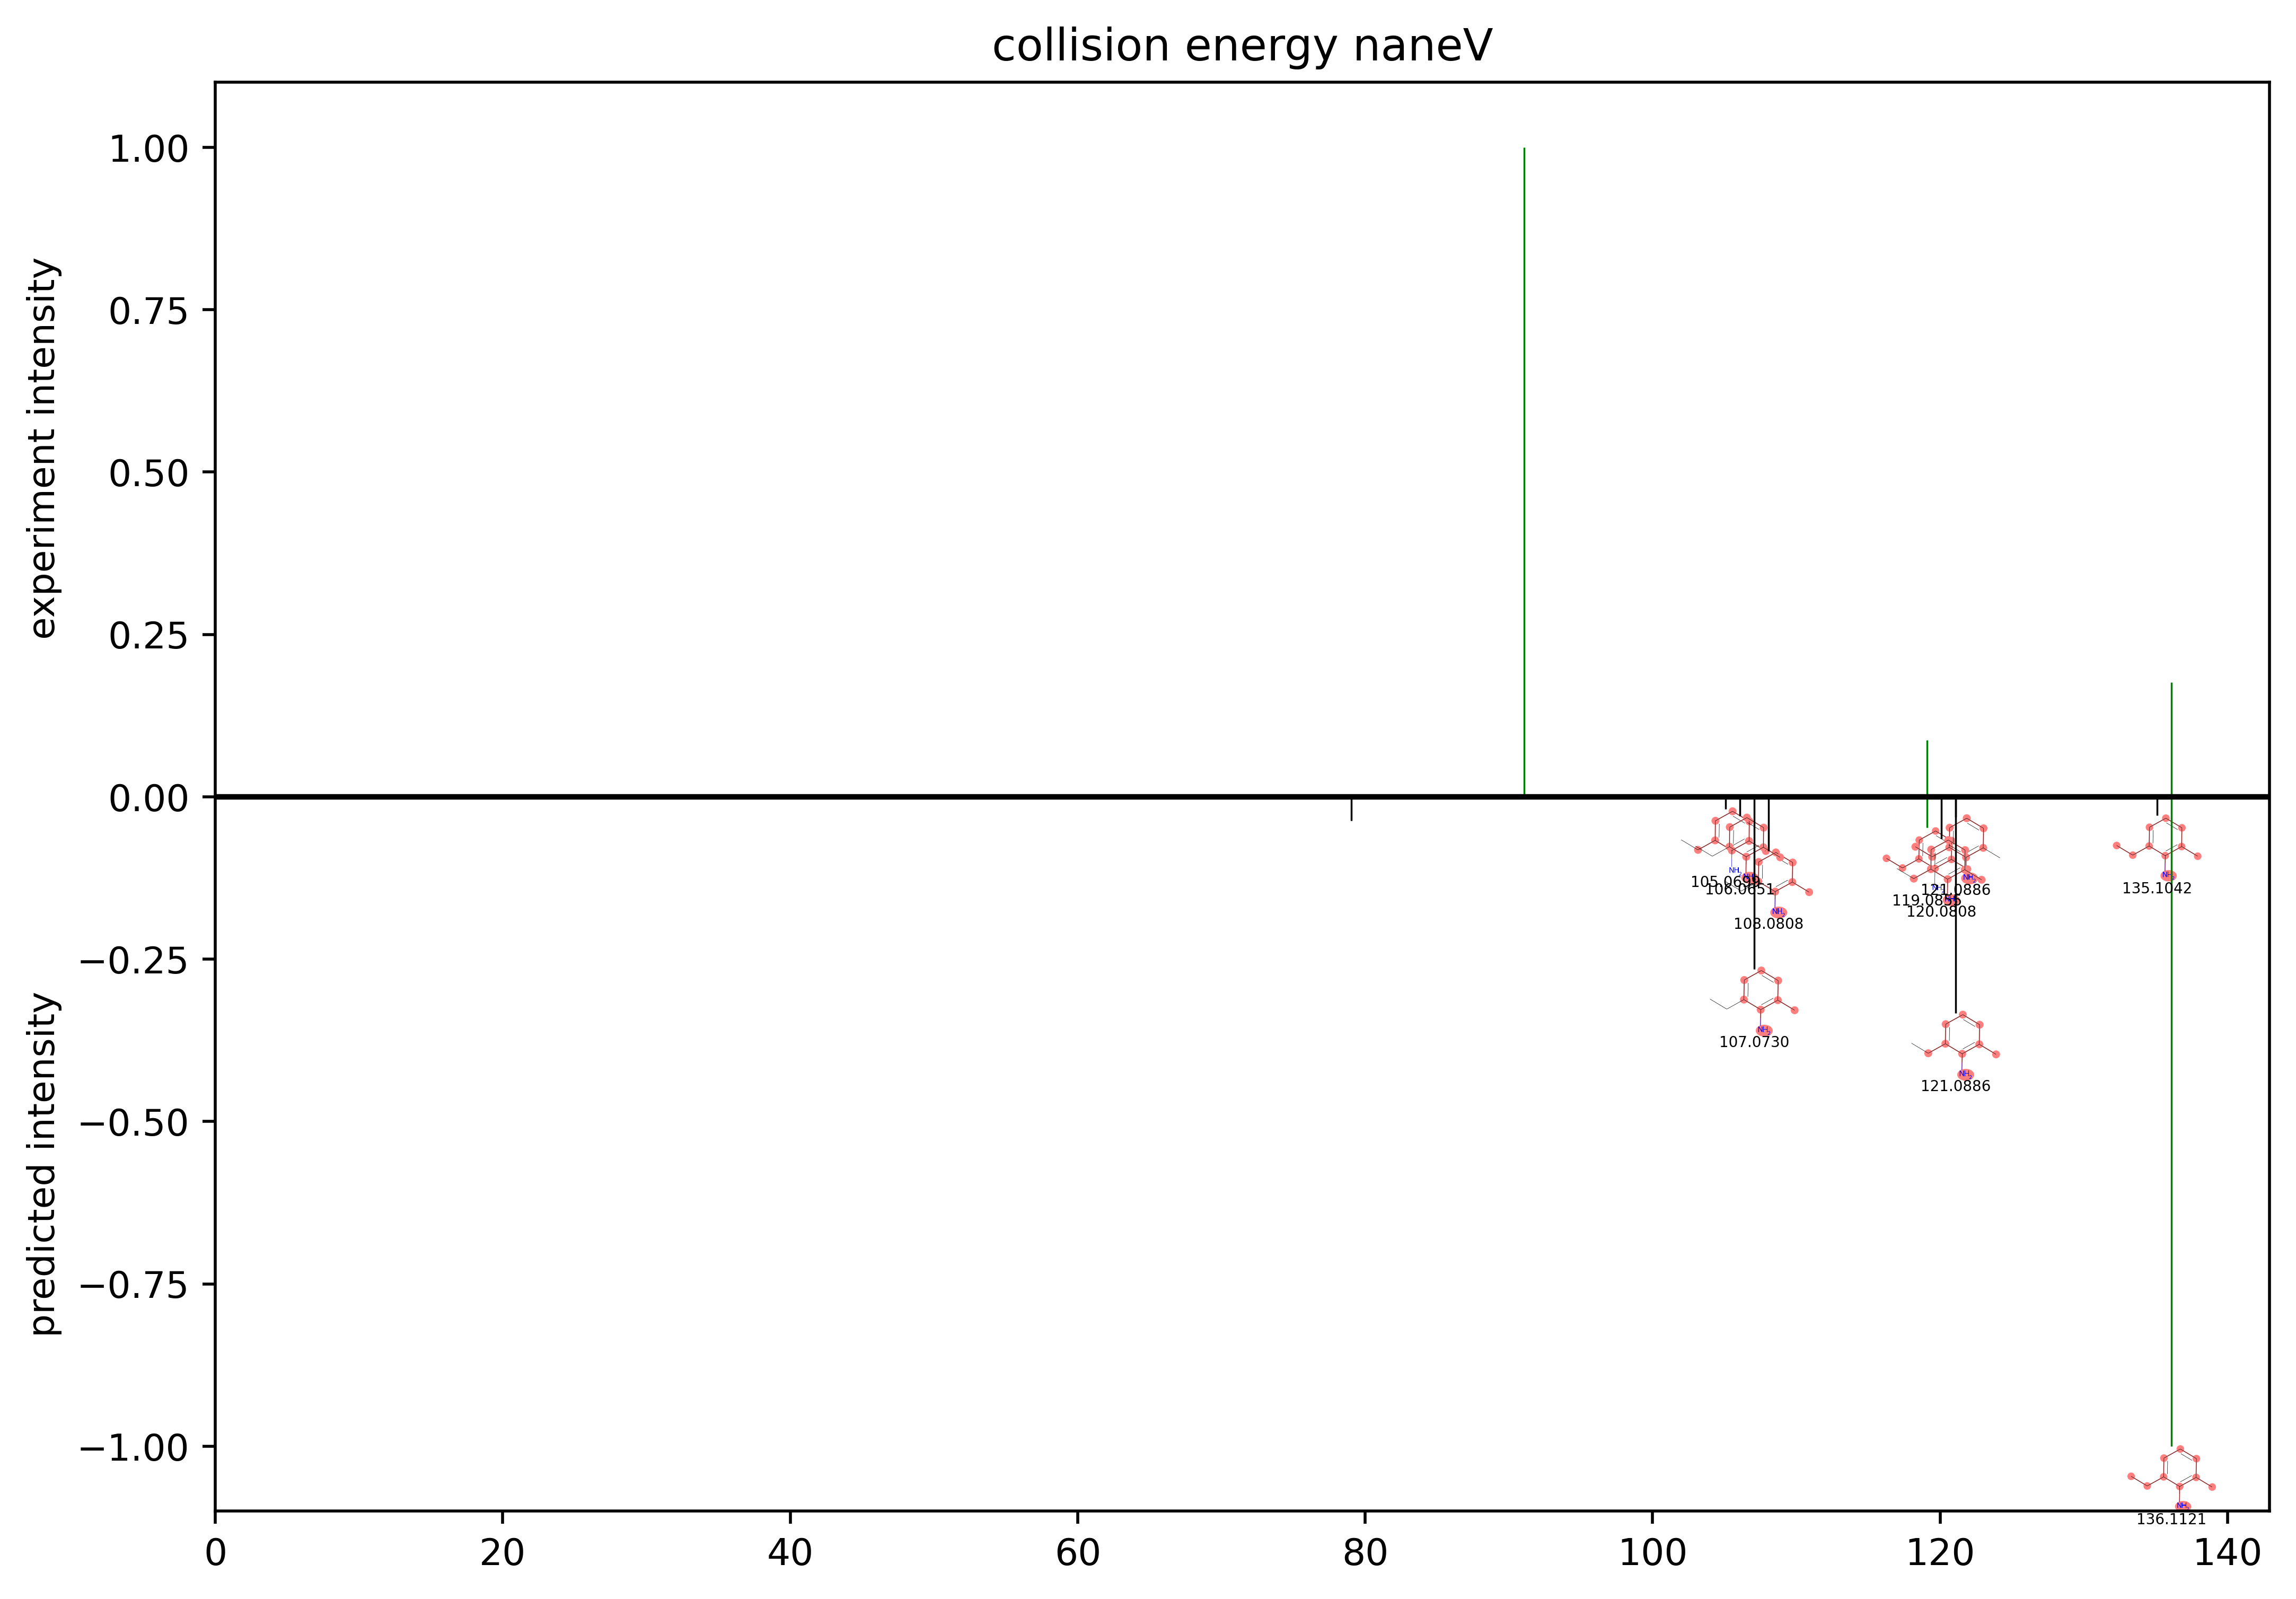

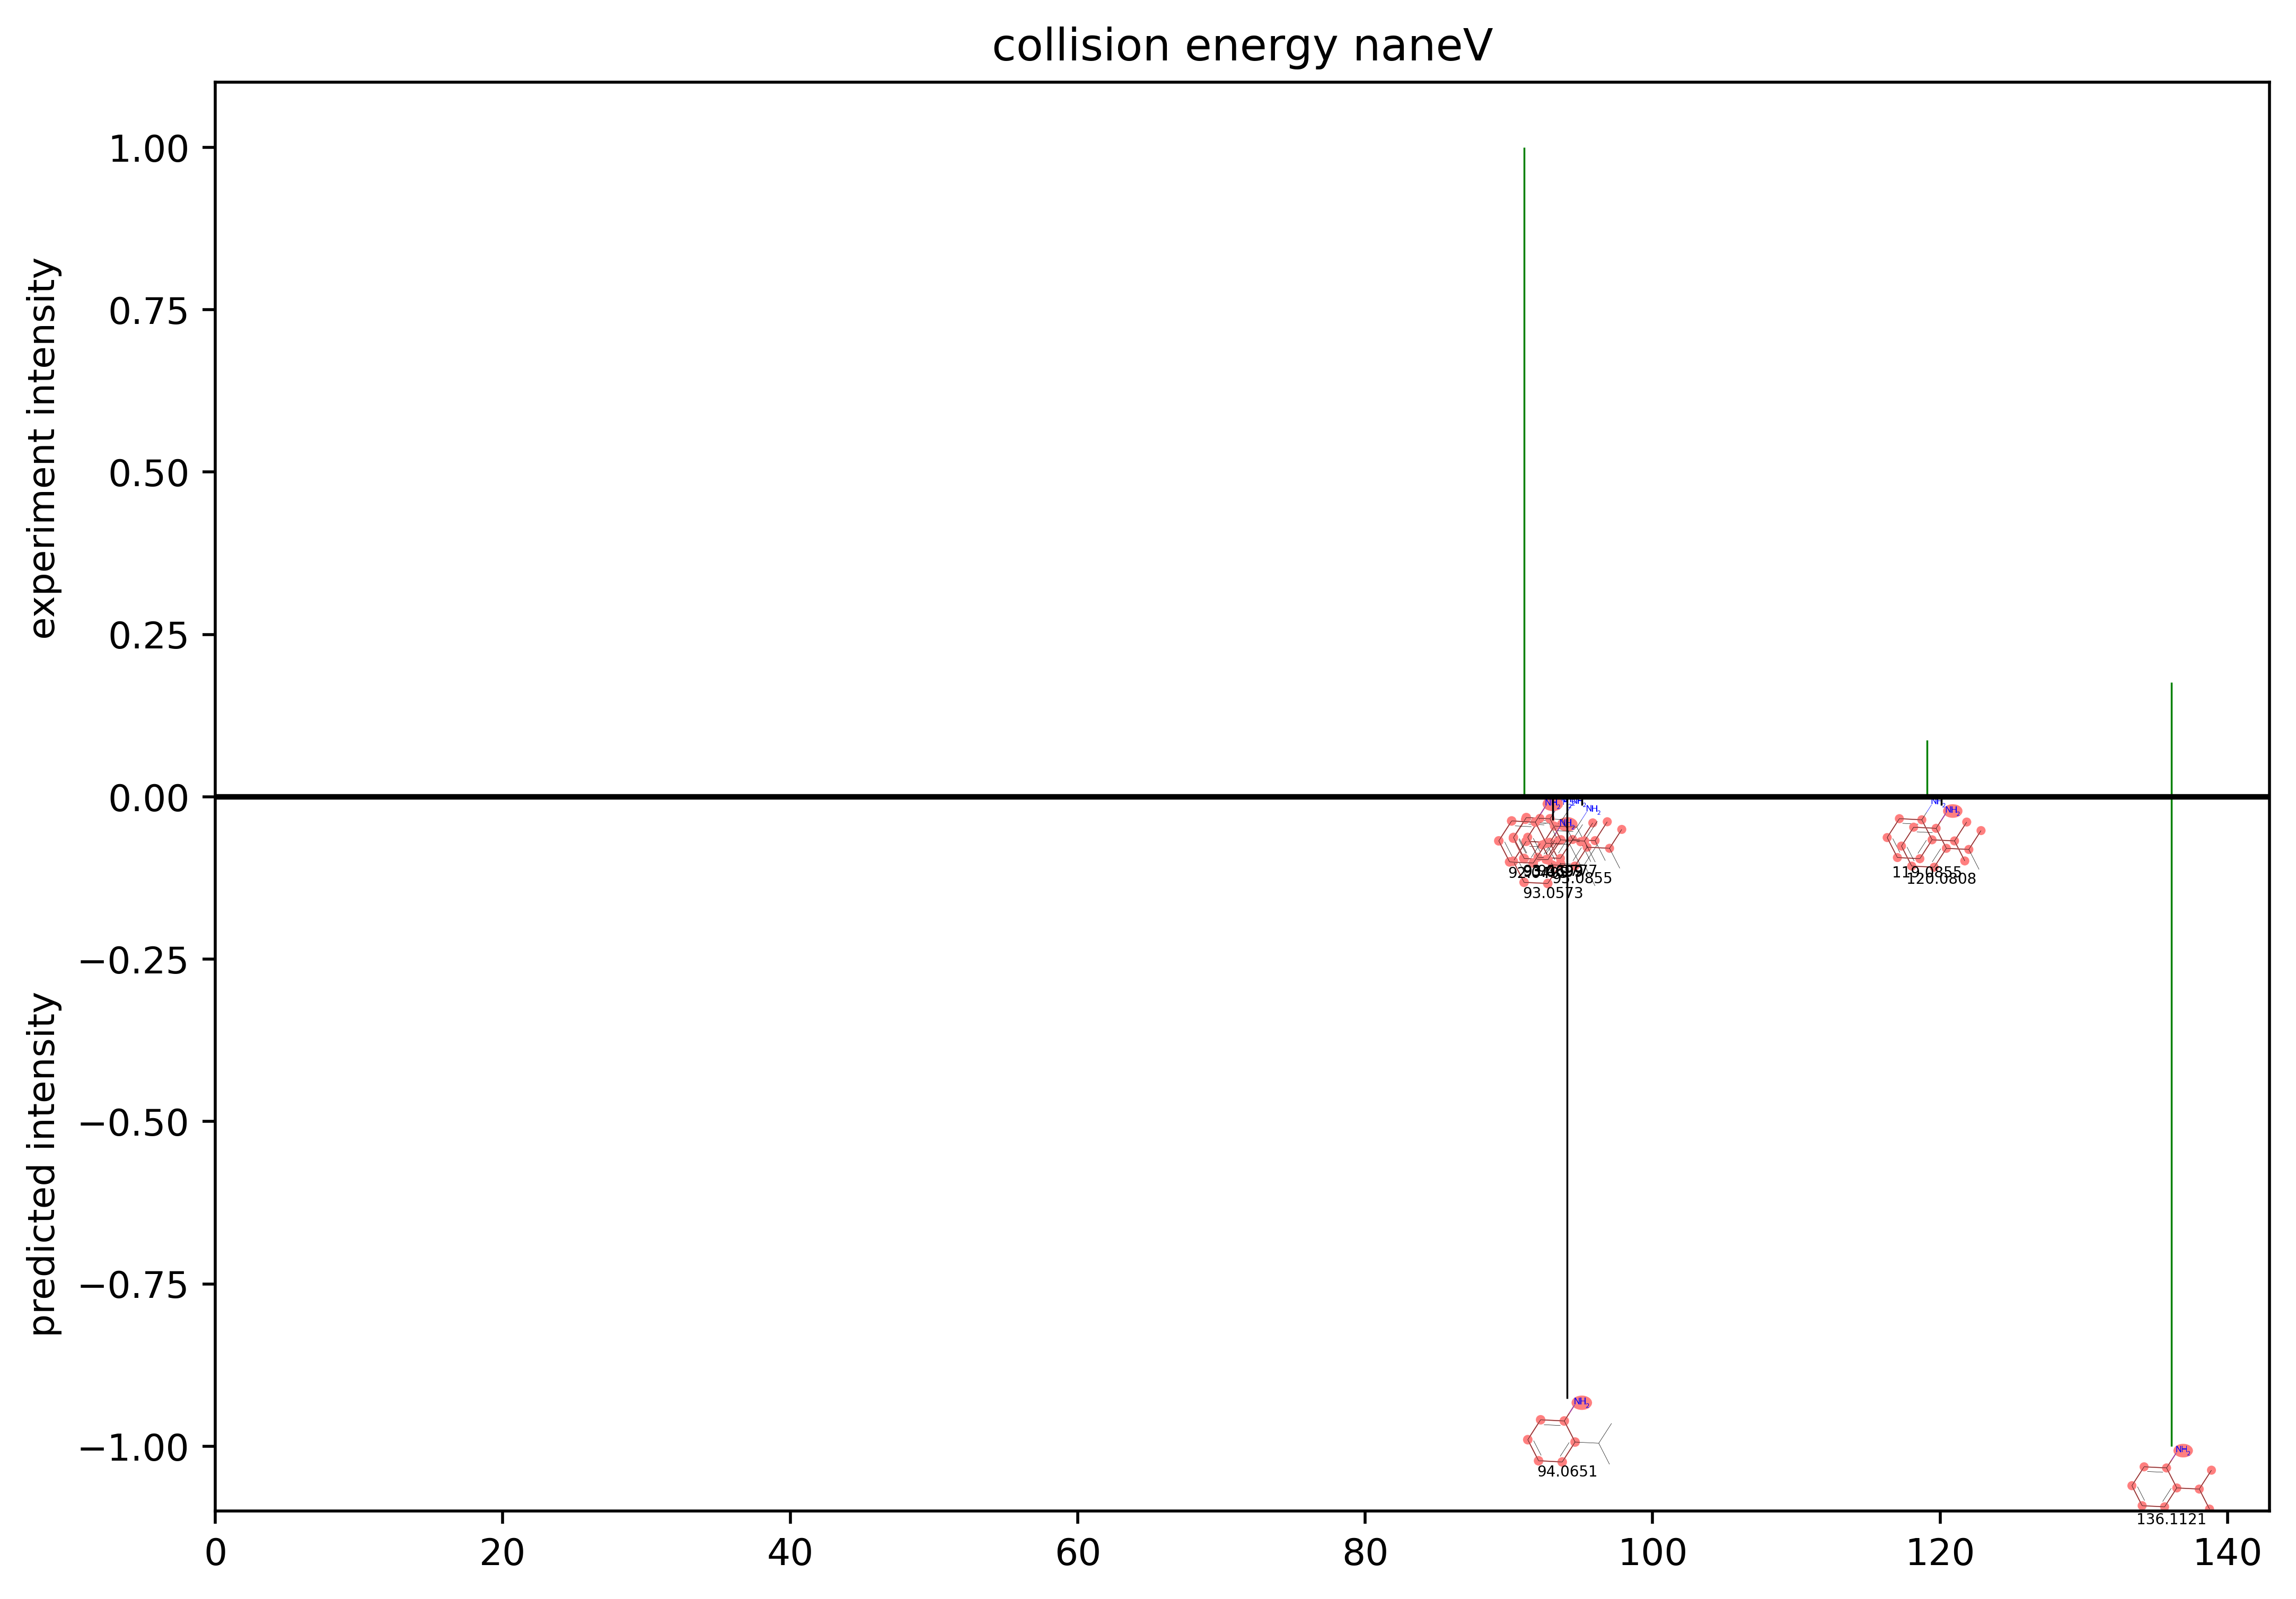

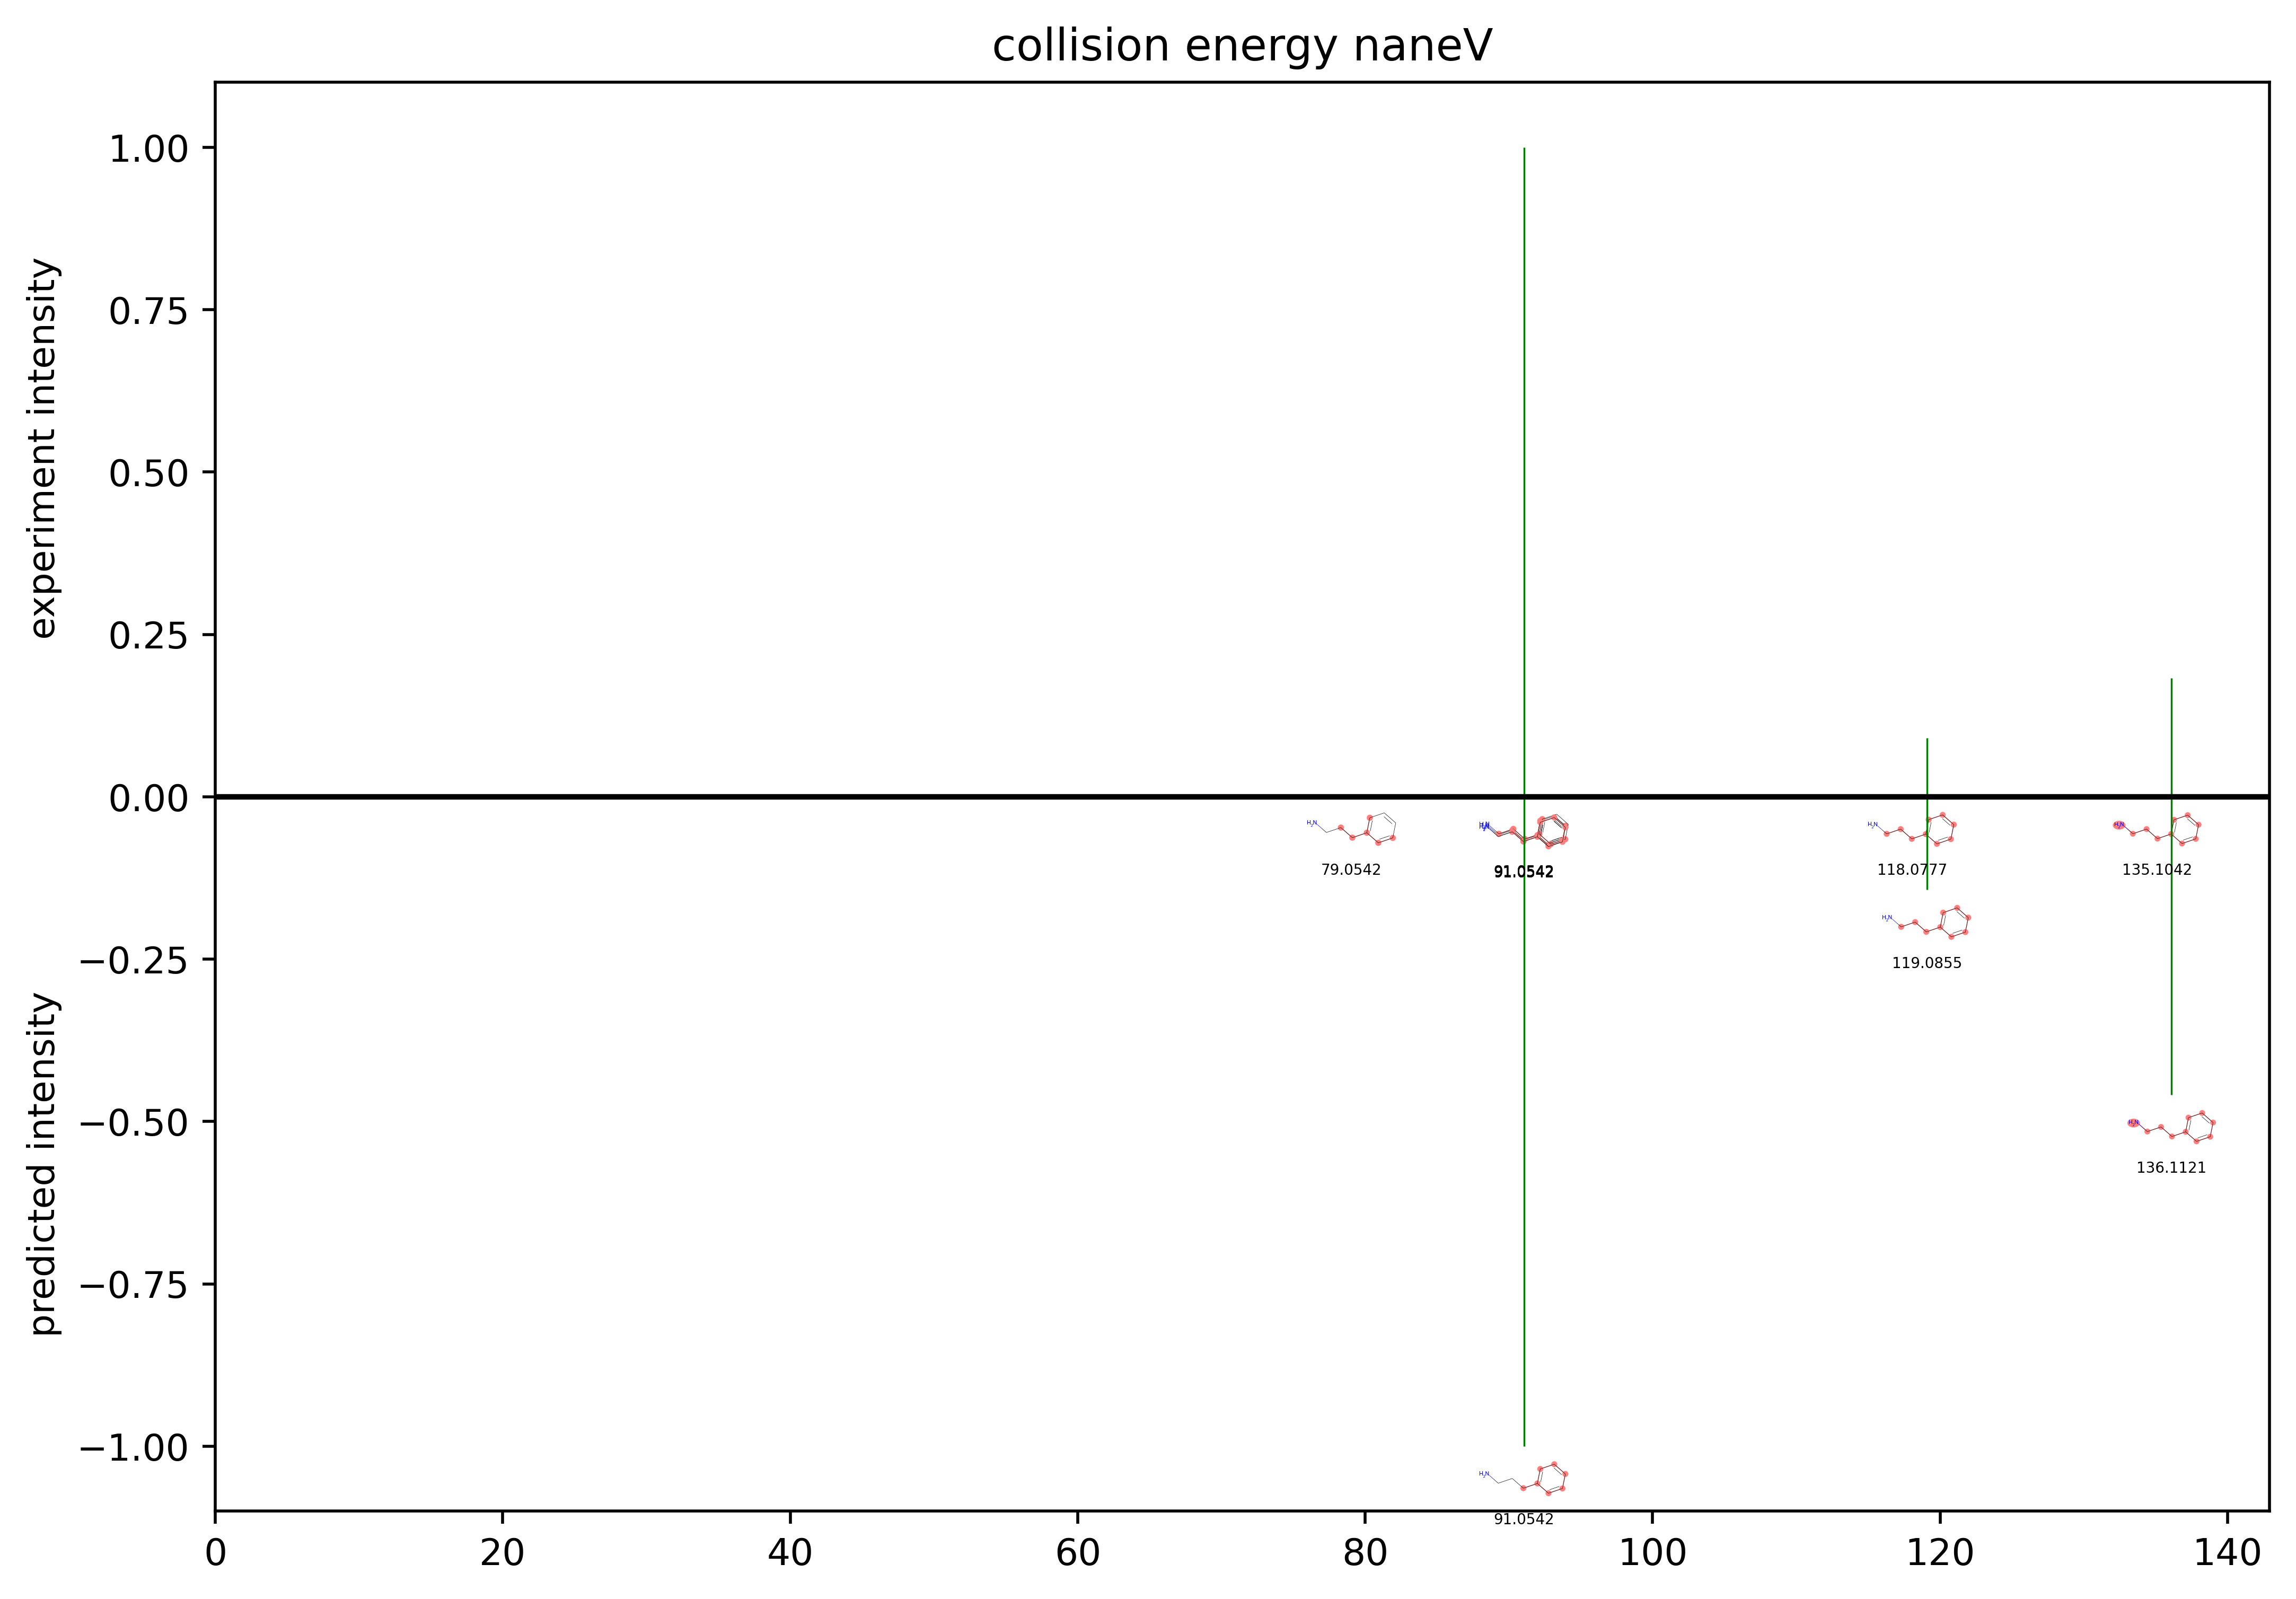

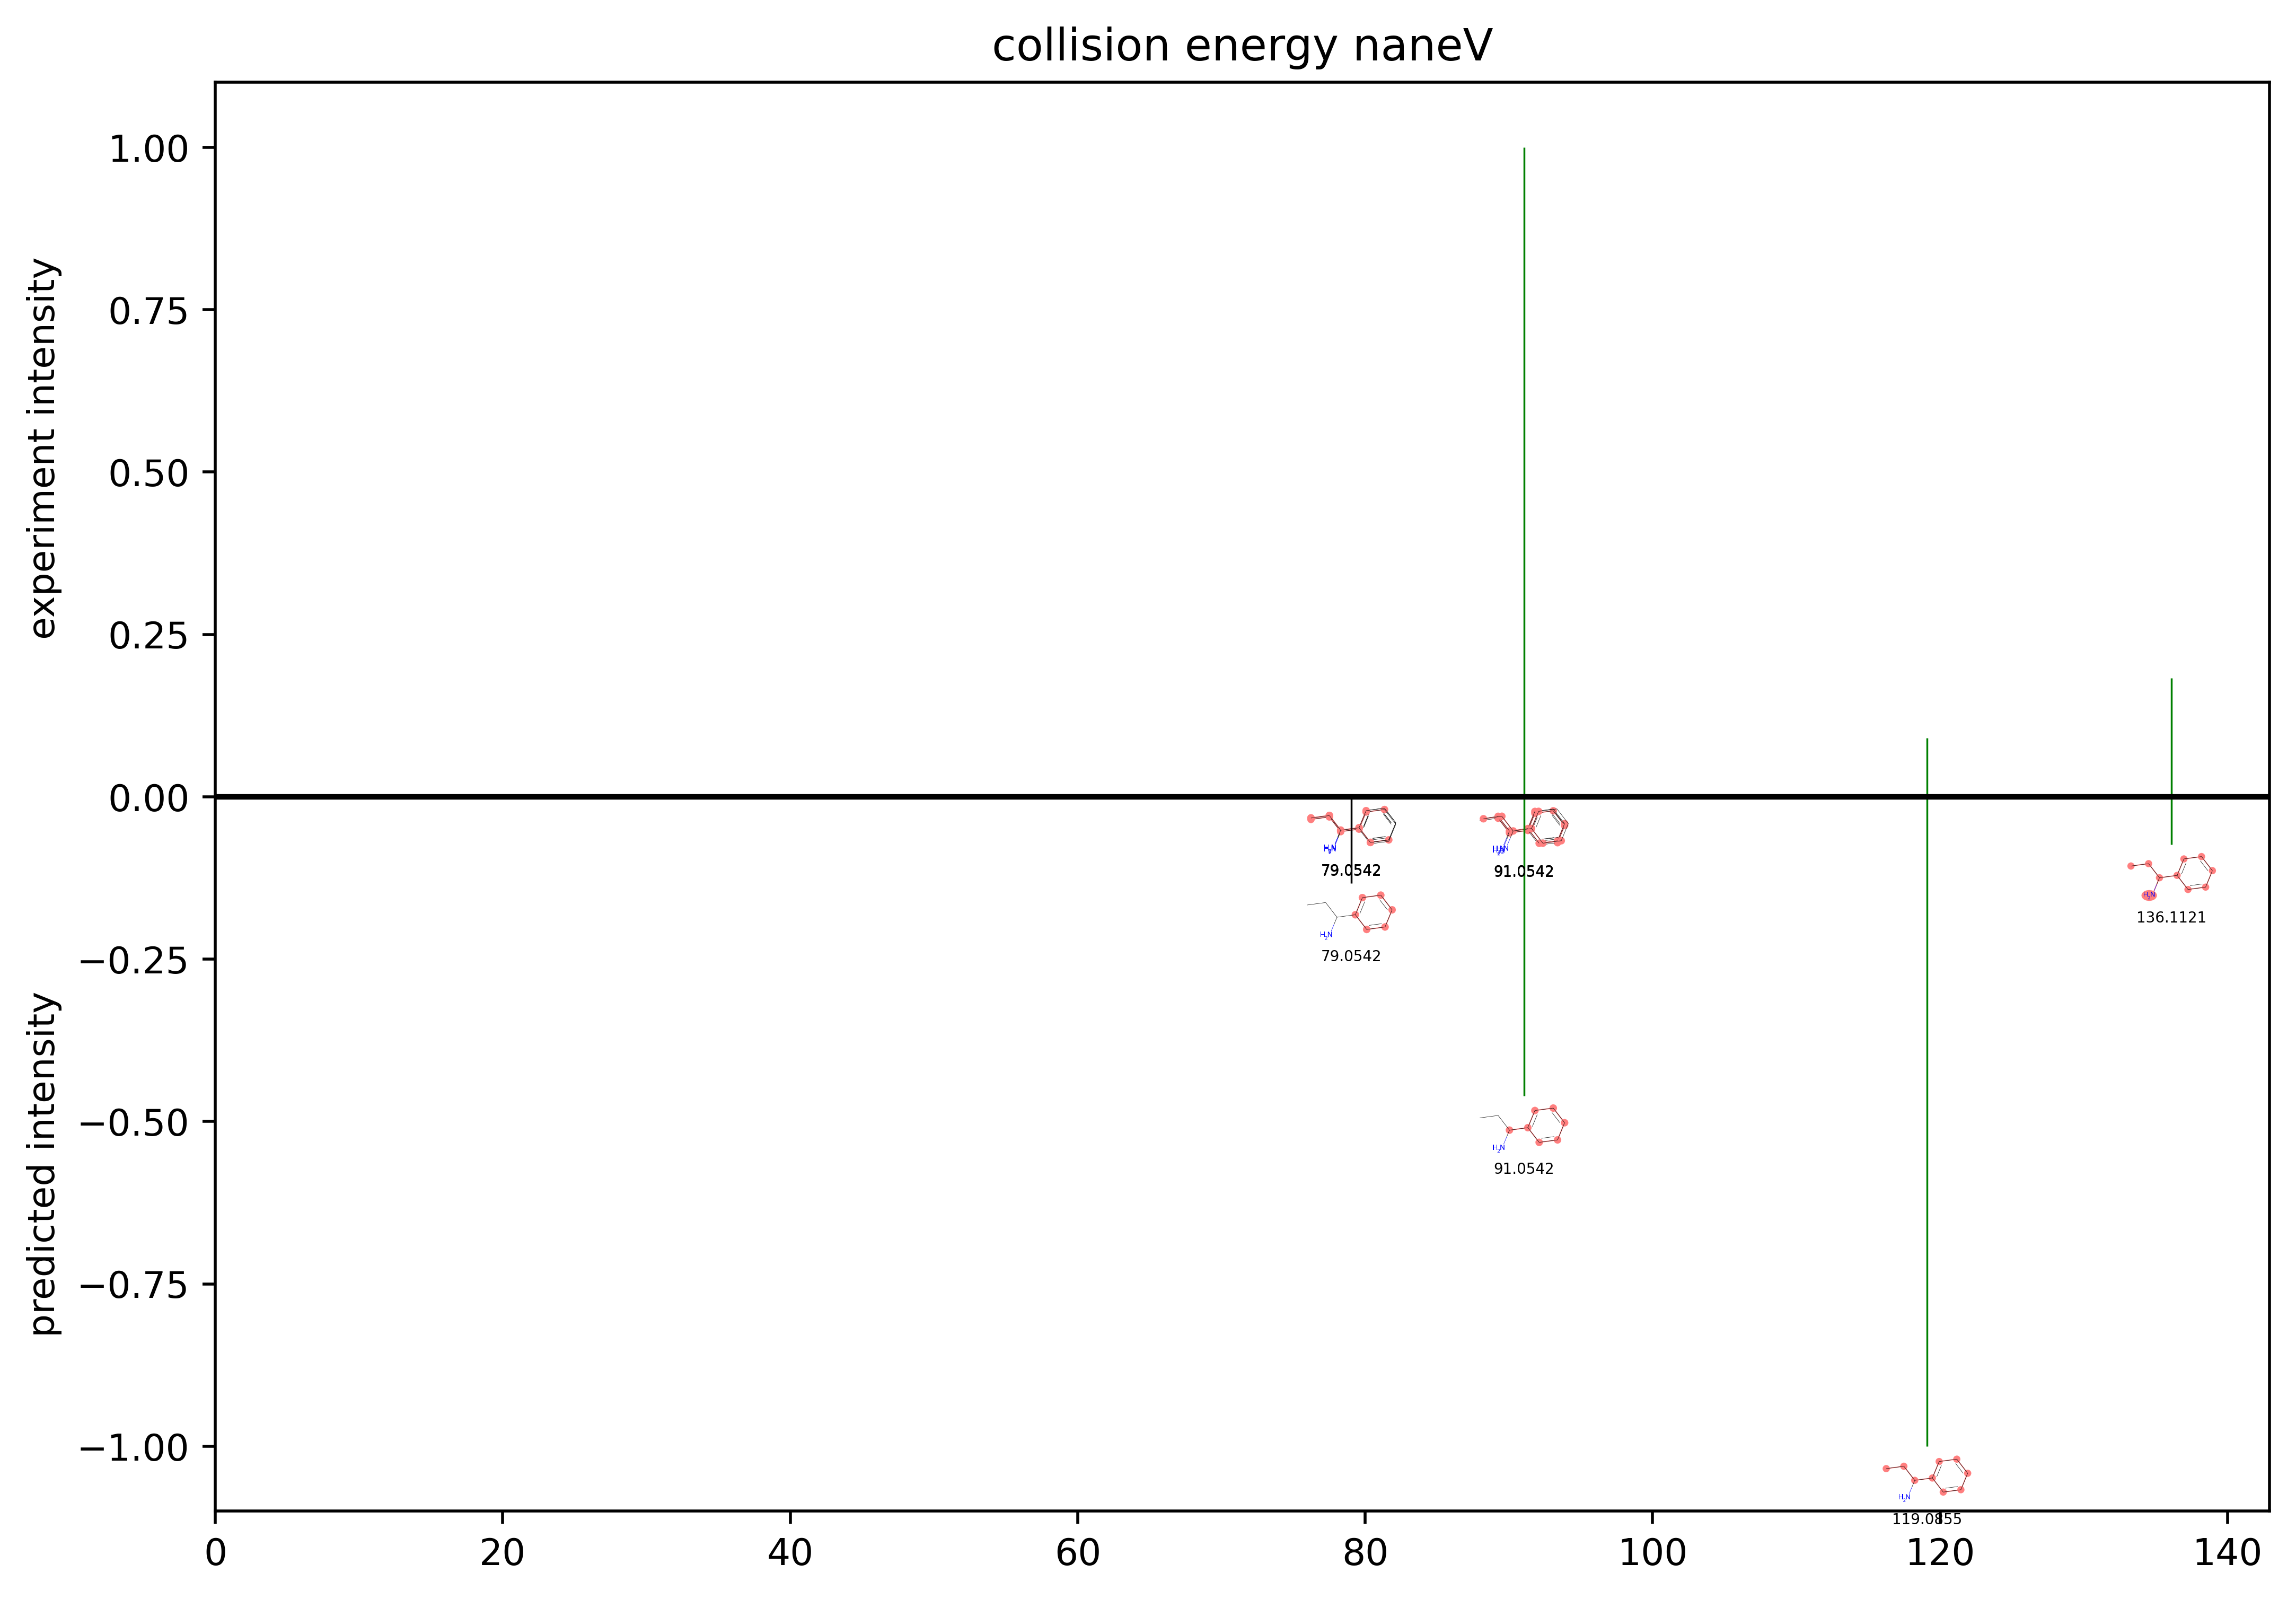

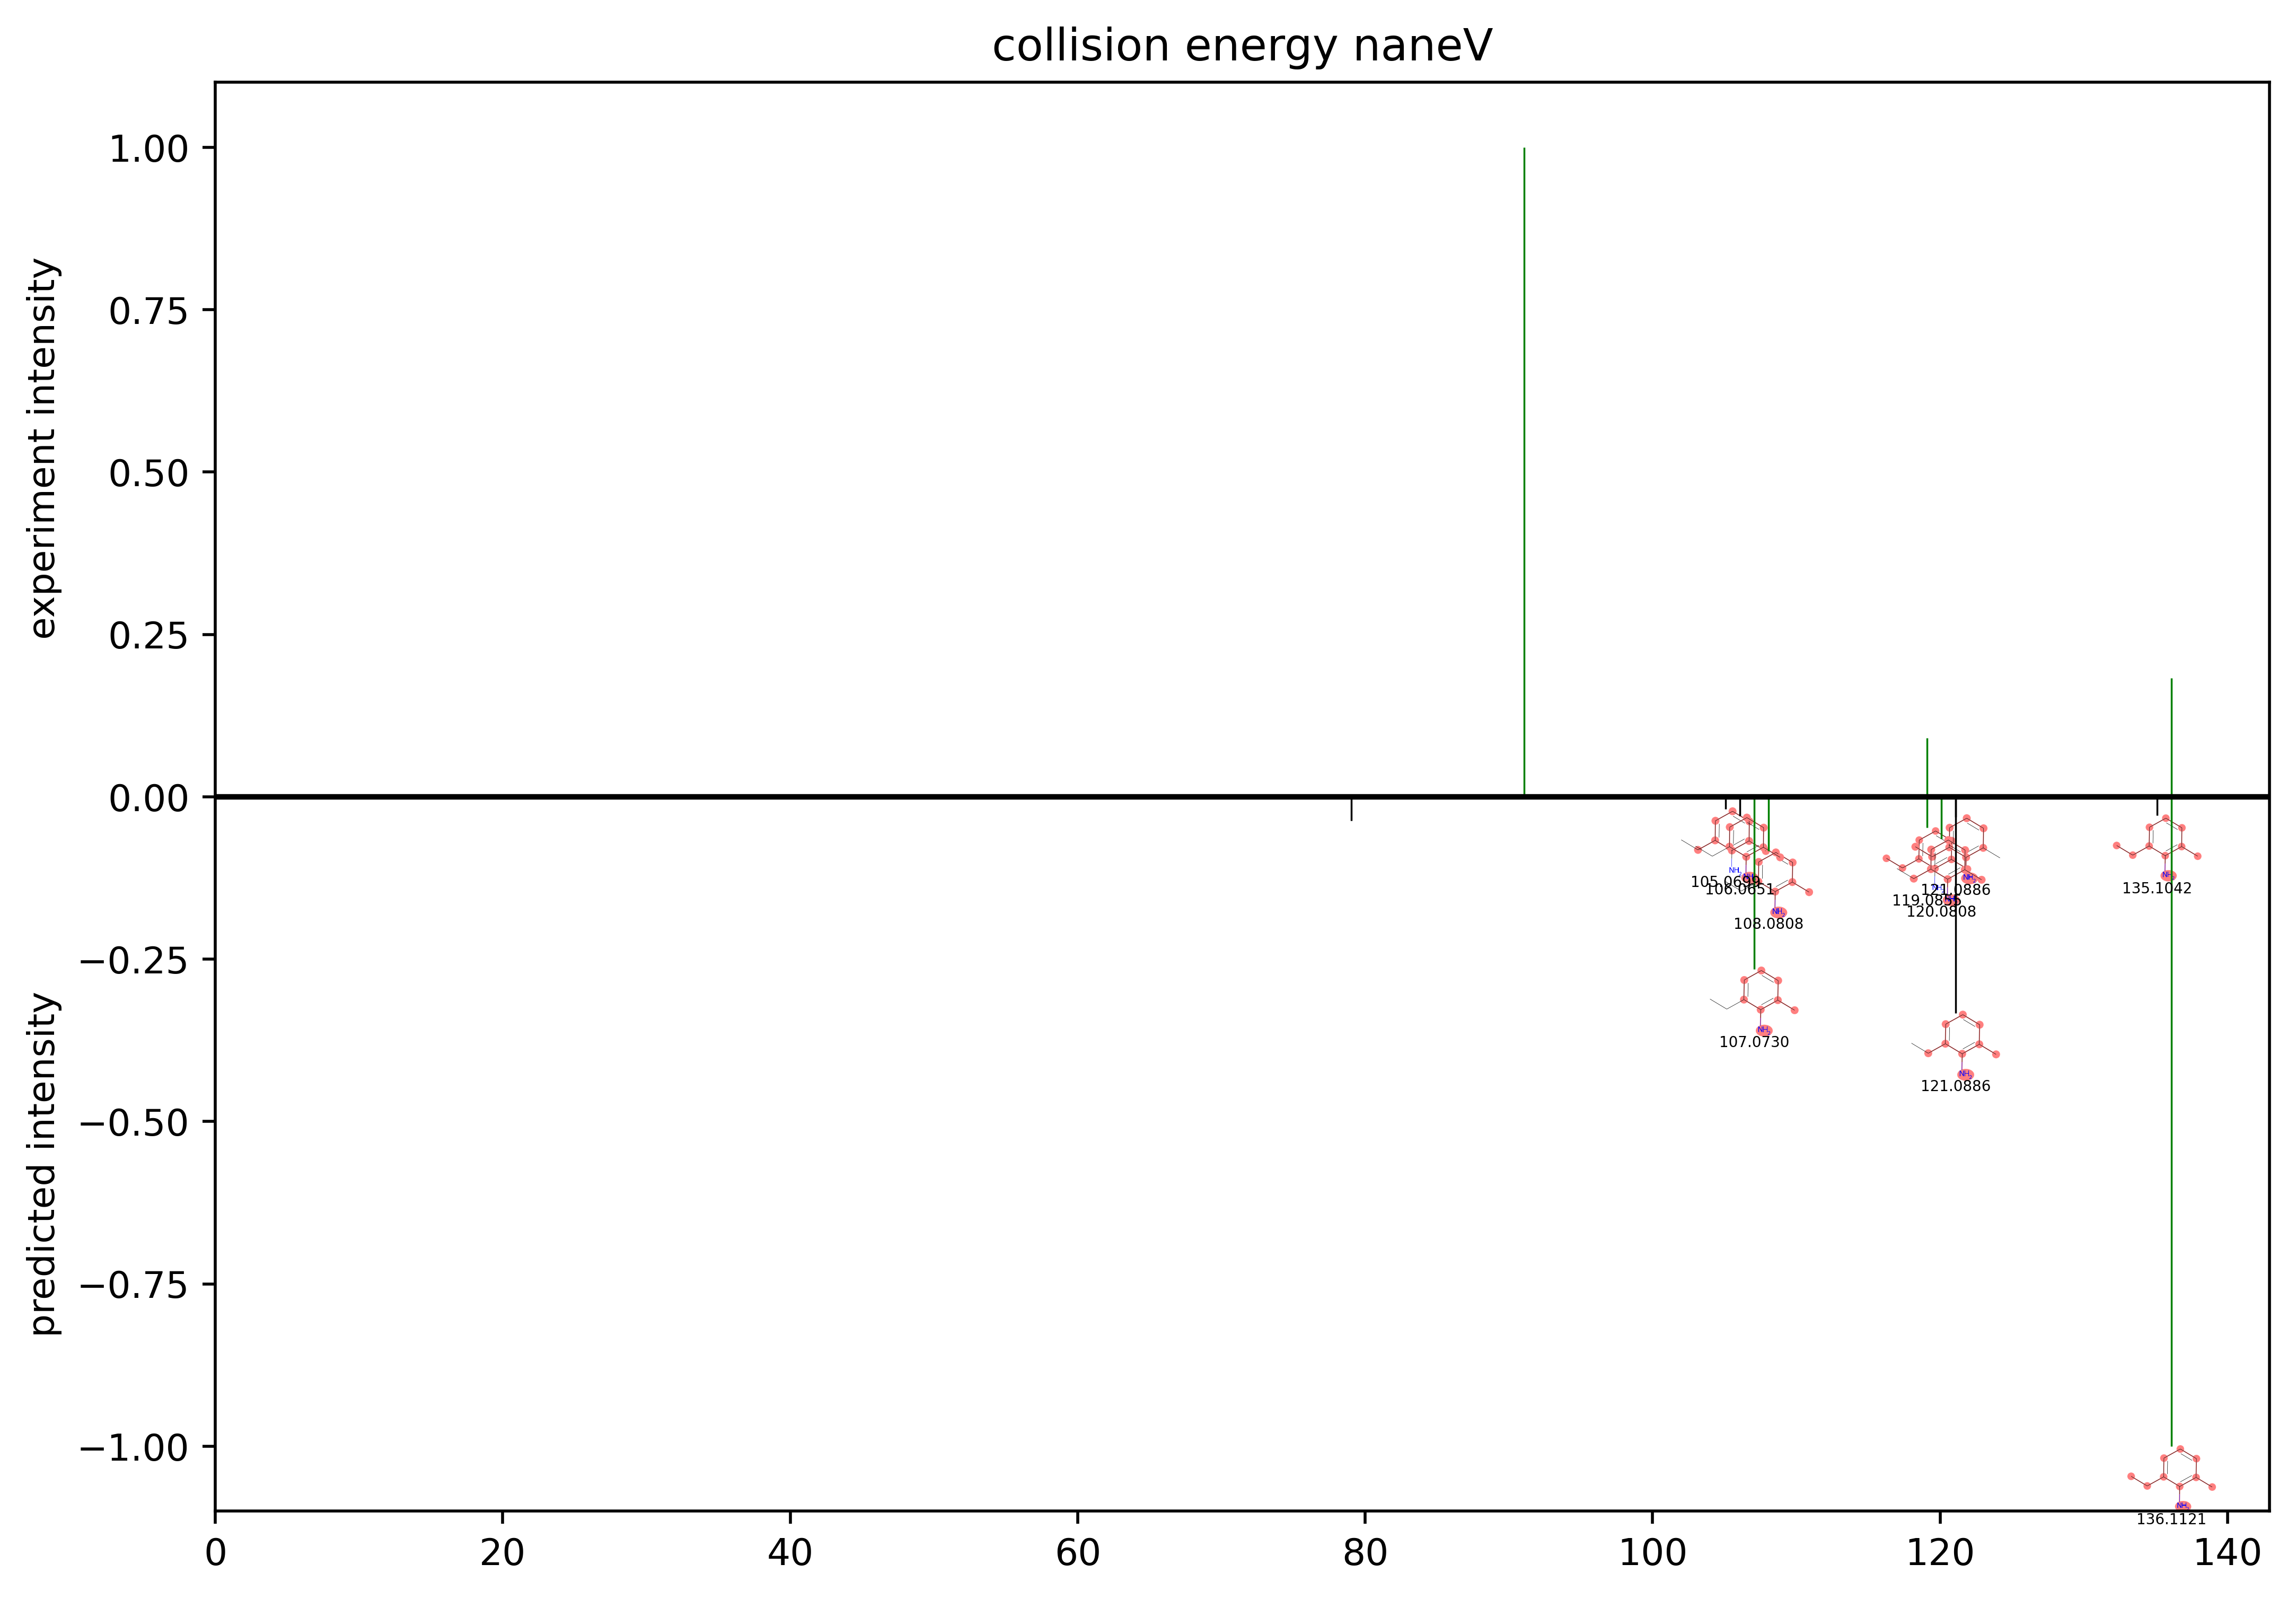

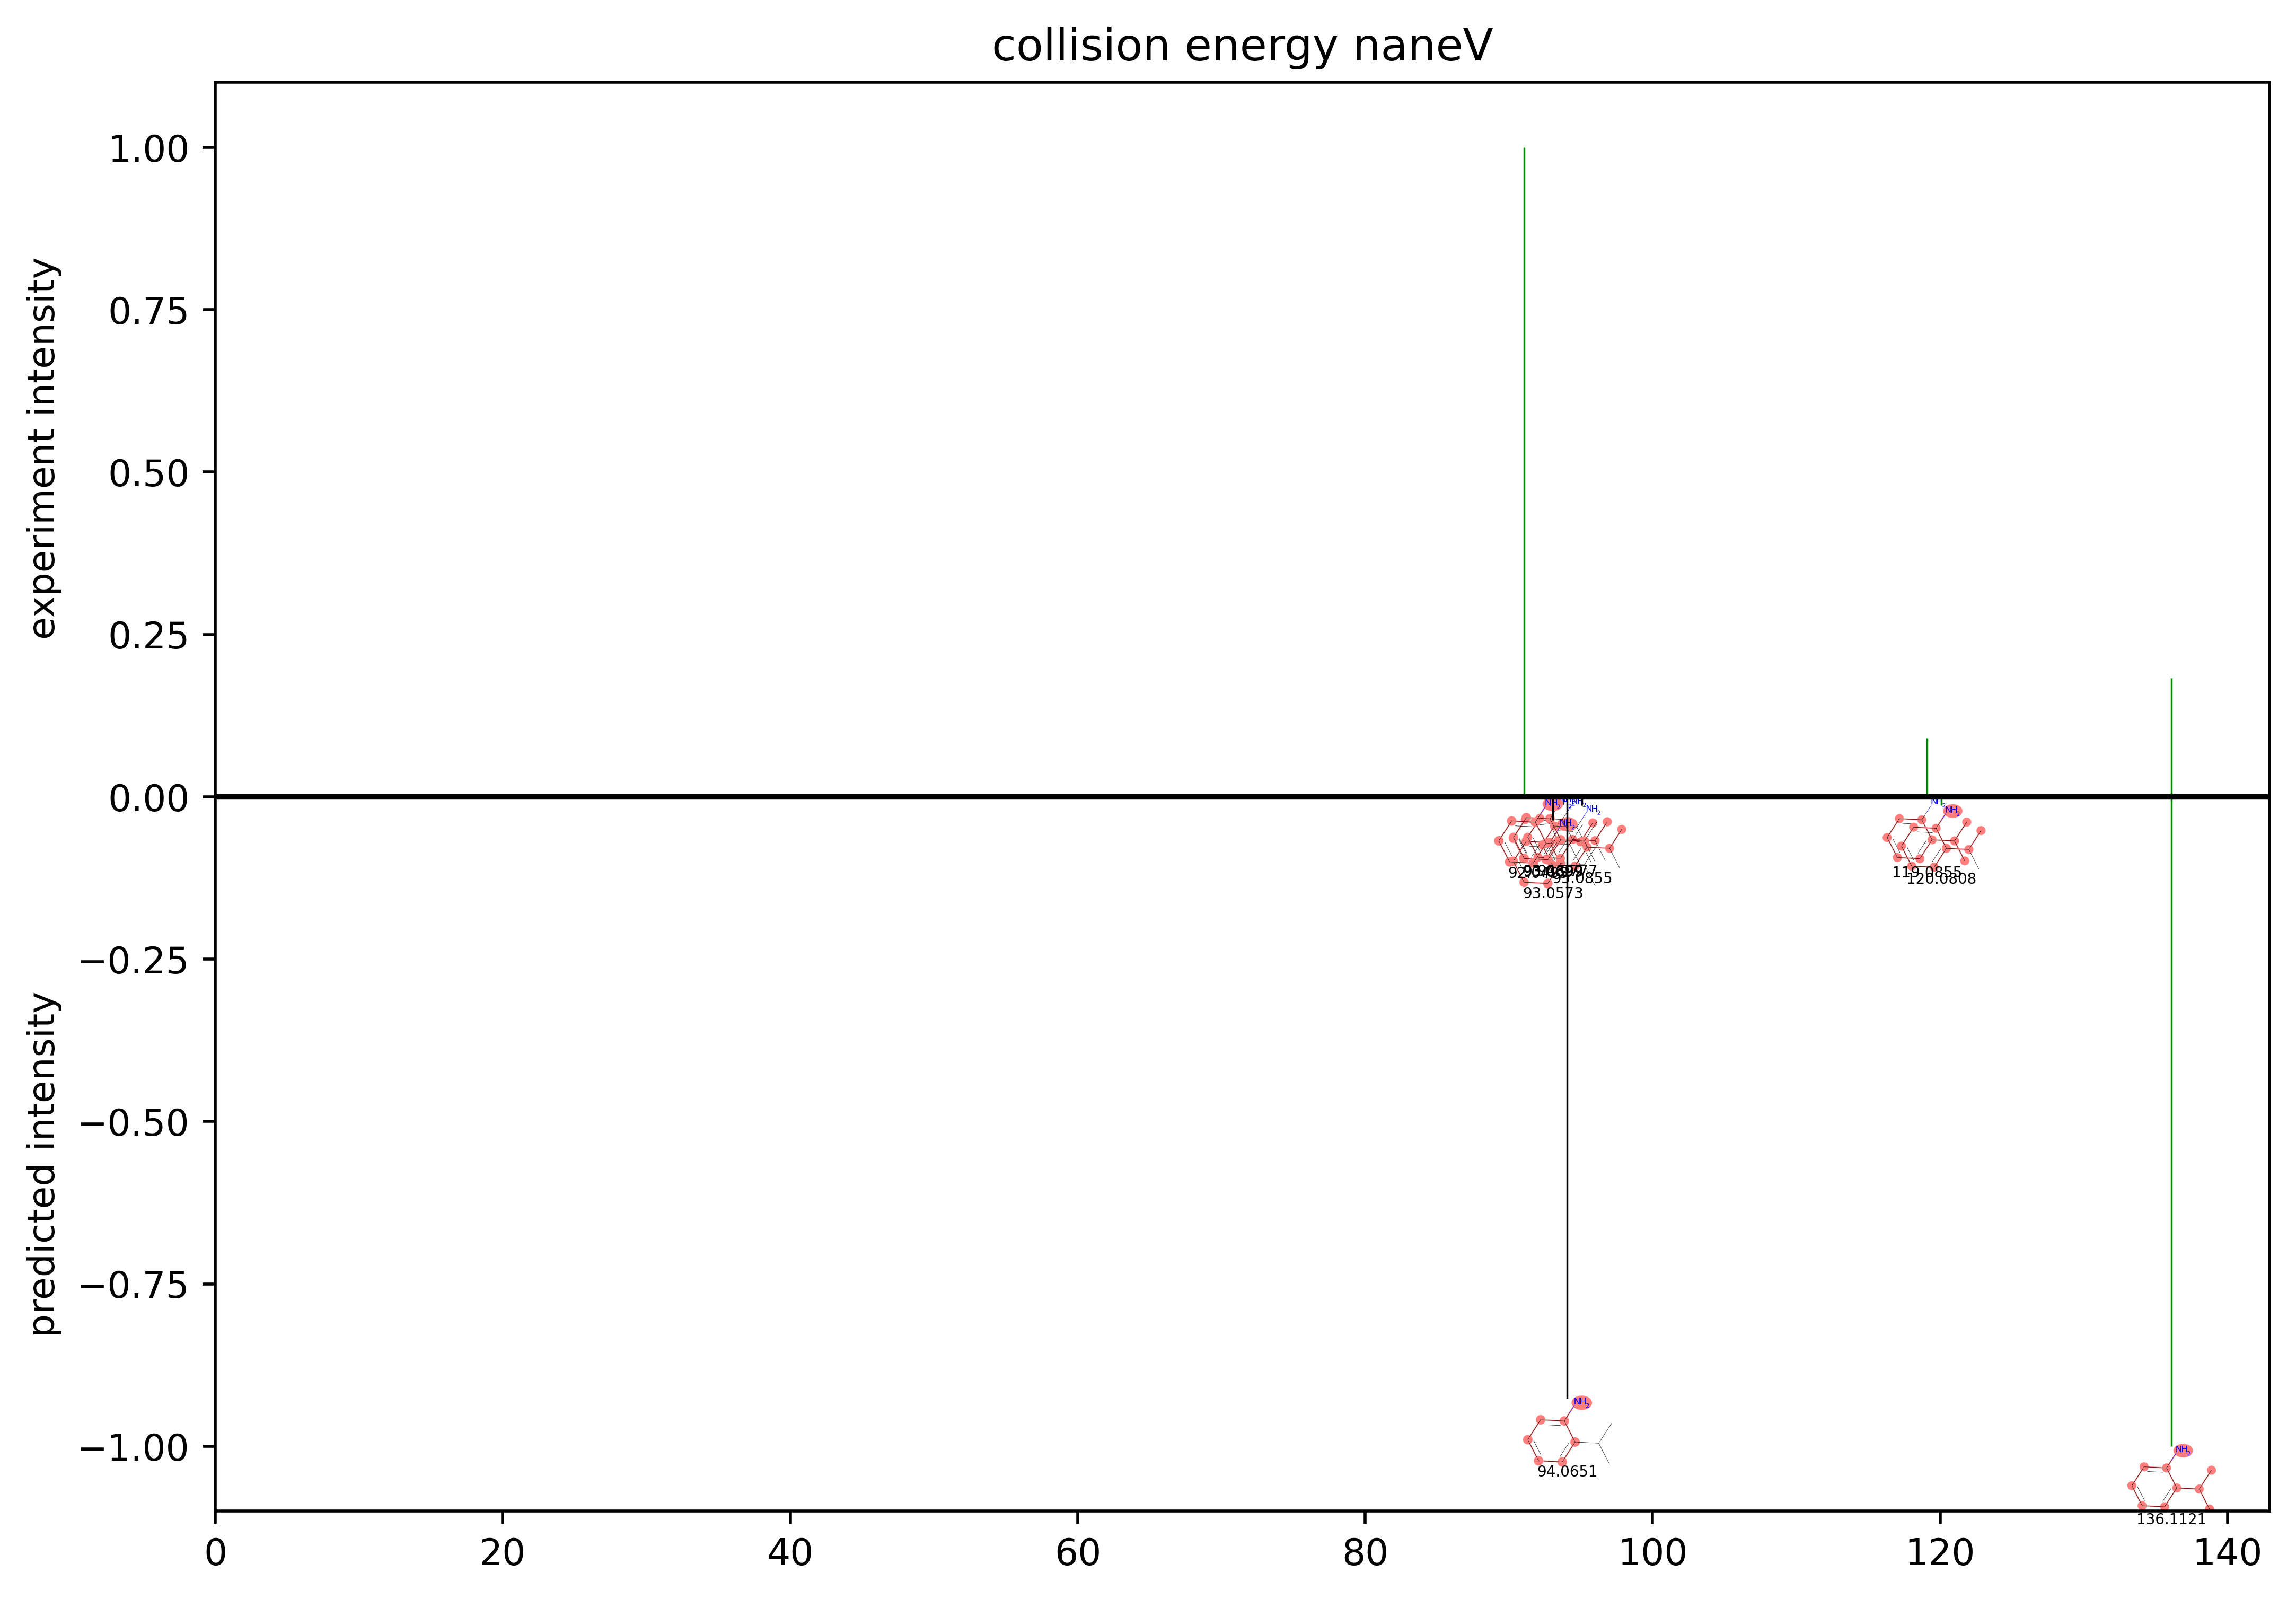

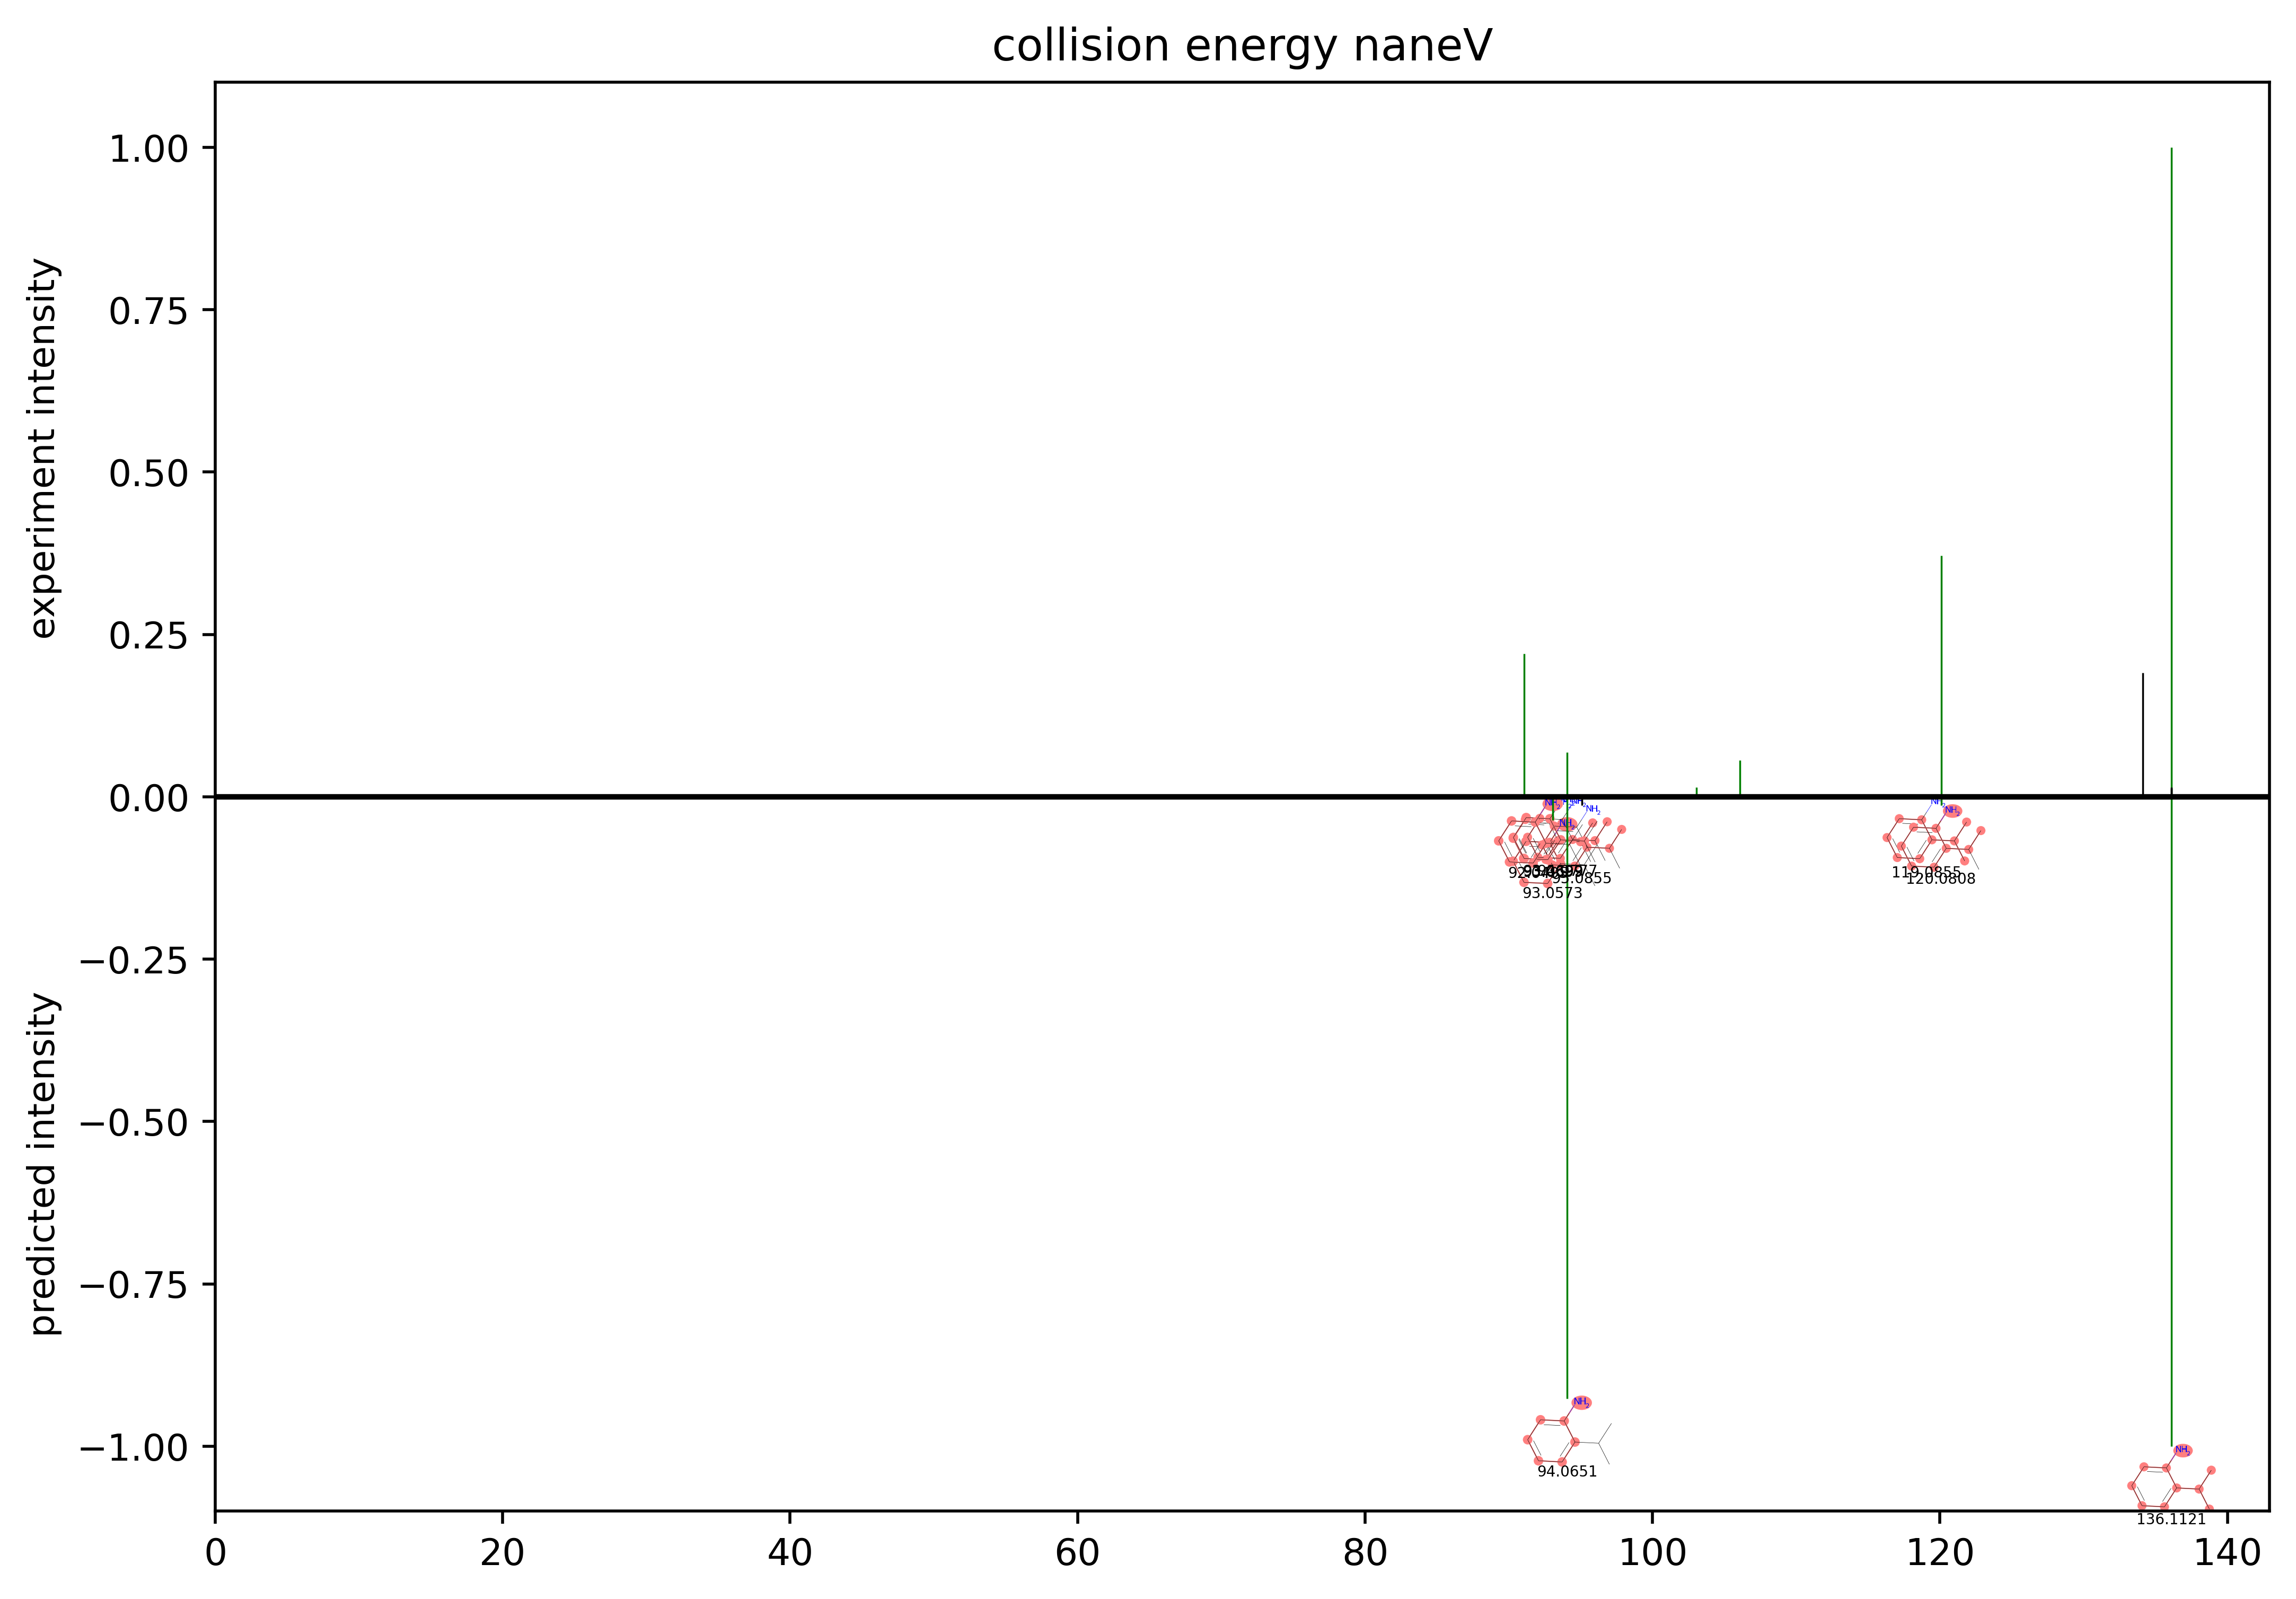

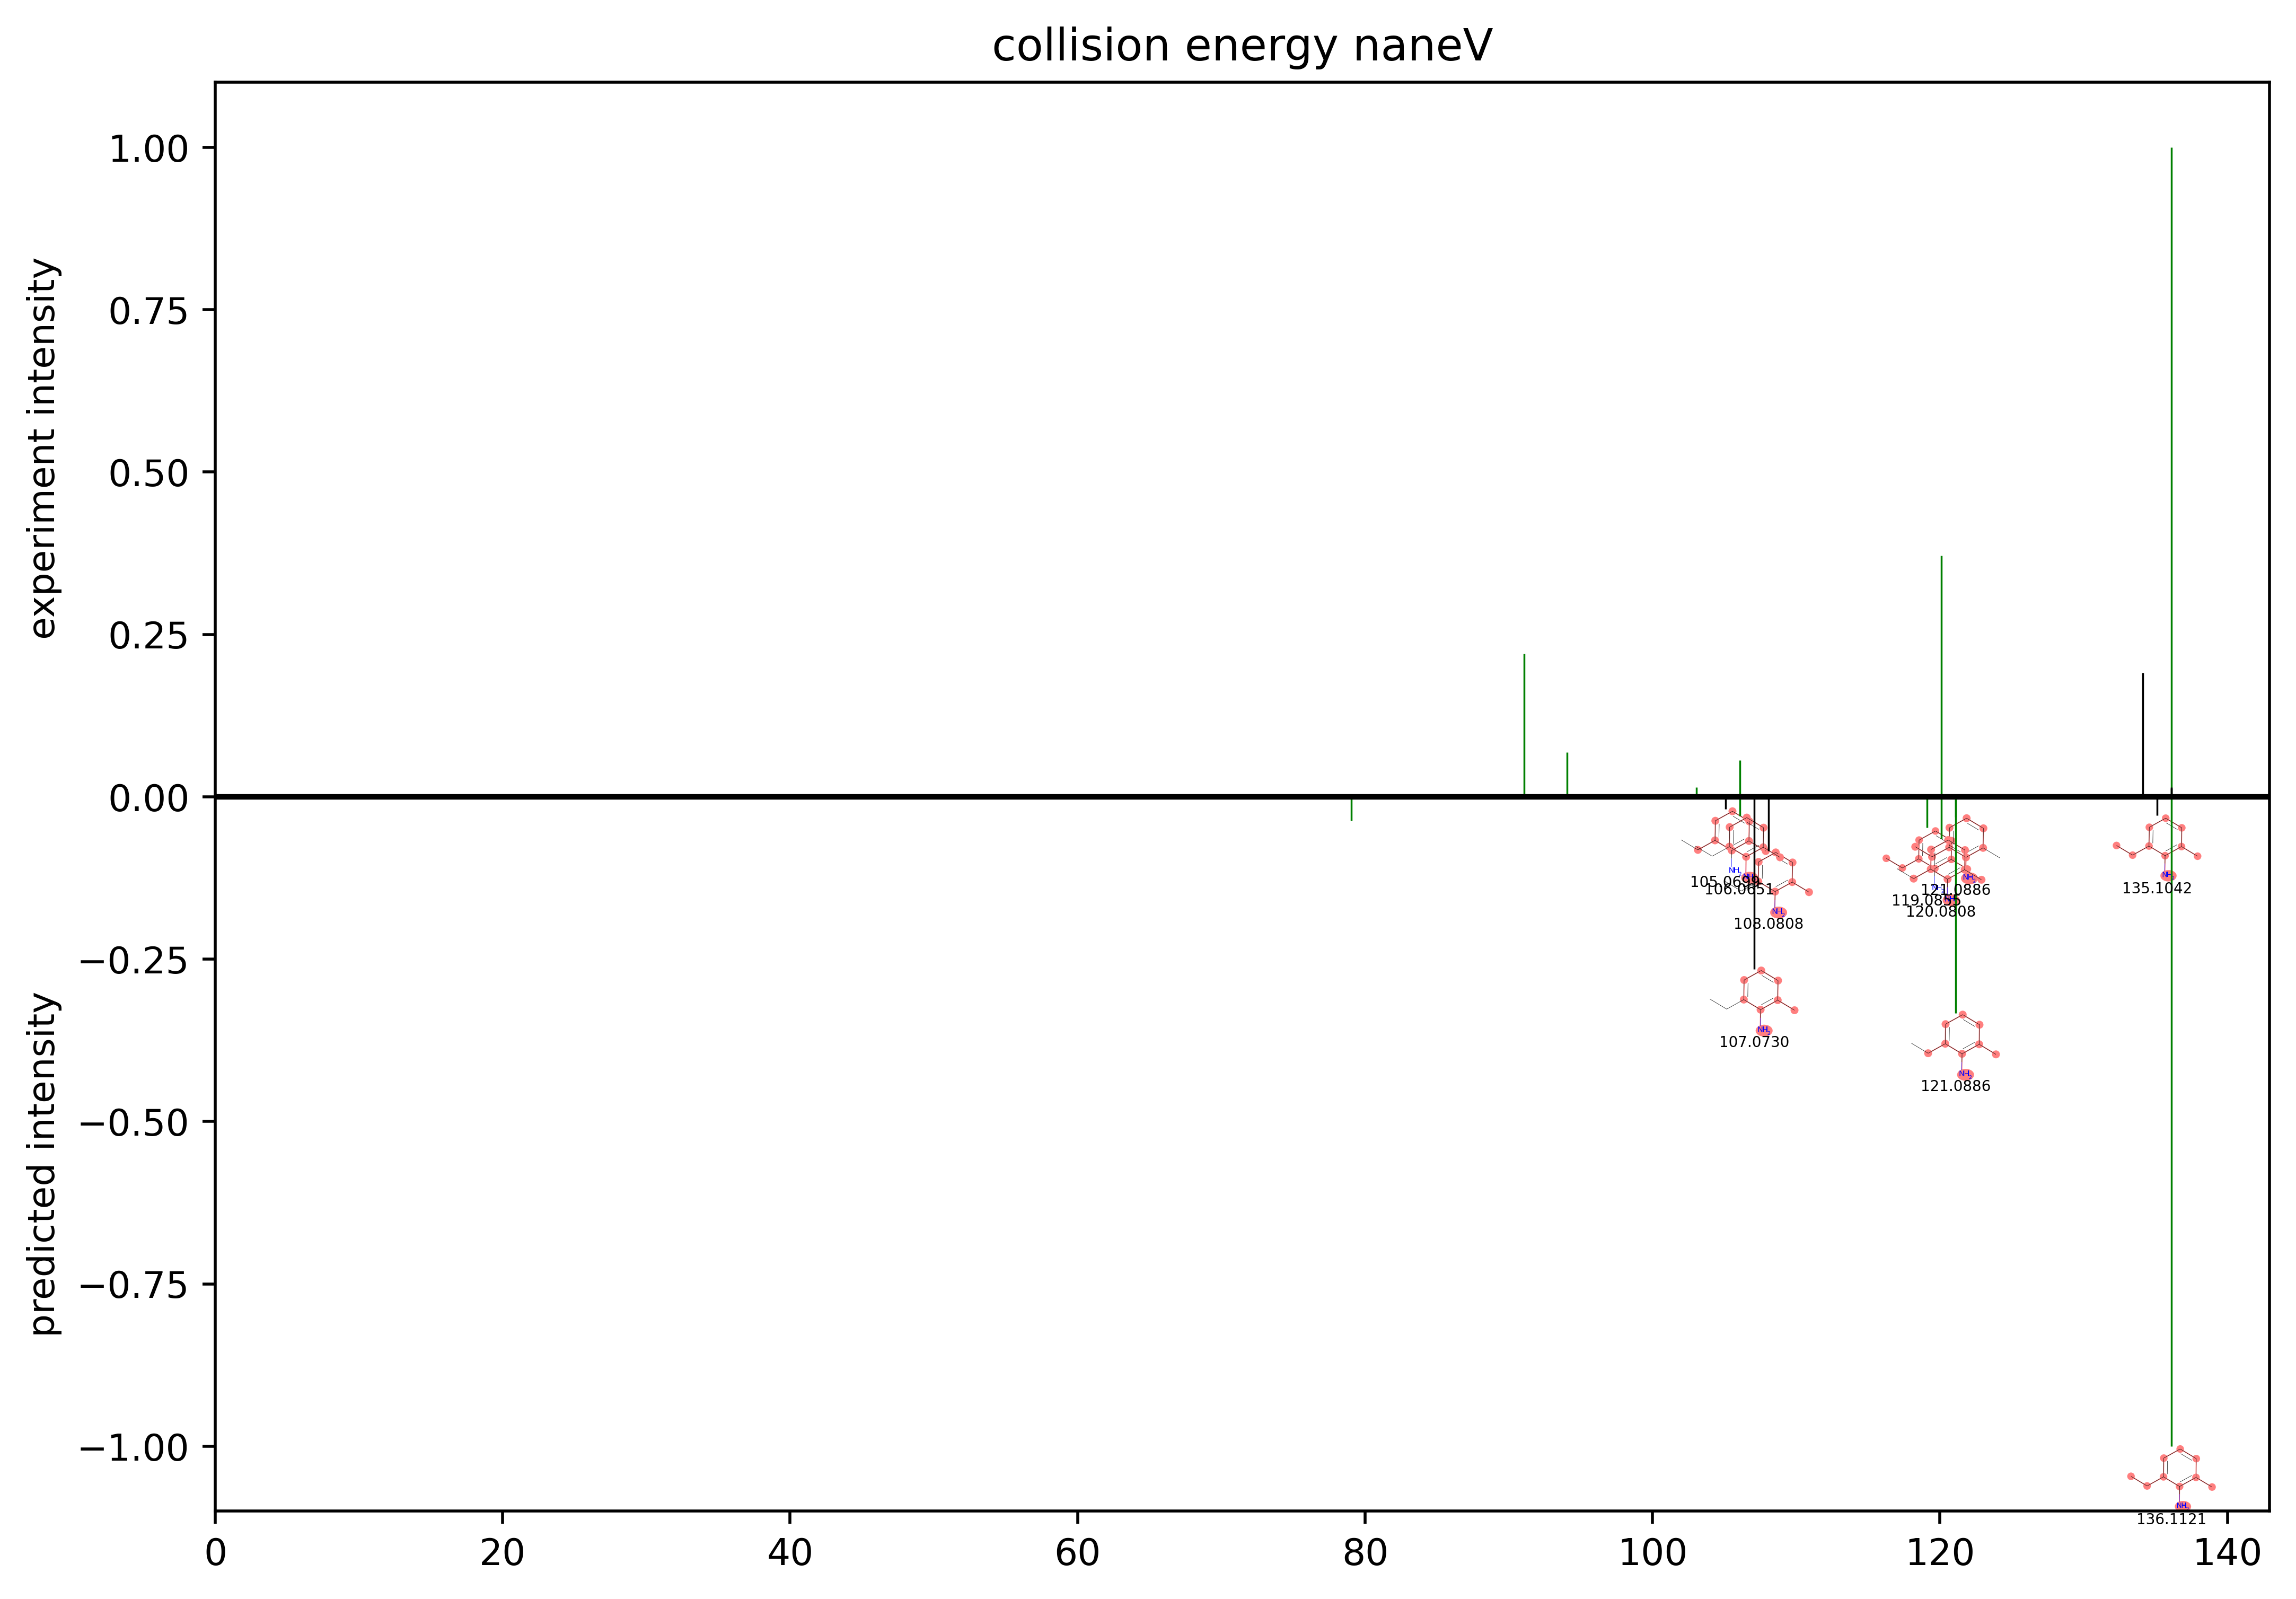

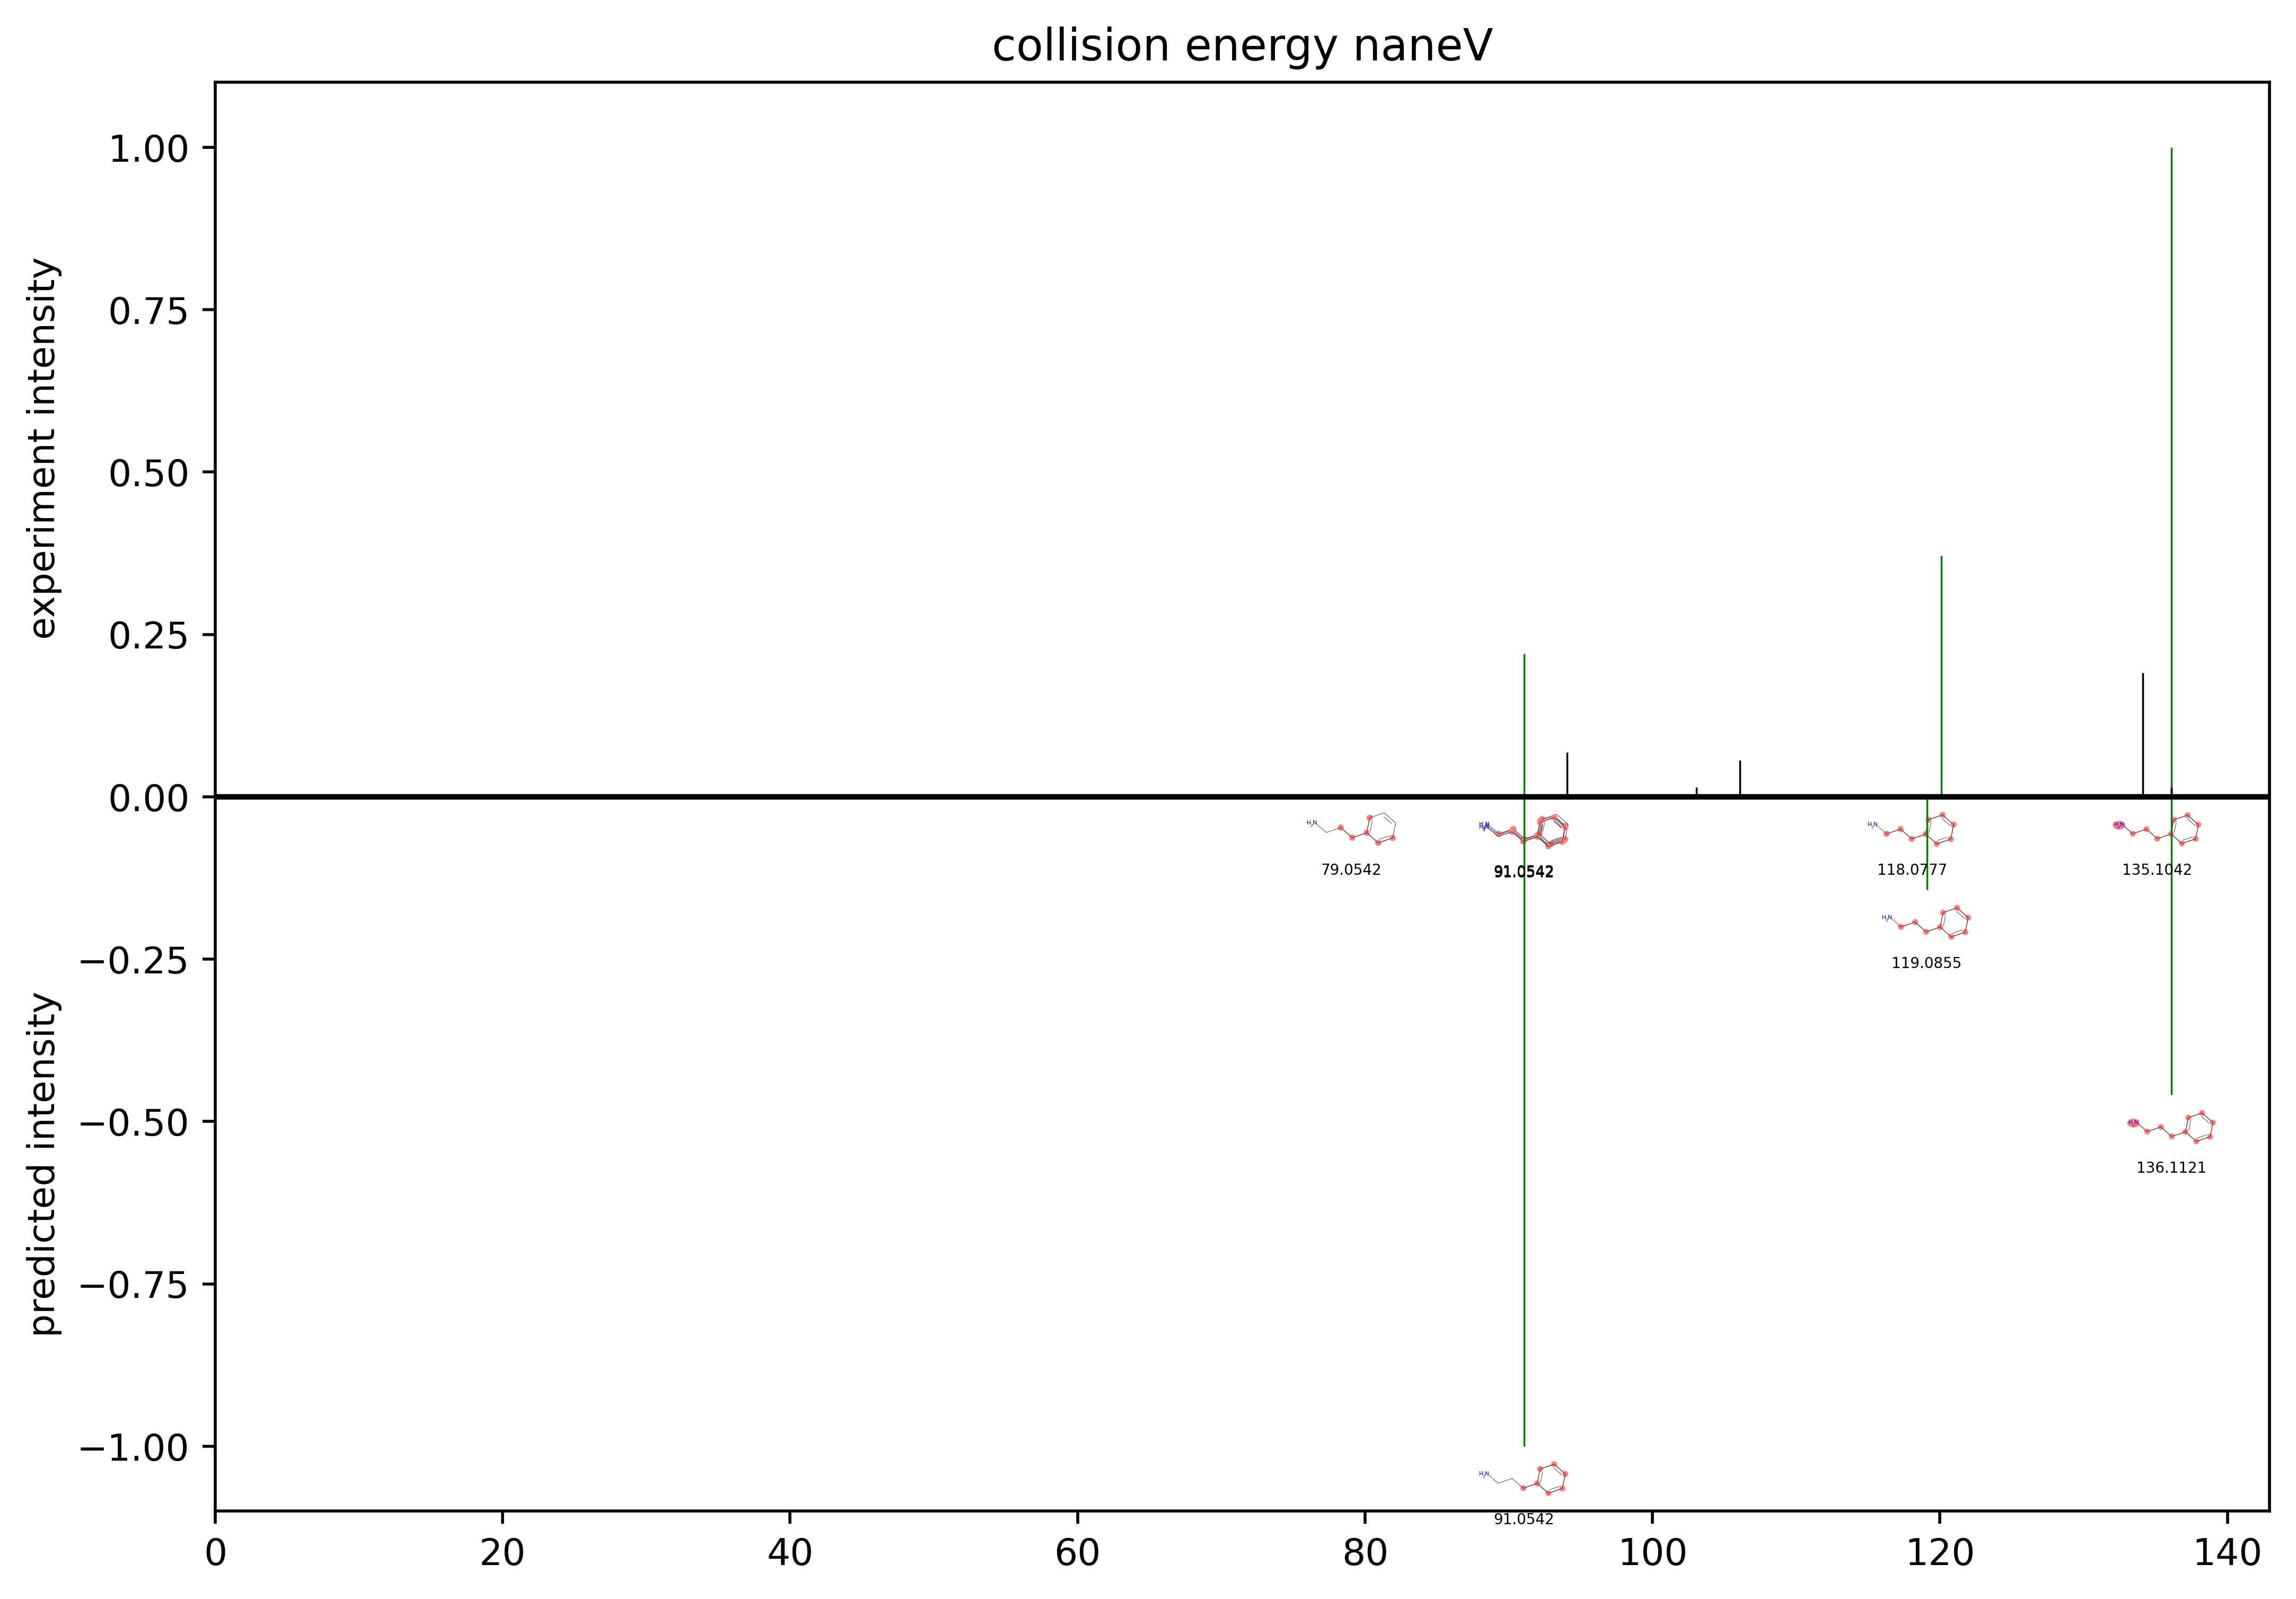

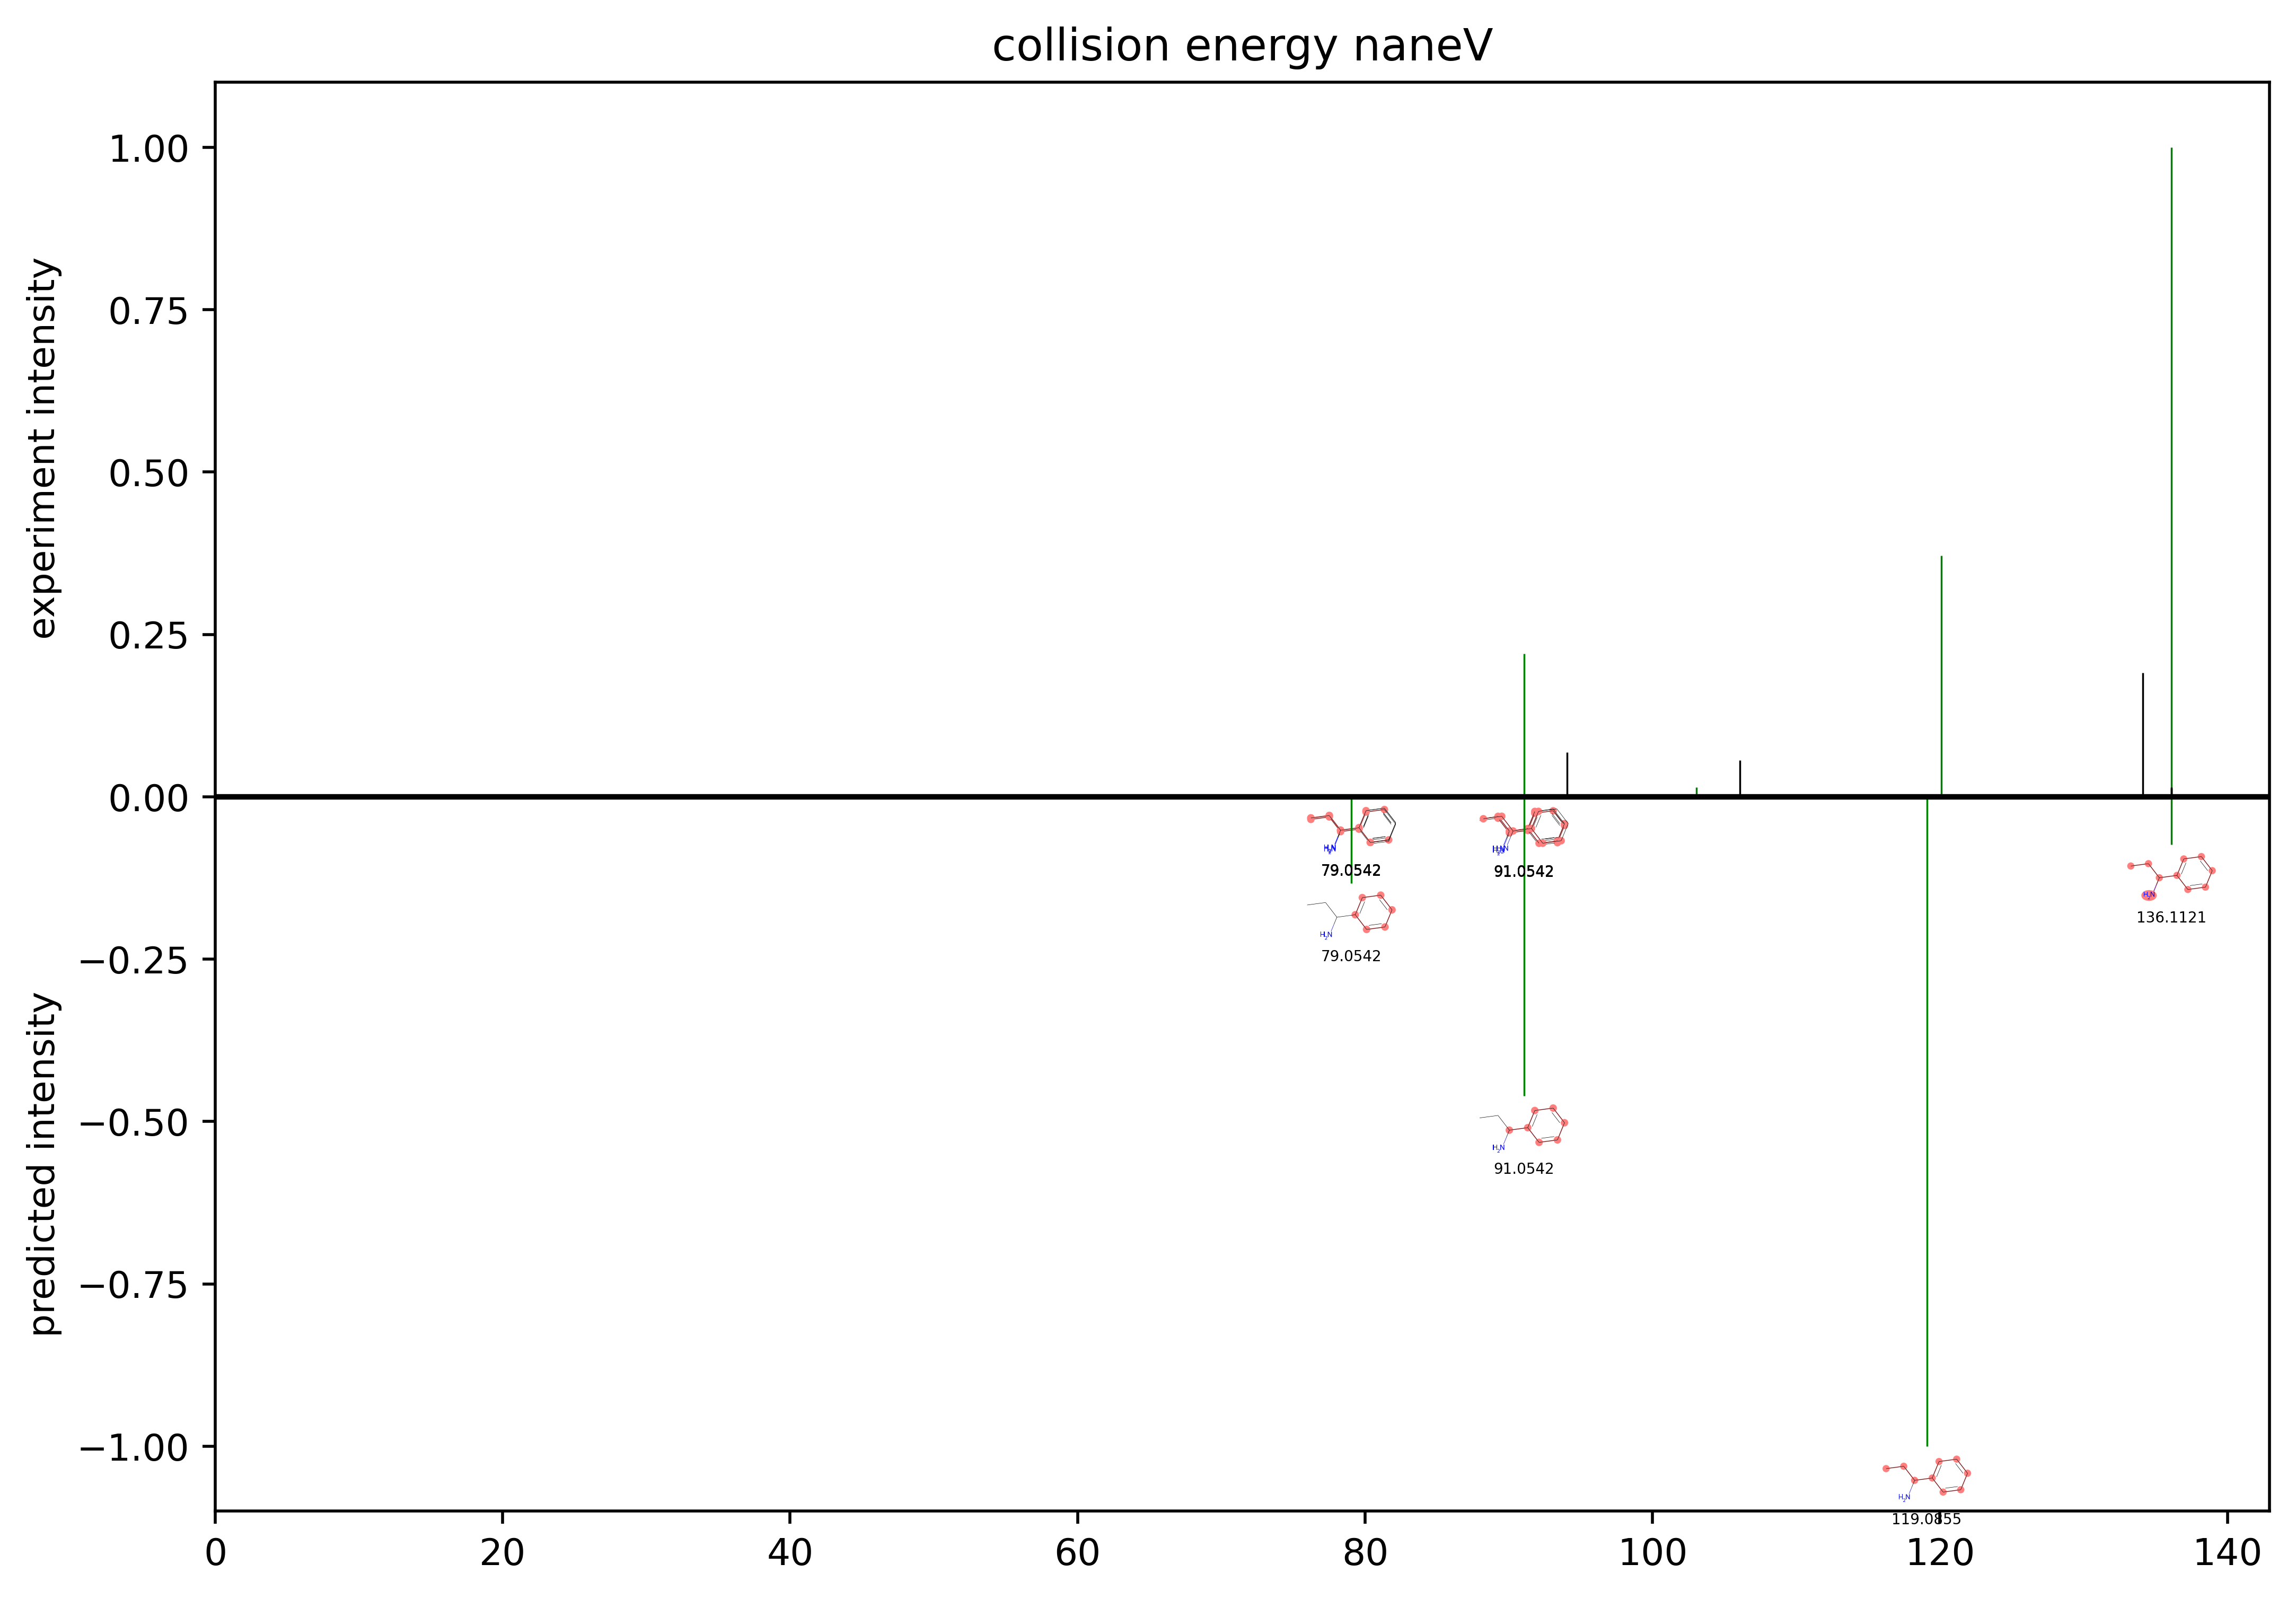

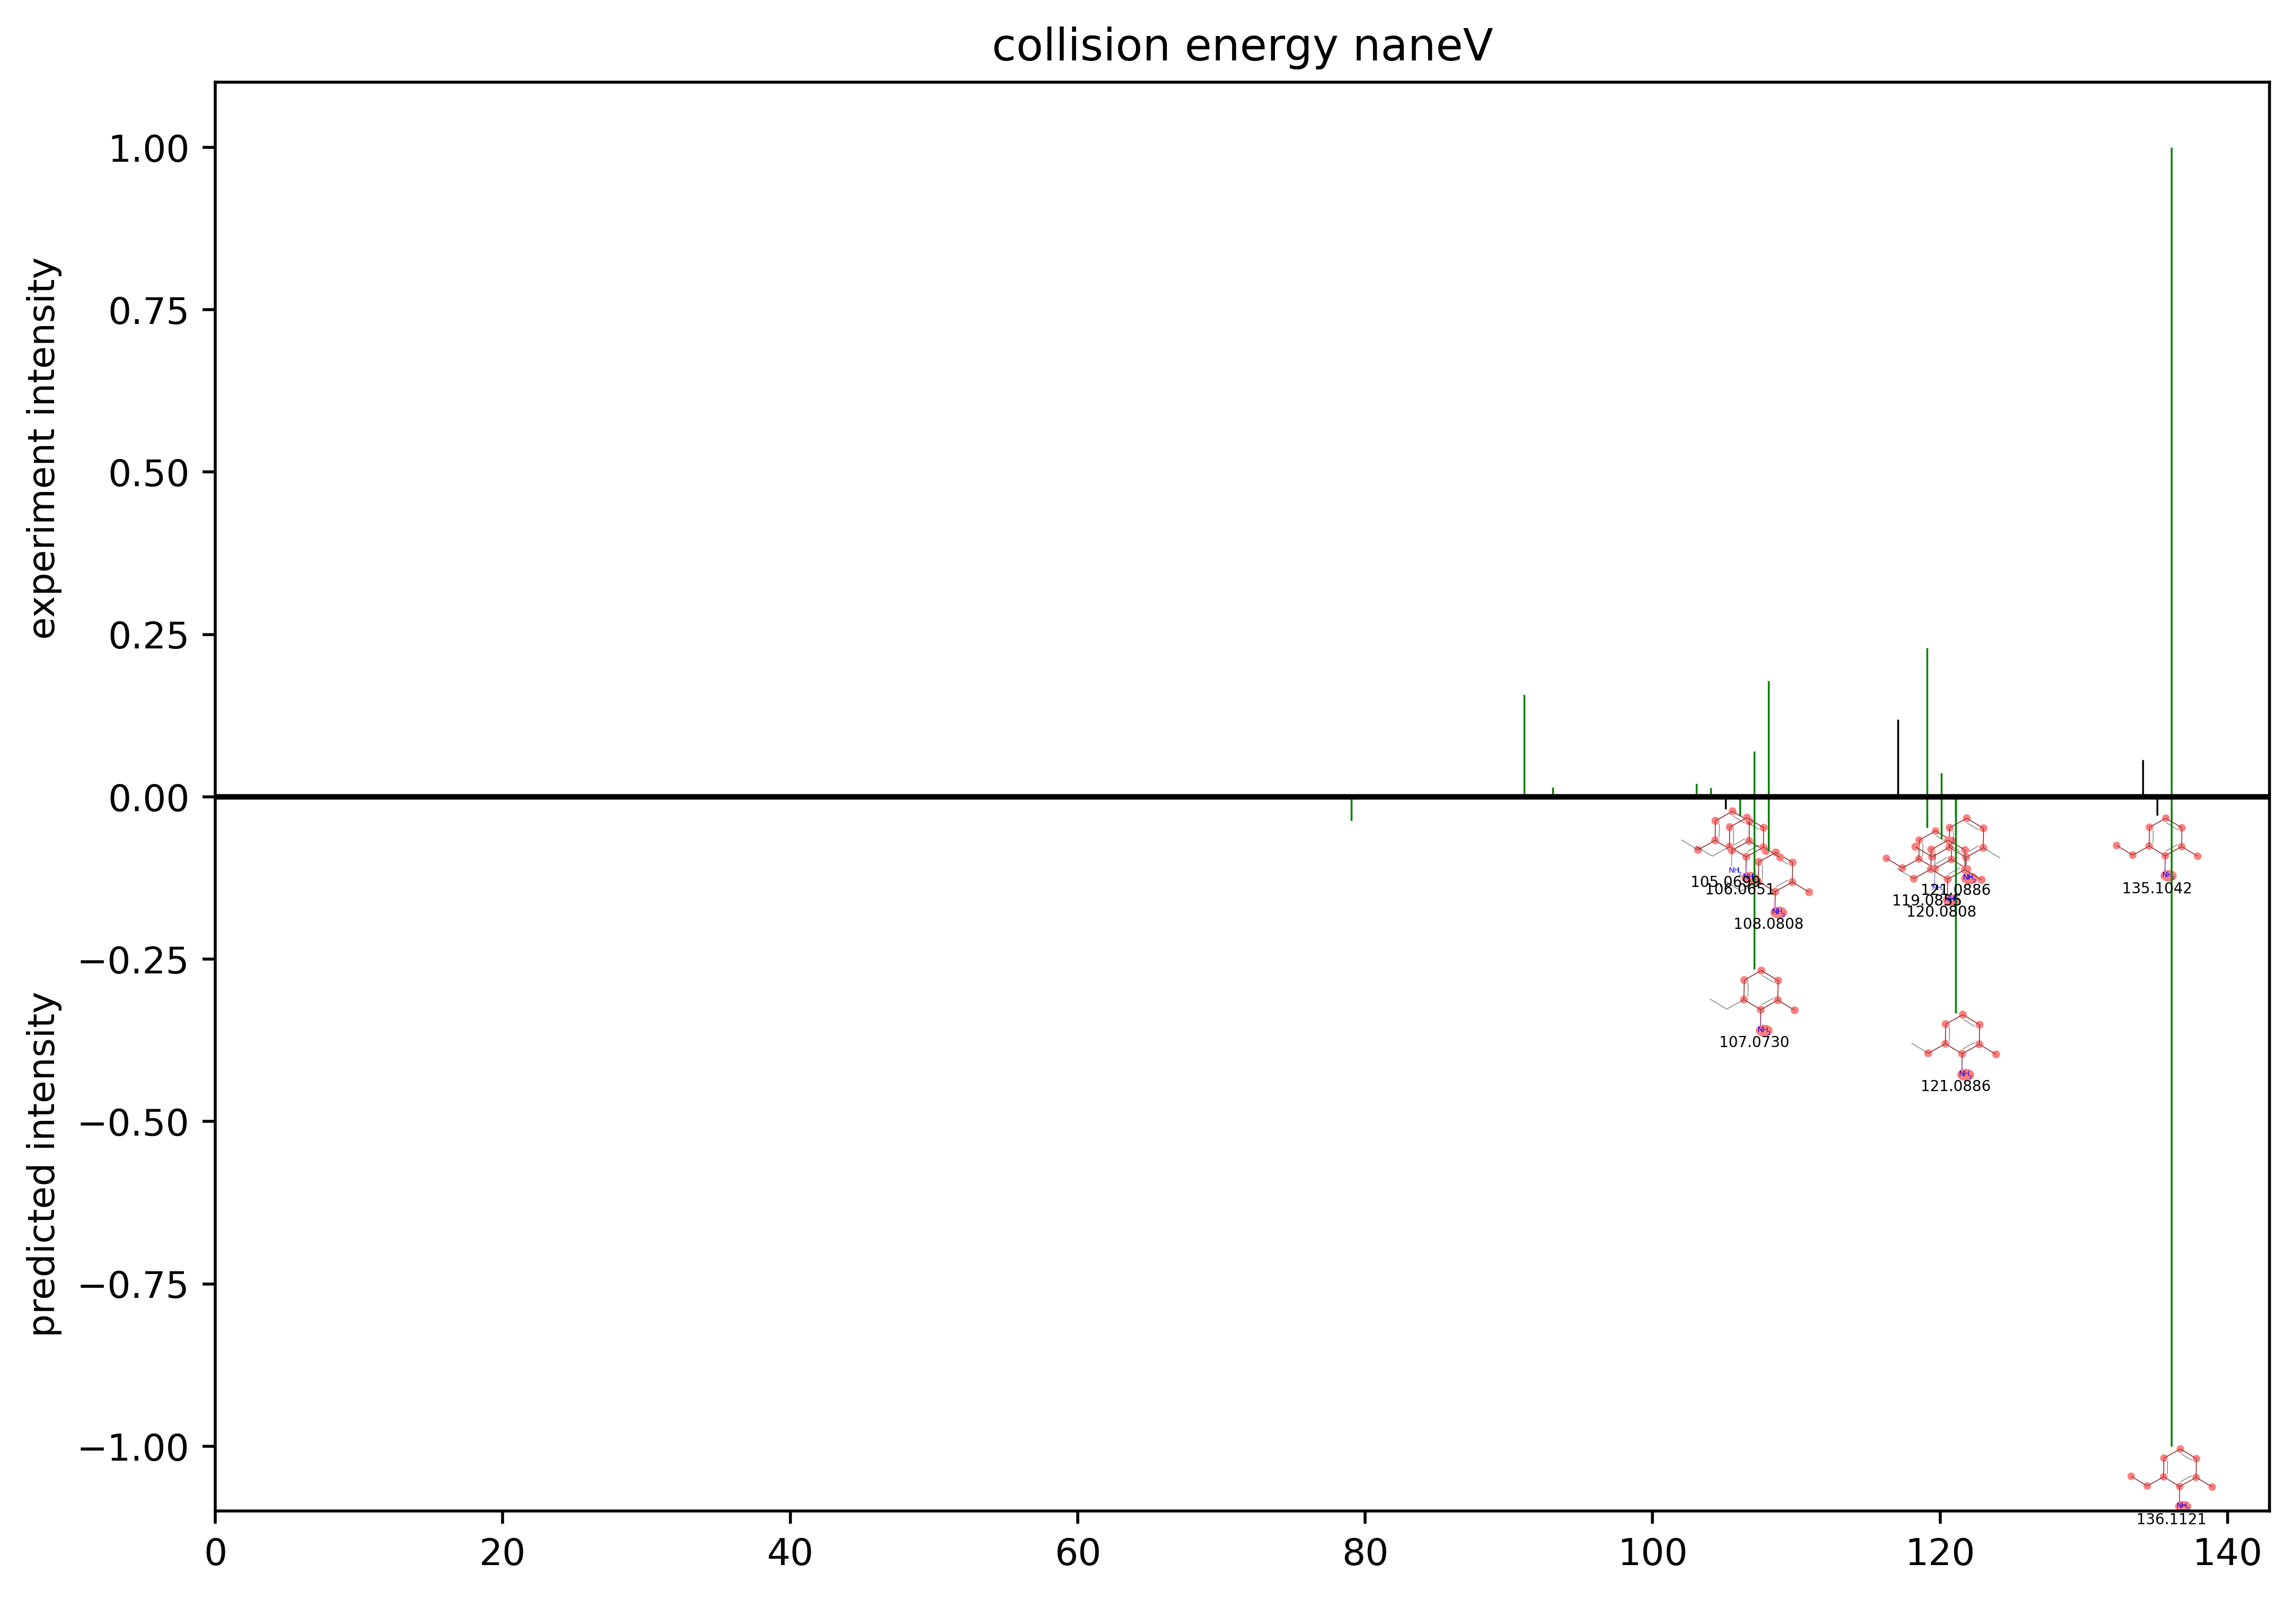

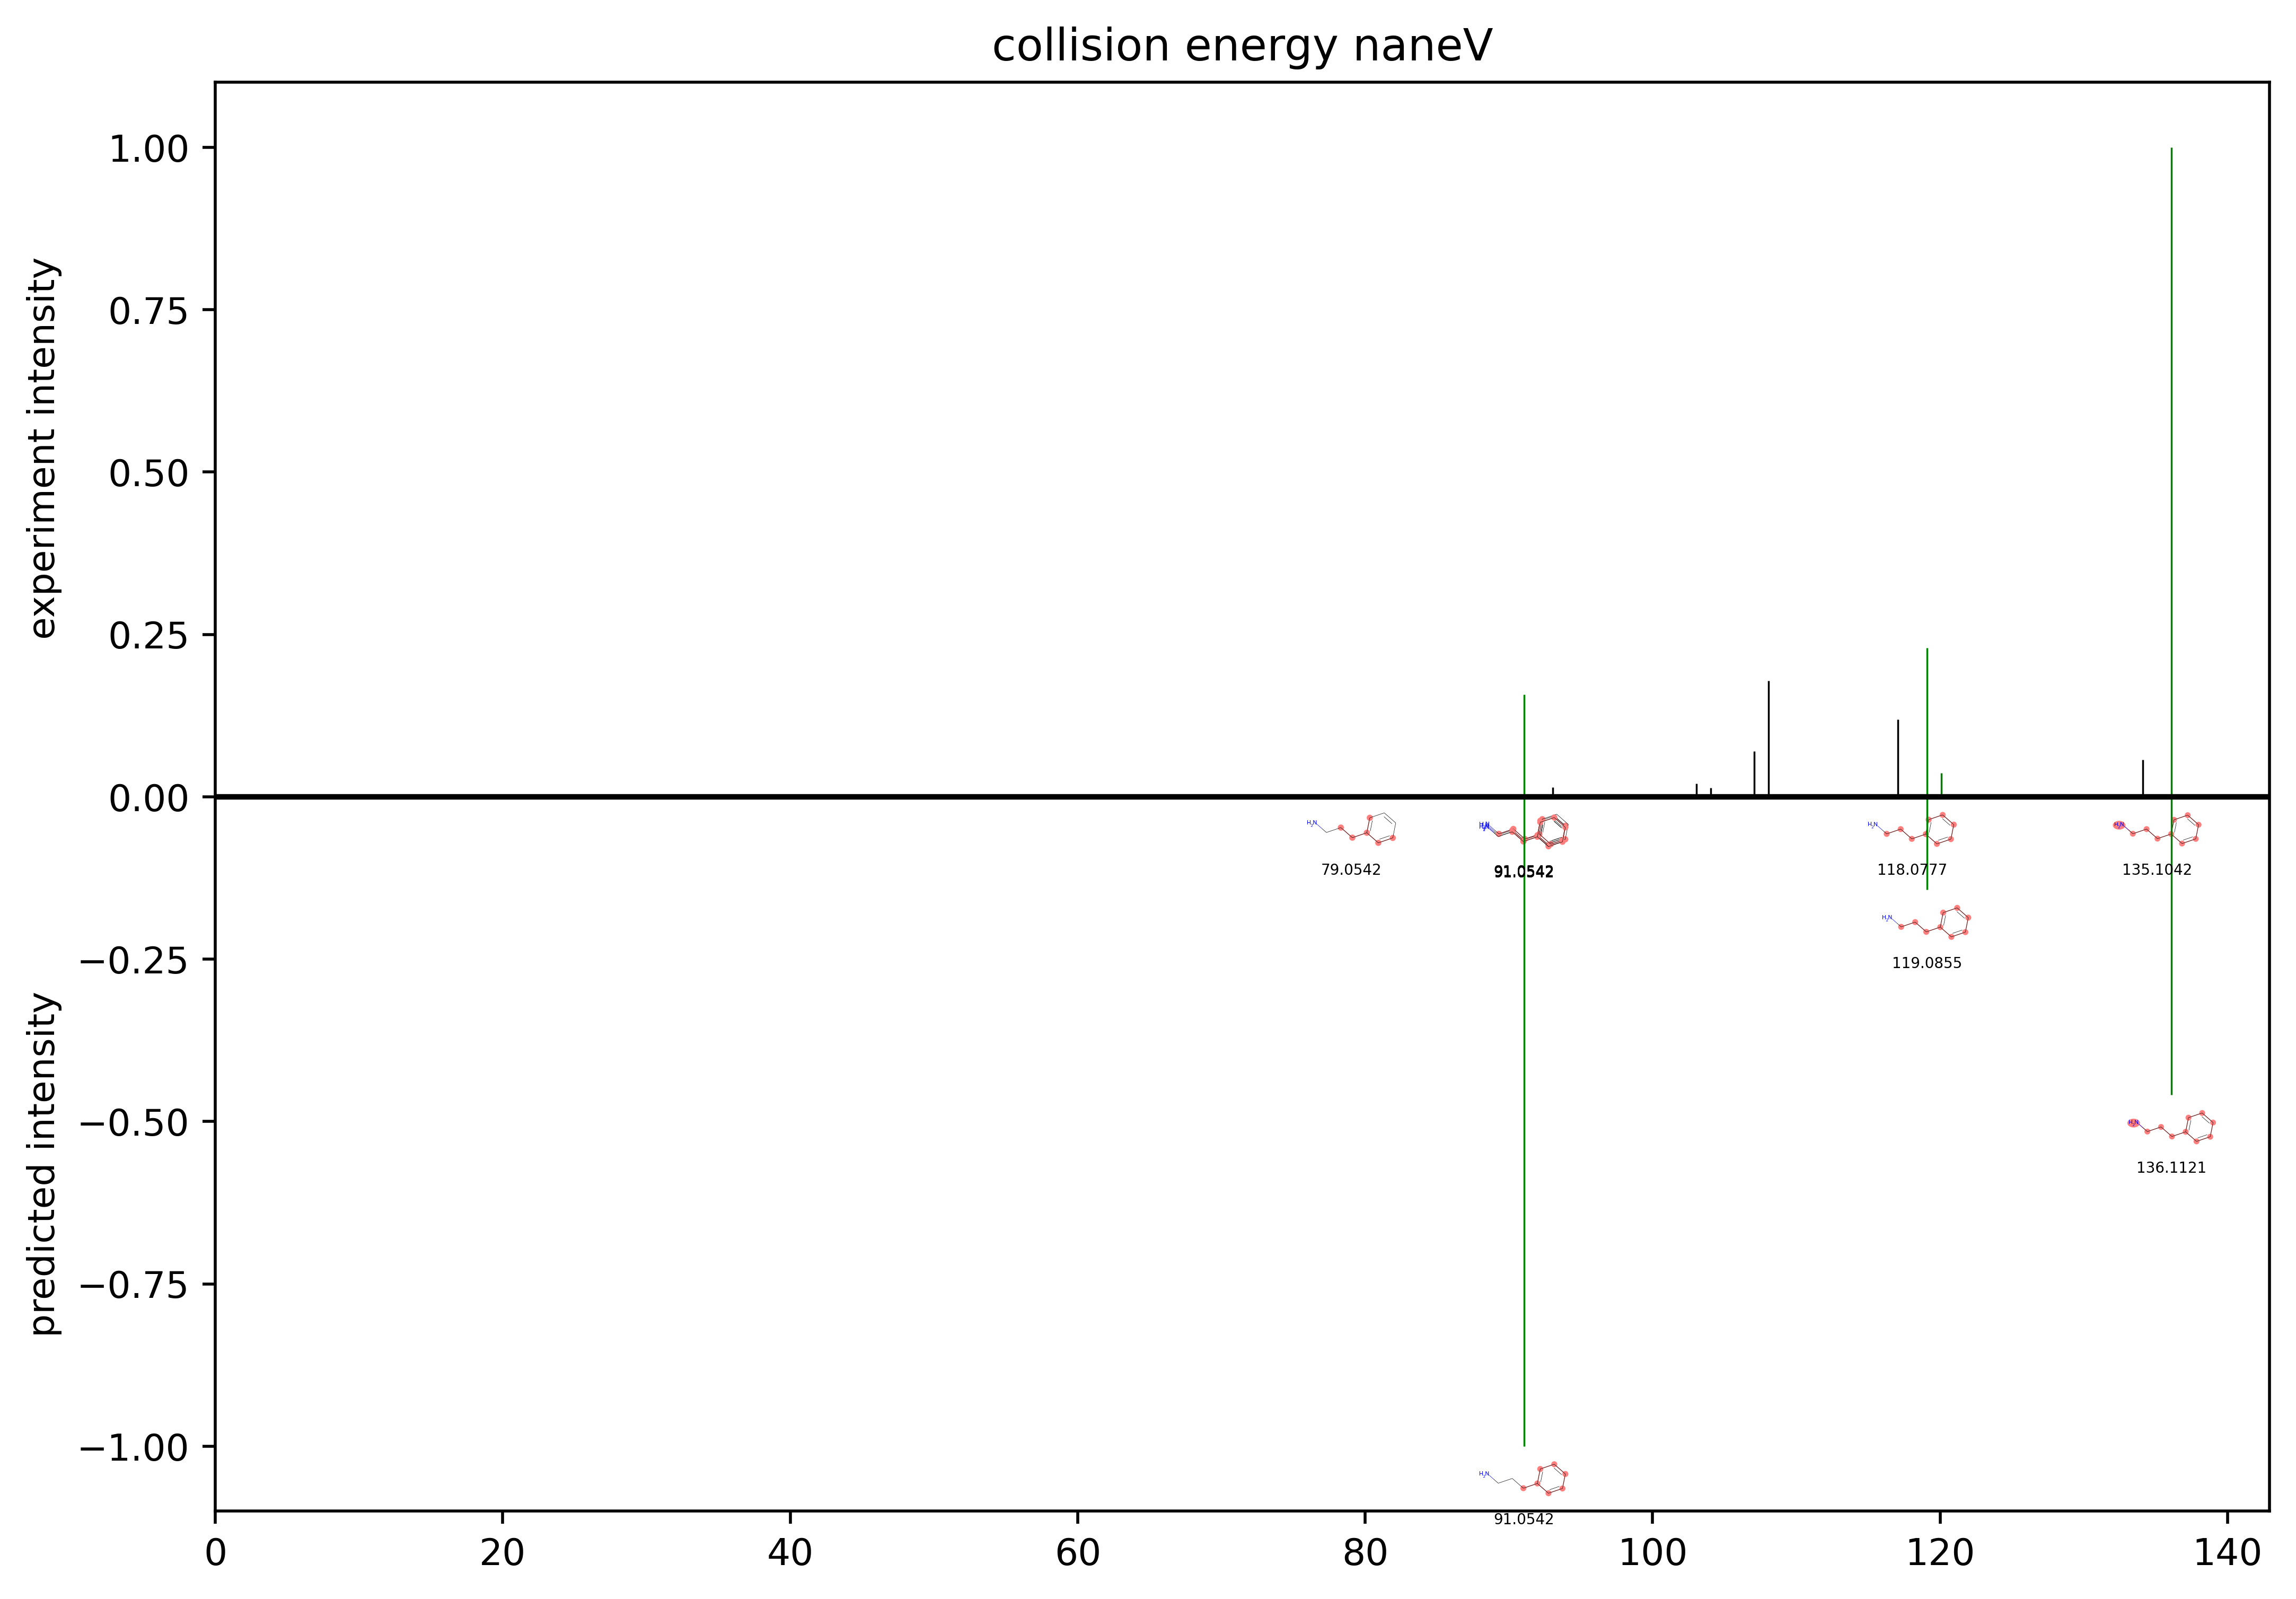

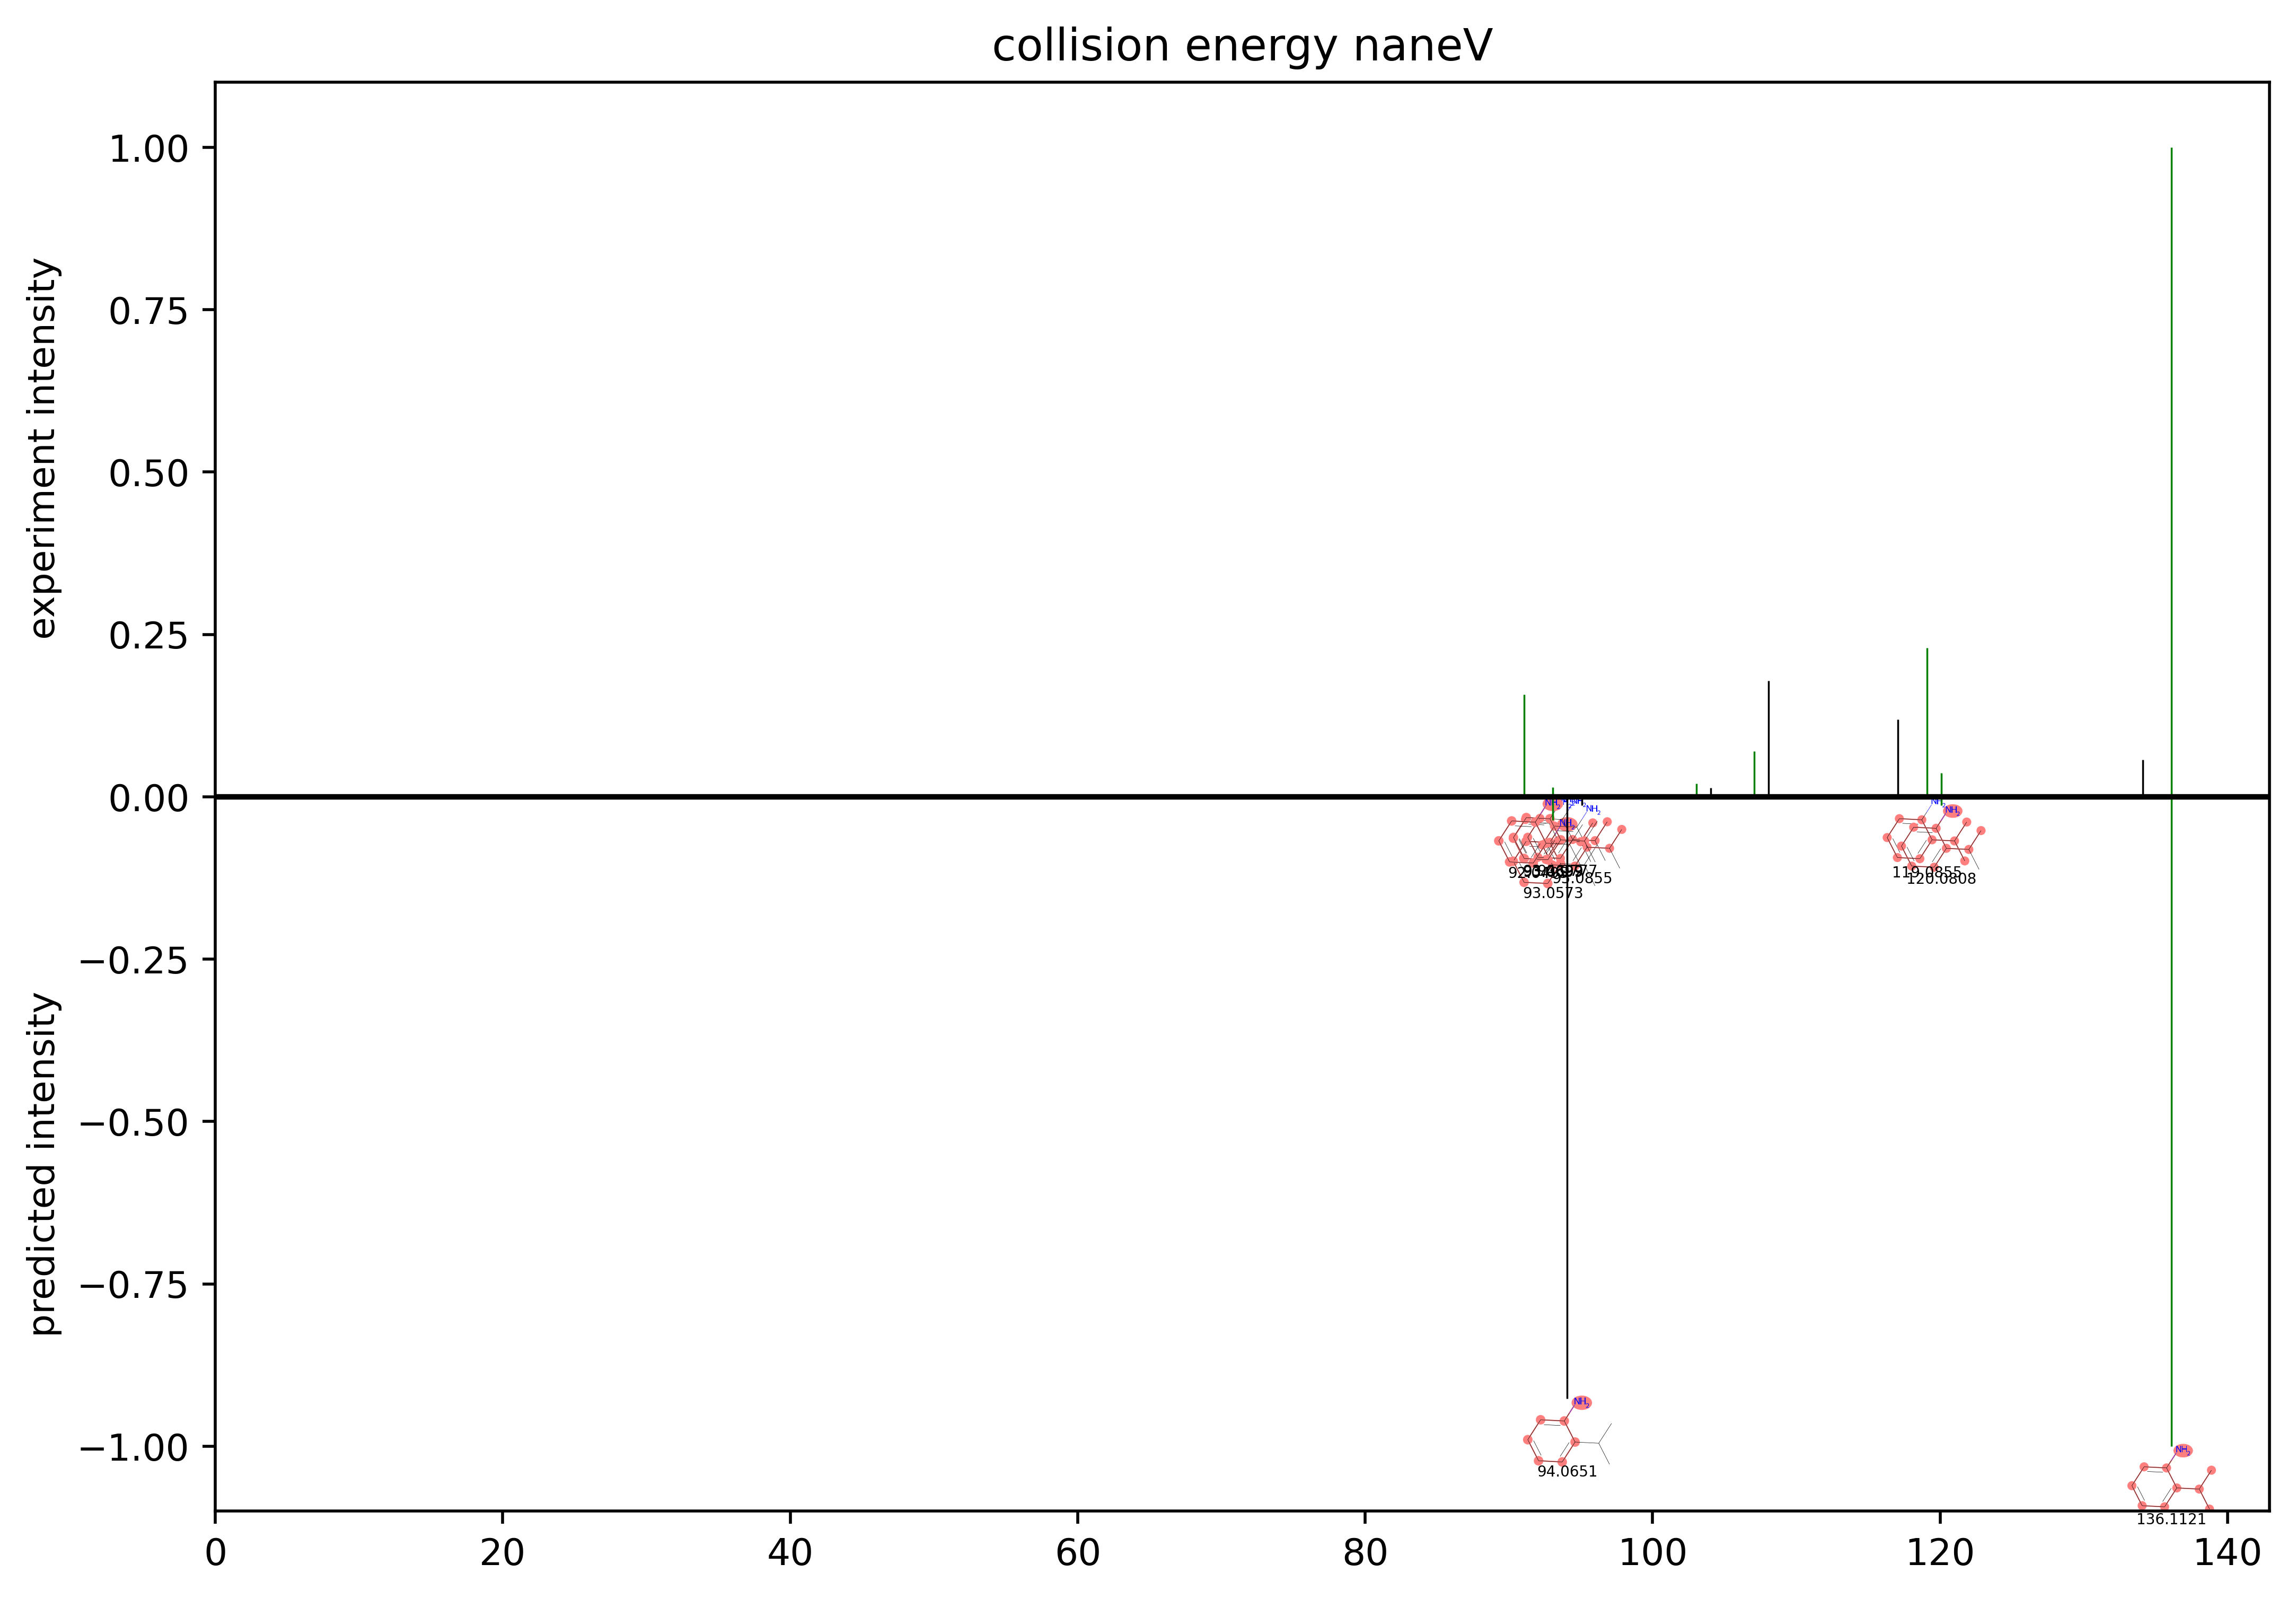

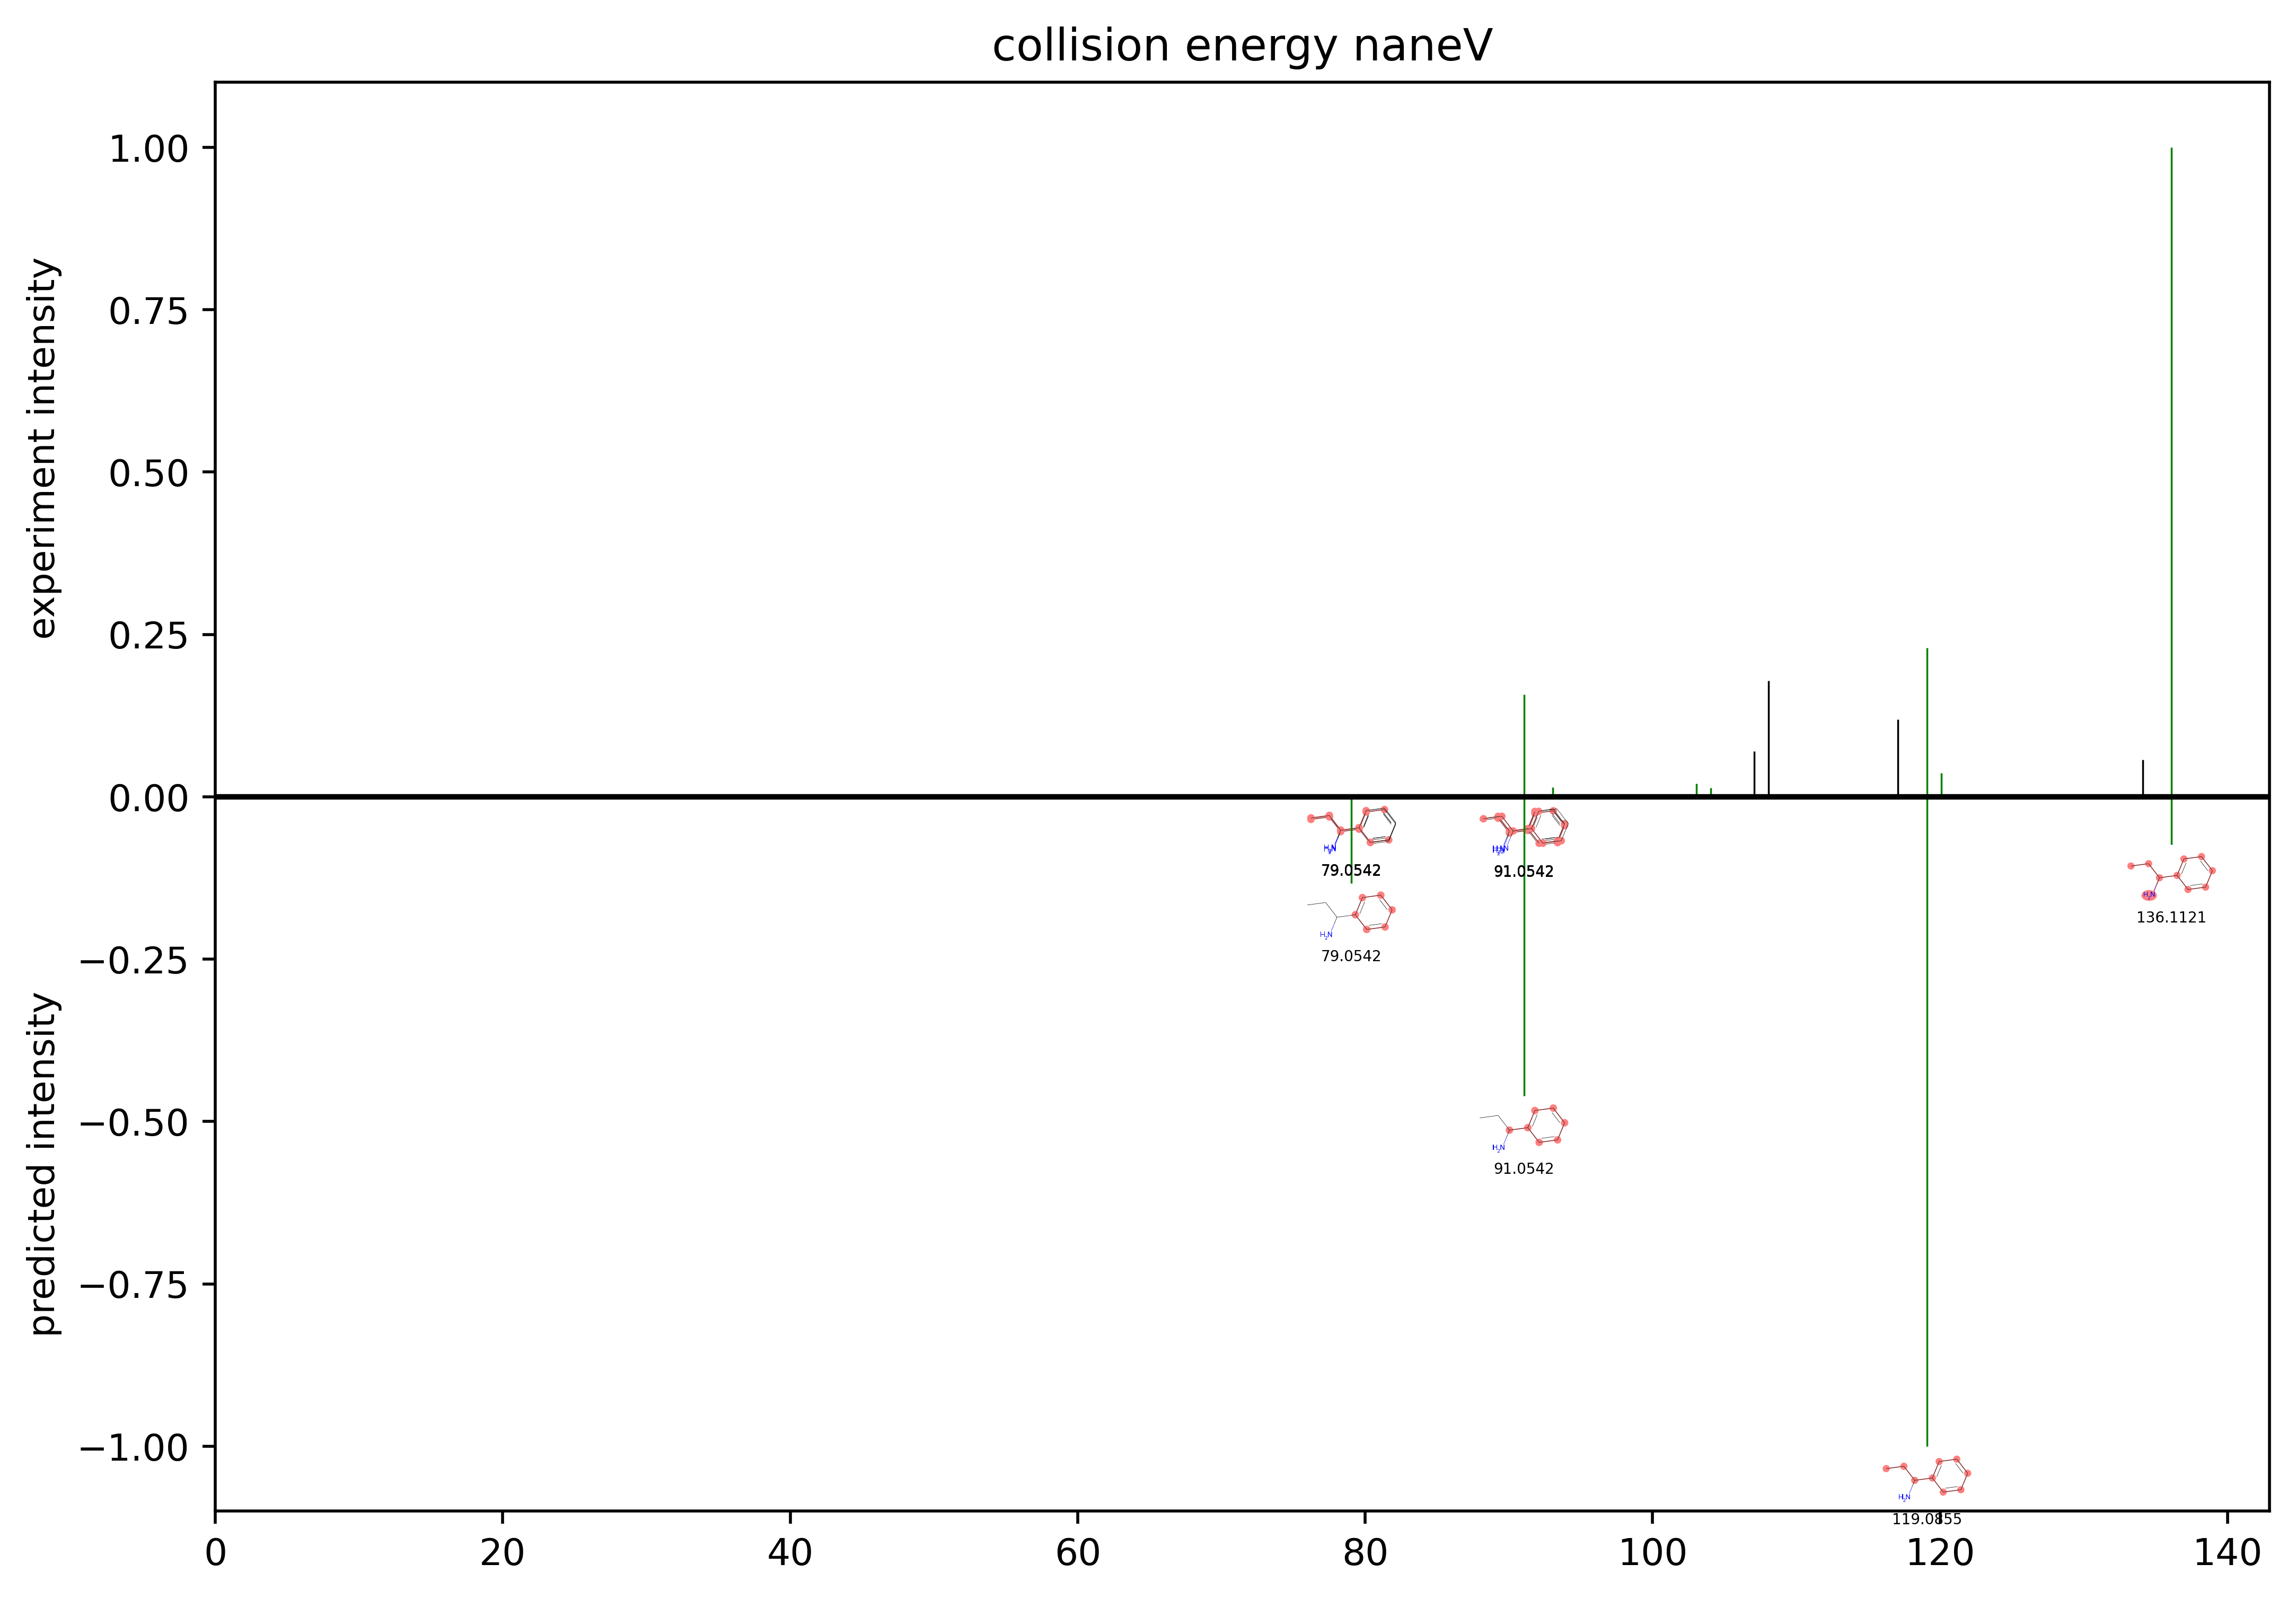

In [191]:
for feature_id in feat_id_to_specs.keys():
    spec = {'nan': feat_id_to_specs[feature_id]}
    img = elucidation(feature_id, spec, '[M+H]+', starting_cmpds, vis_peaks=True, energy=[30, 45, 60])
    print(f'RT={feature_id_to_rt[feature_id]} sec')
    display(img)

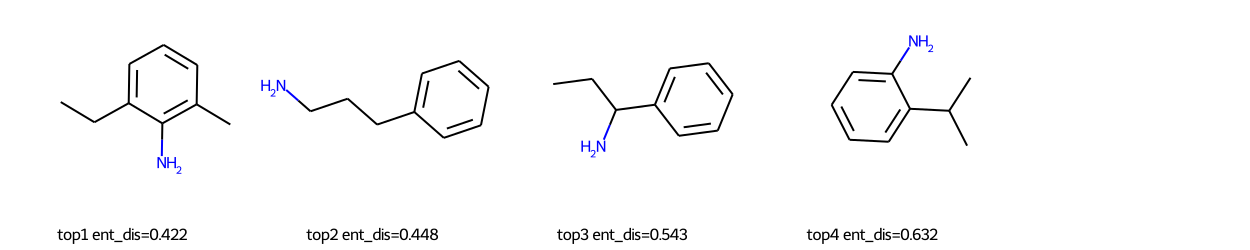

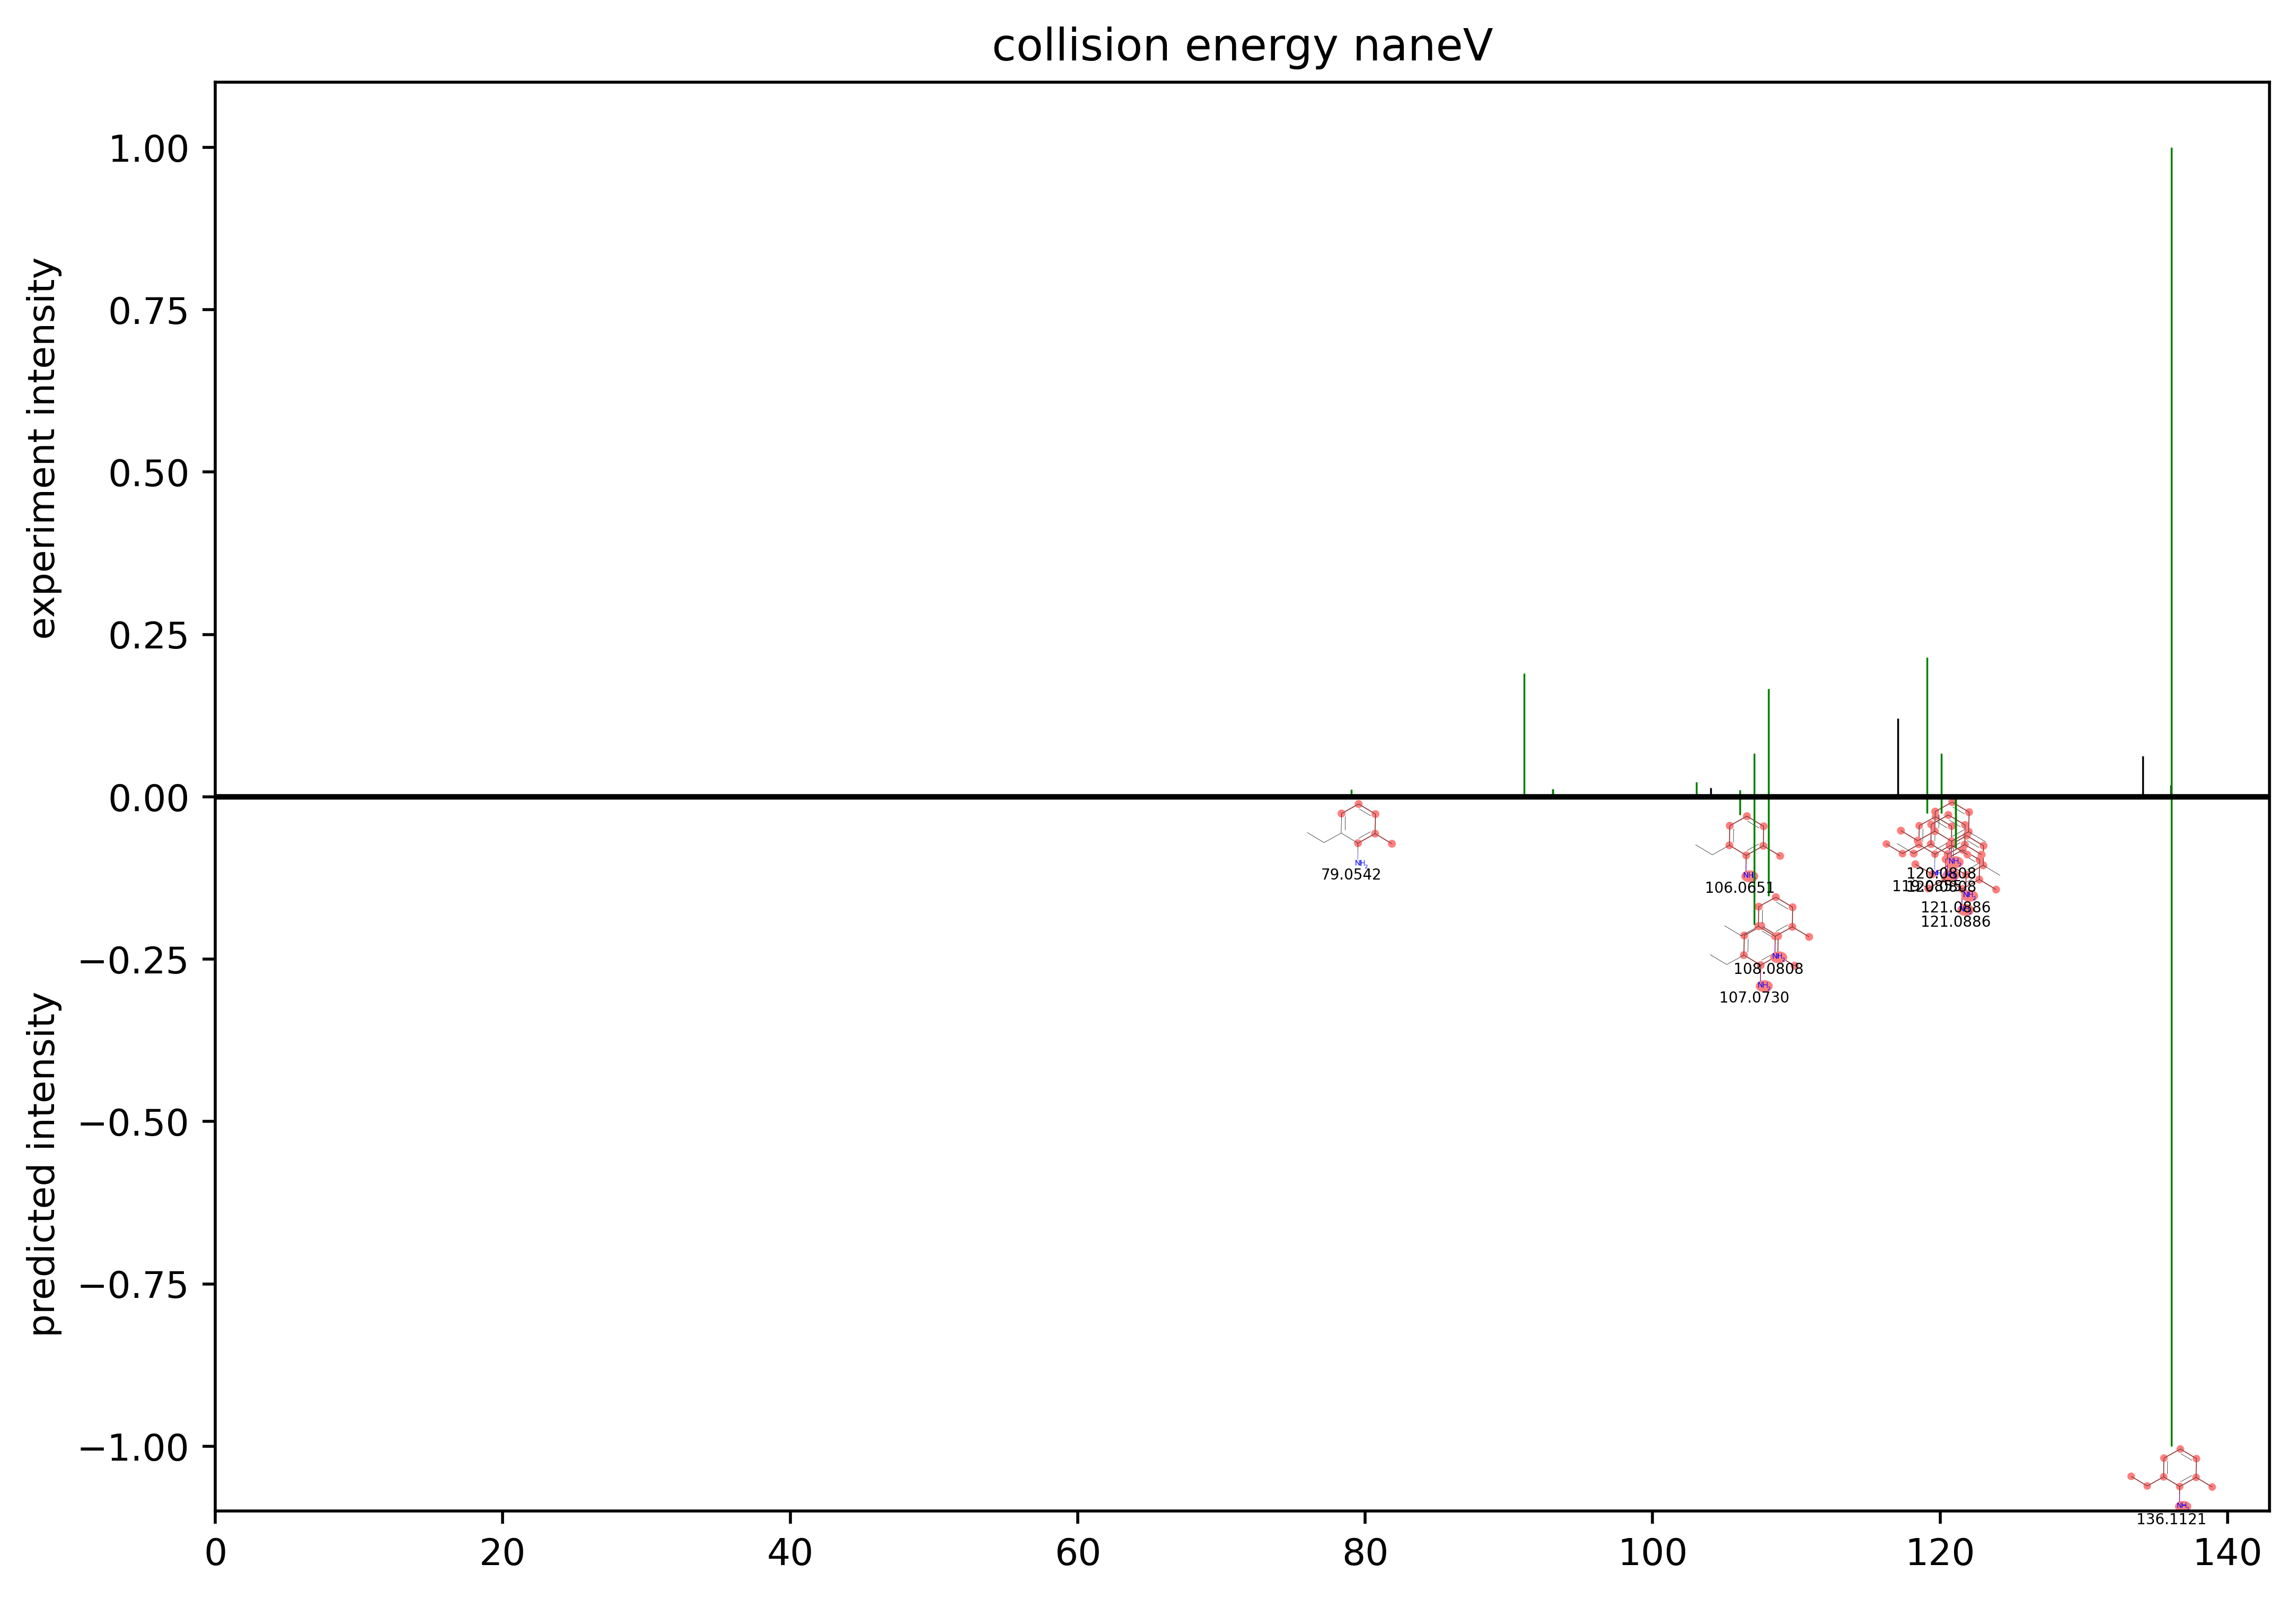

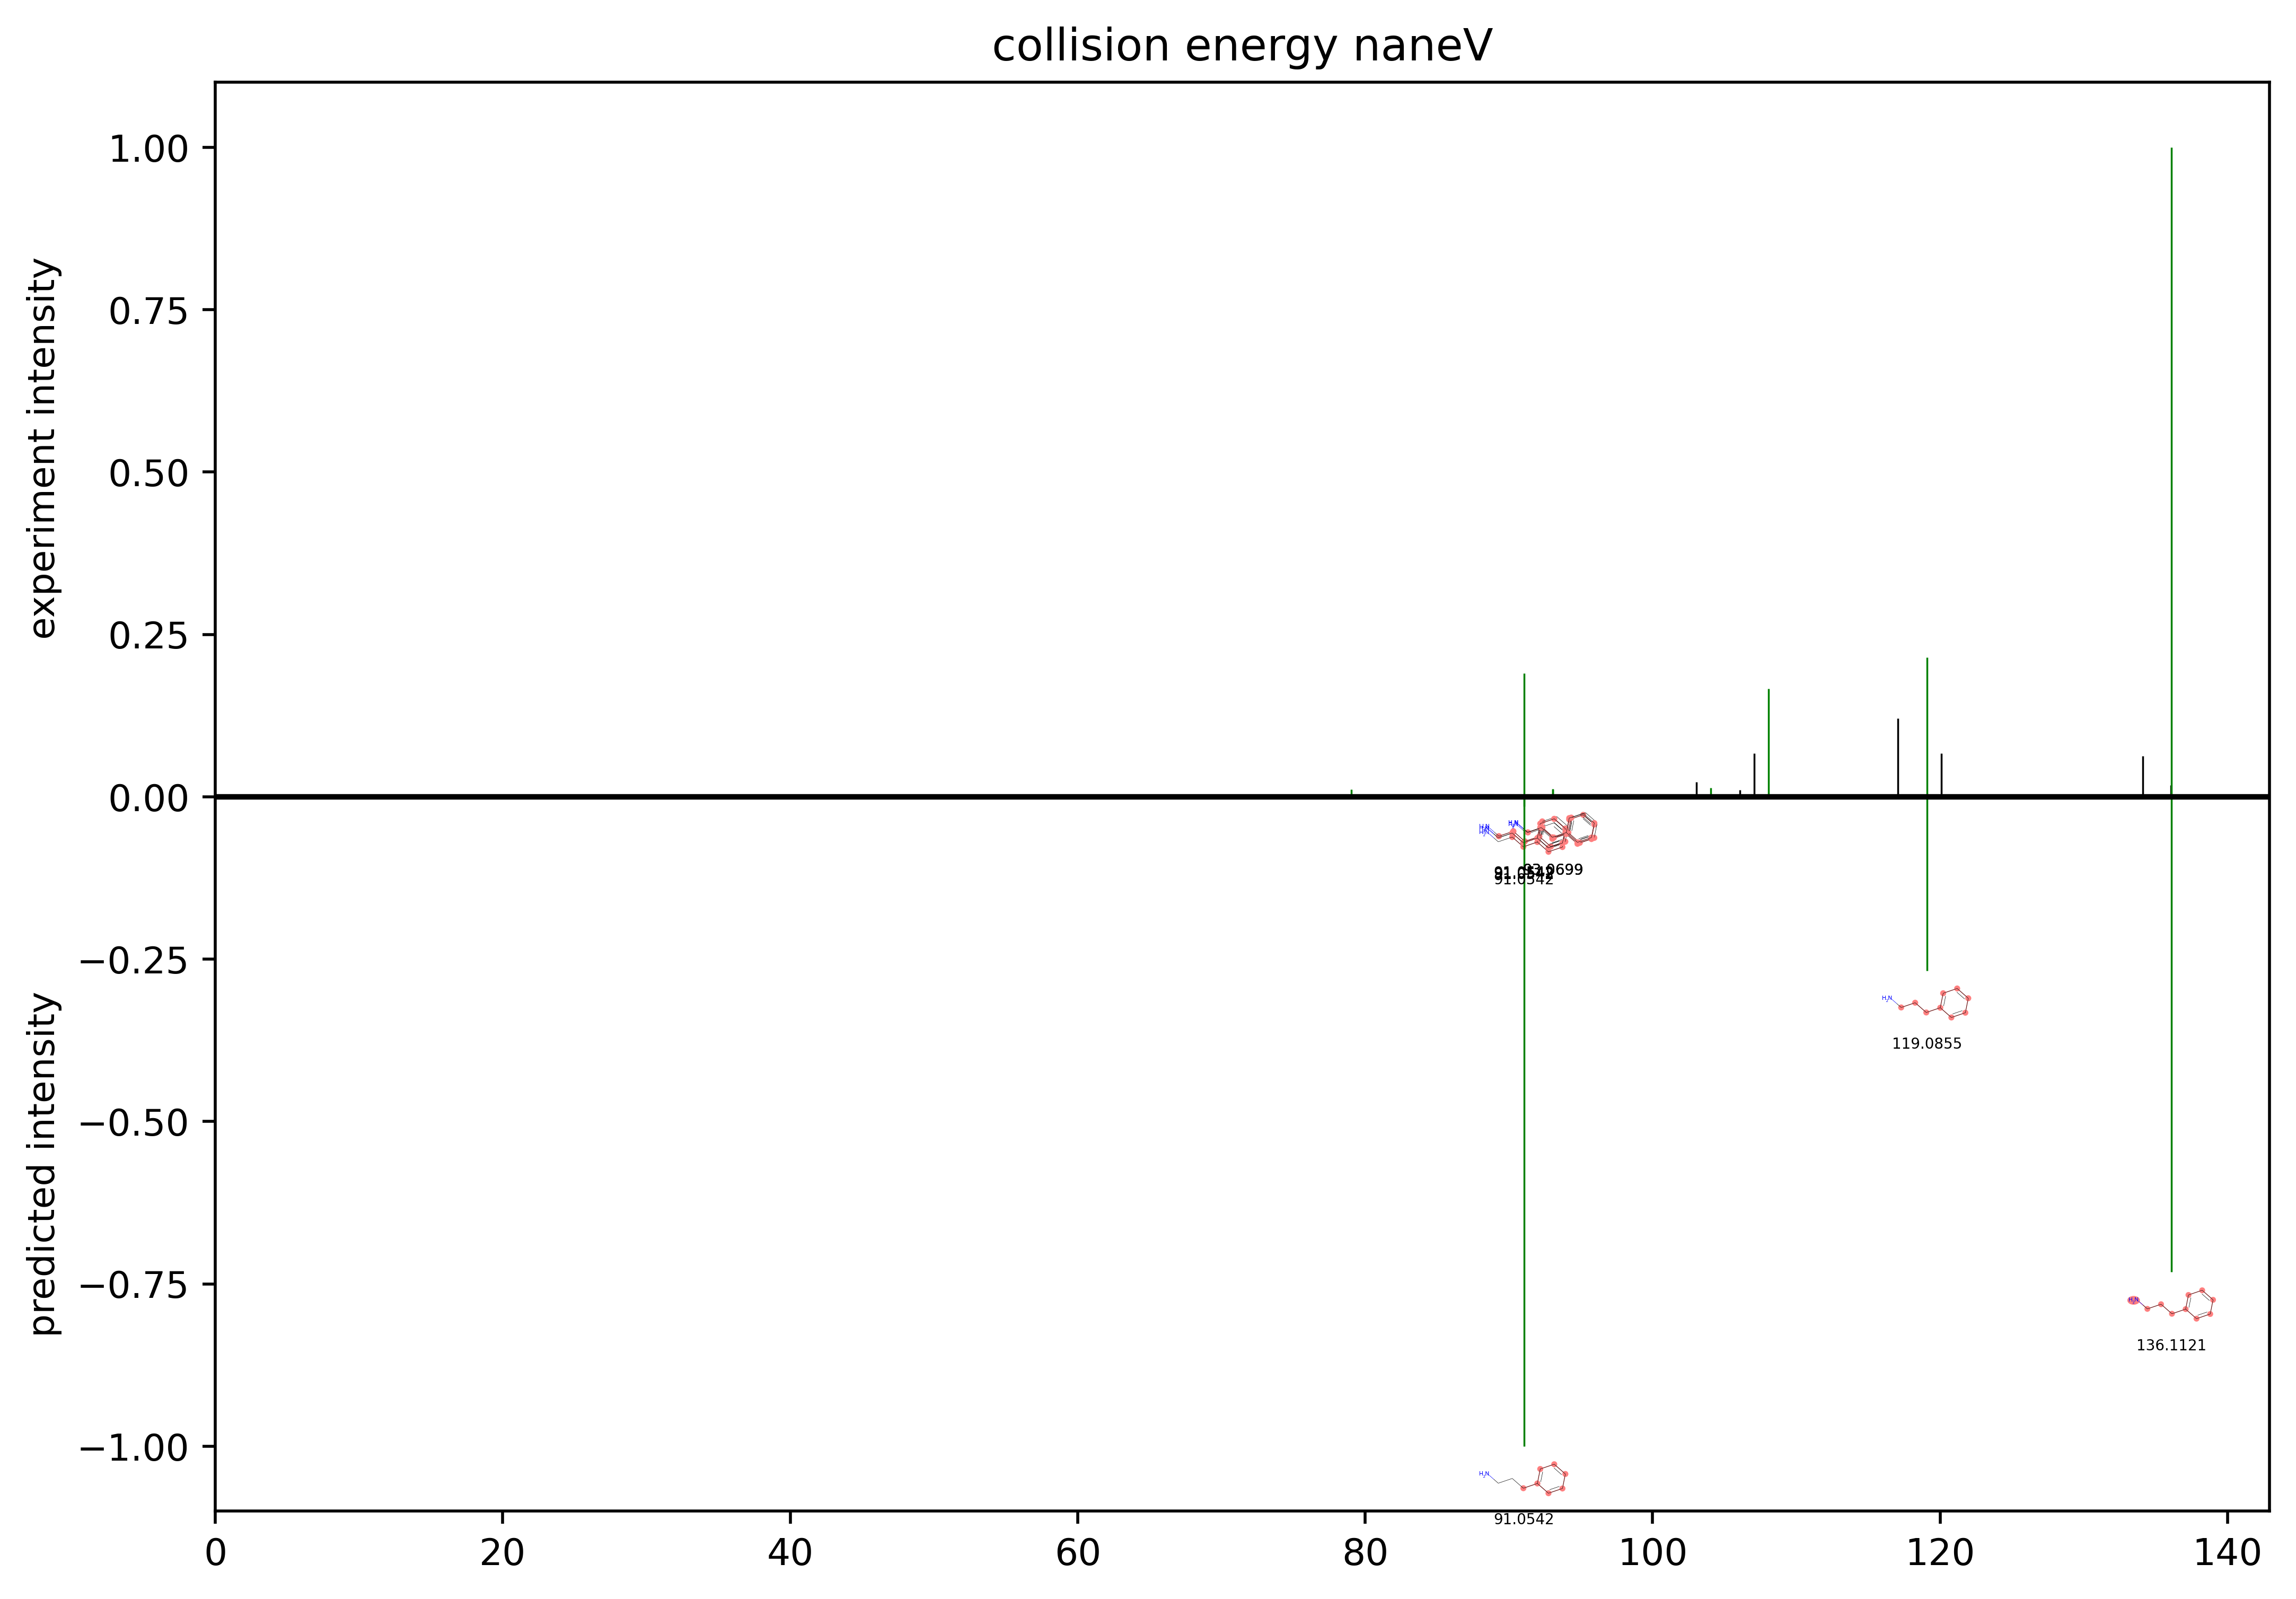

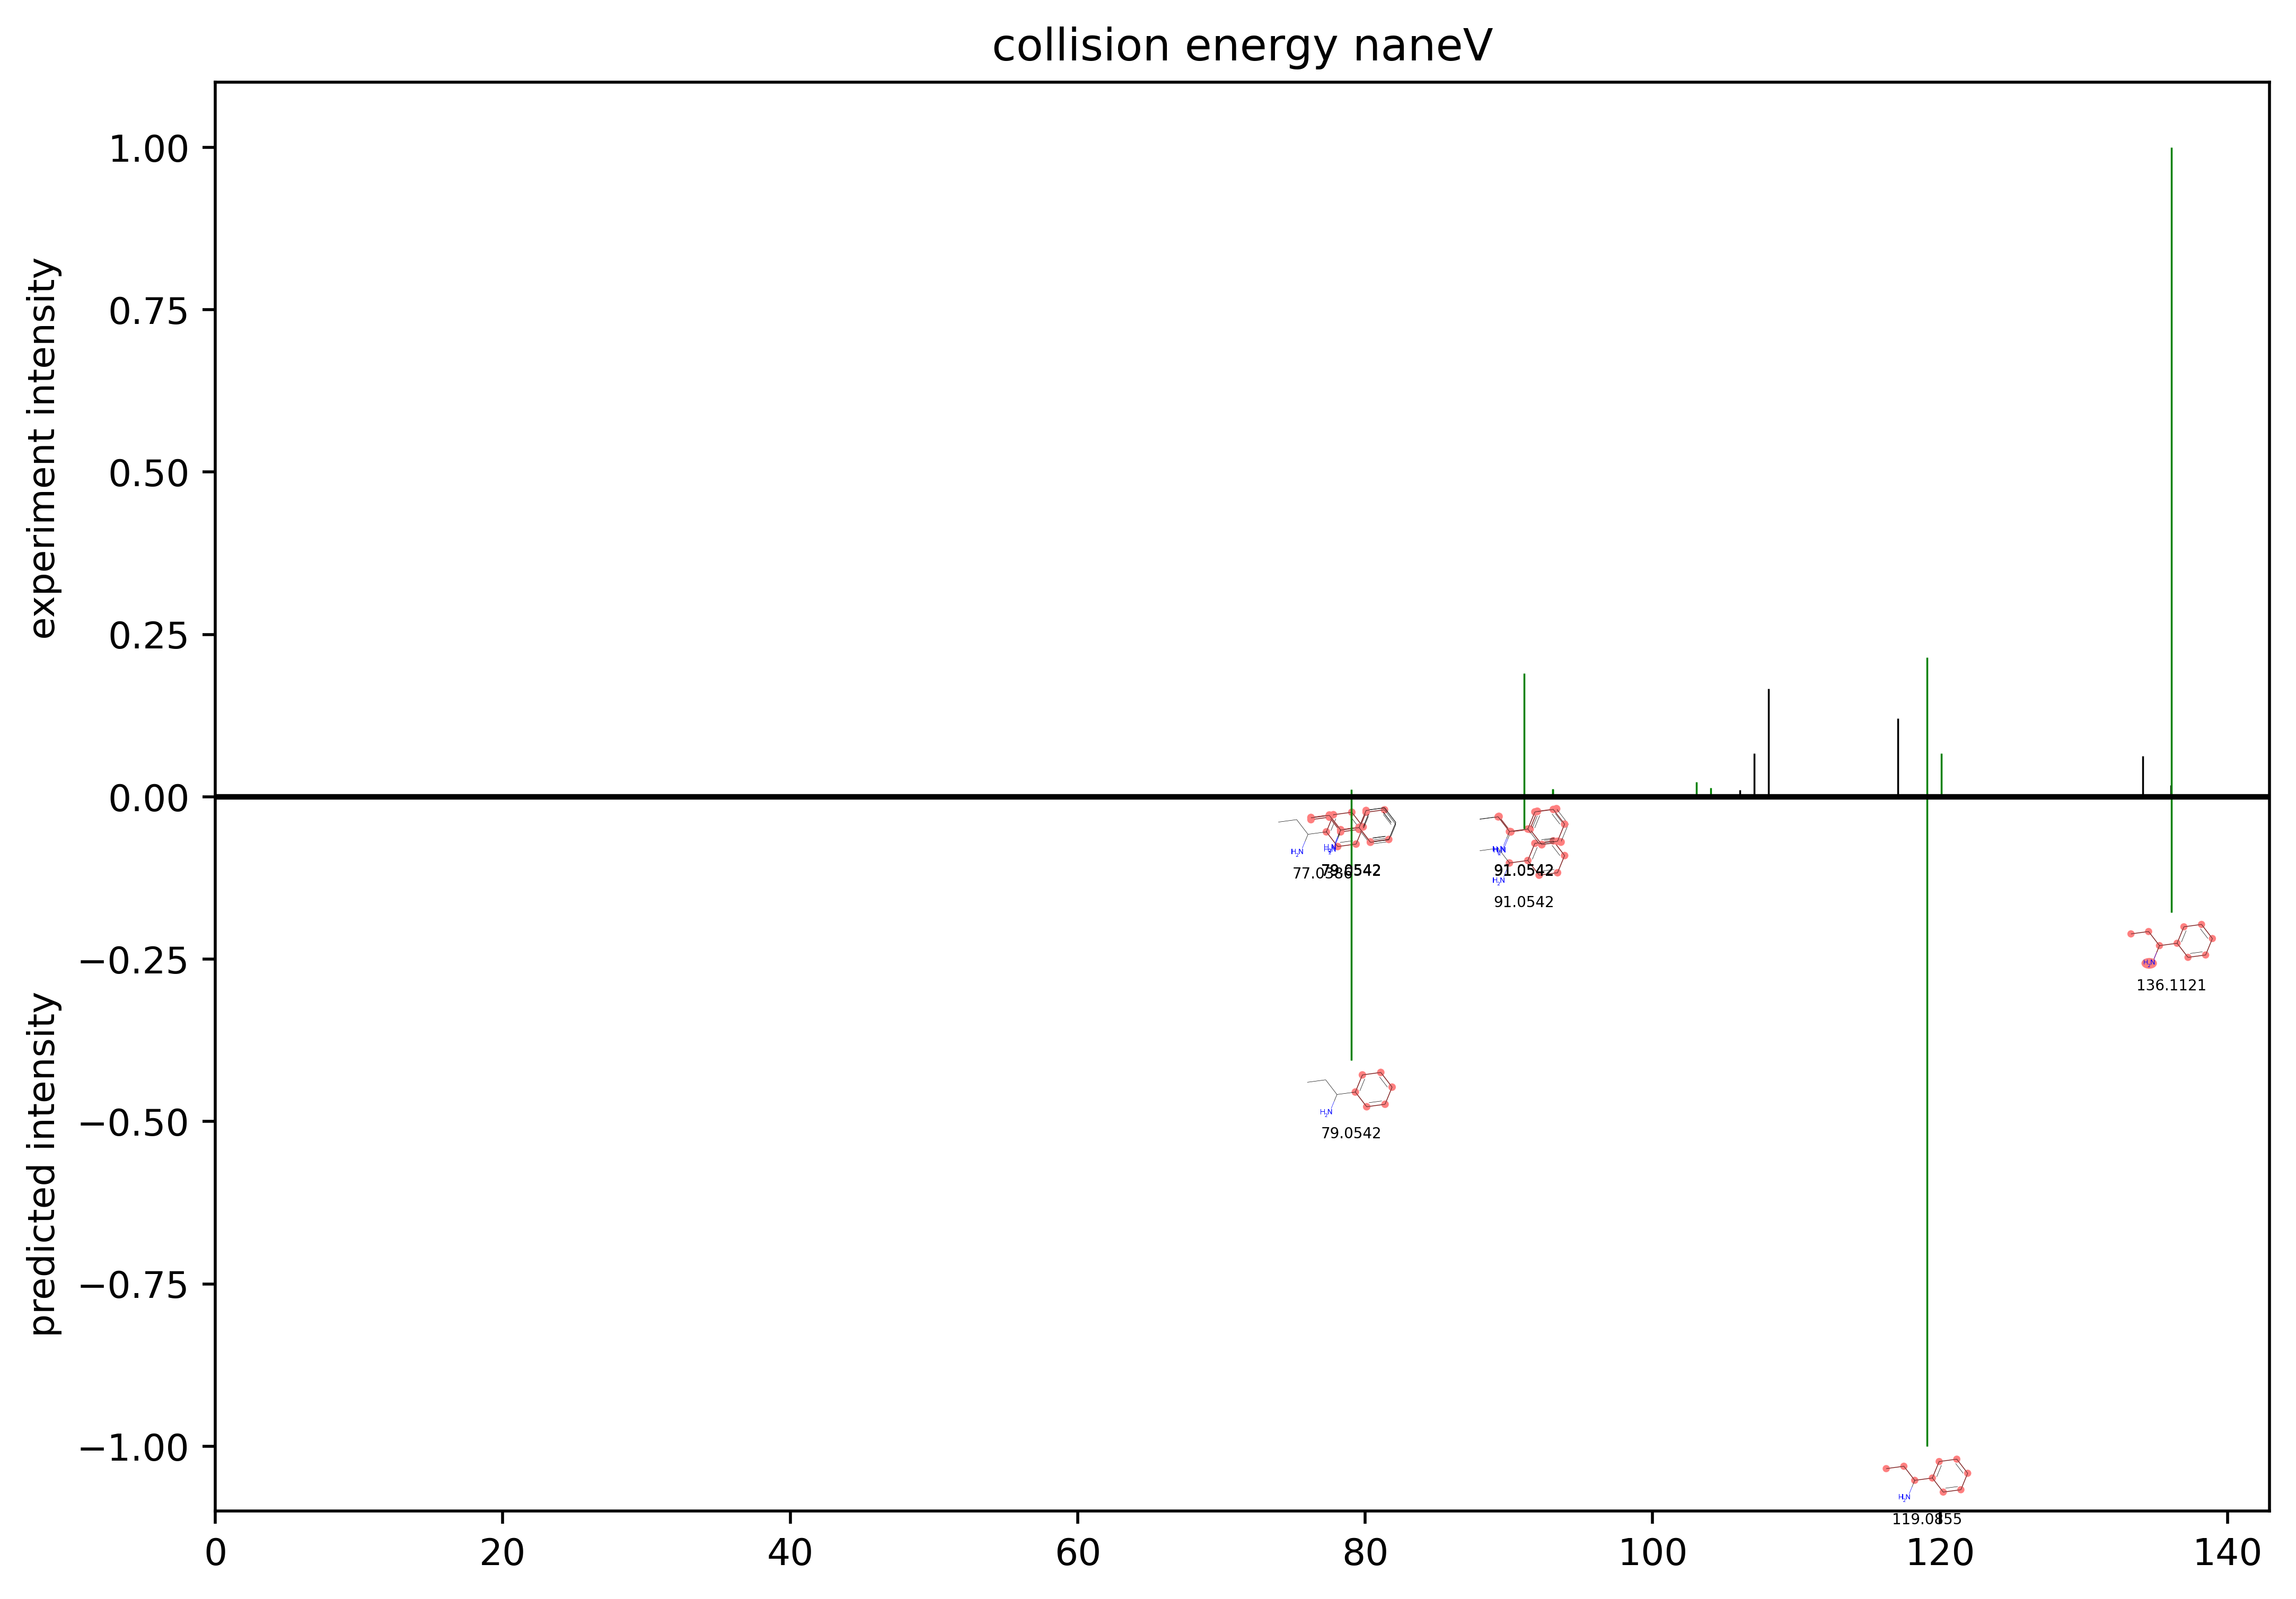

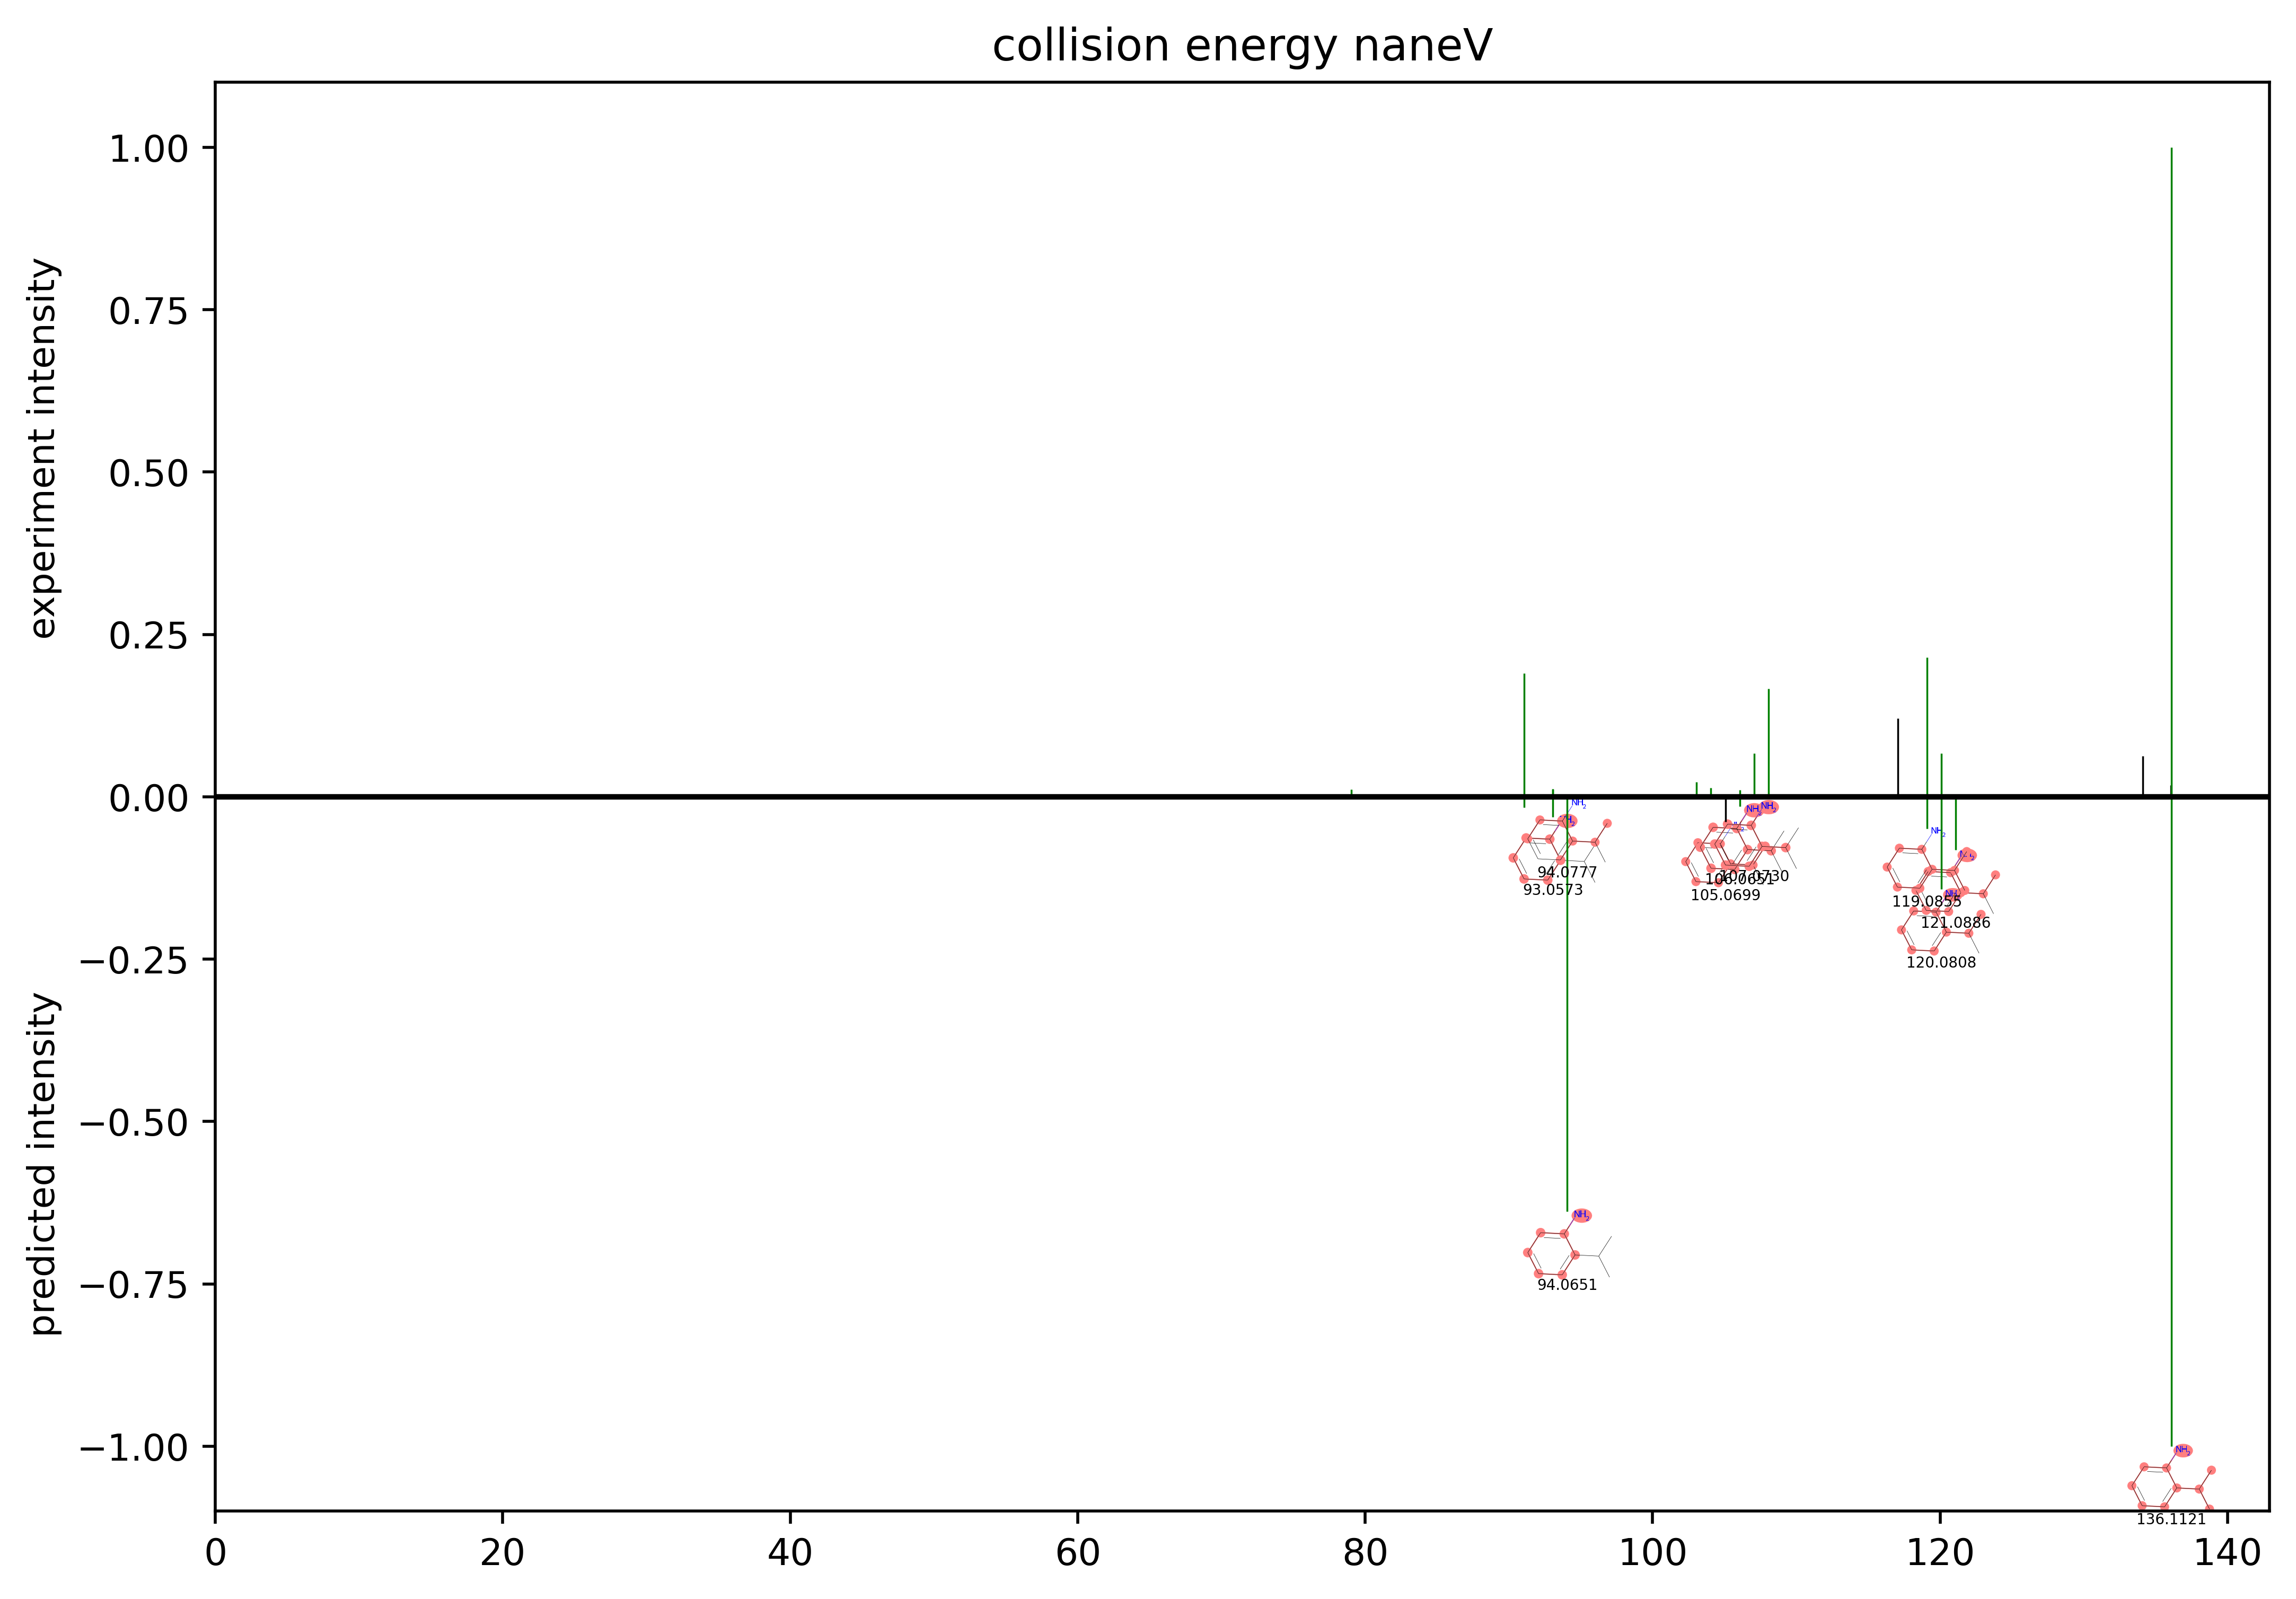

In [40]:
feature_id = '694'
spec = {'nan': feat_id_to_specs[feature_id]}
elucidation(feature_id, spec, '[M+H]+', all_smiles, vis_peaks=True, energy=[20, 40, 60])

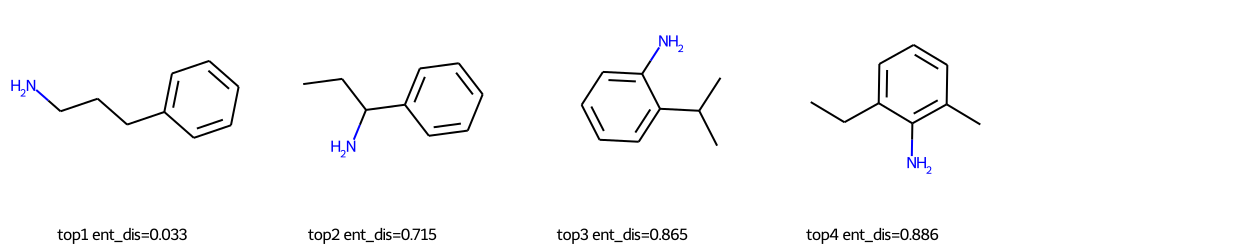

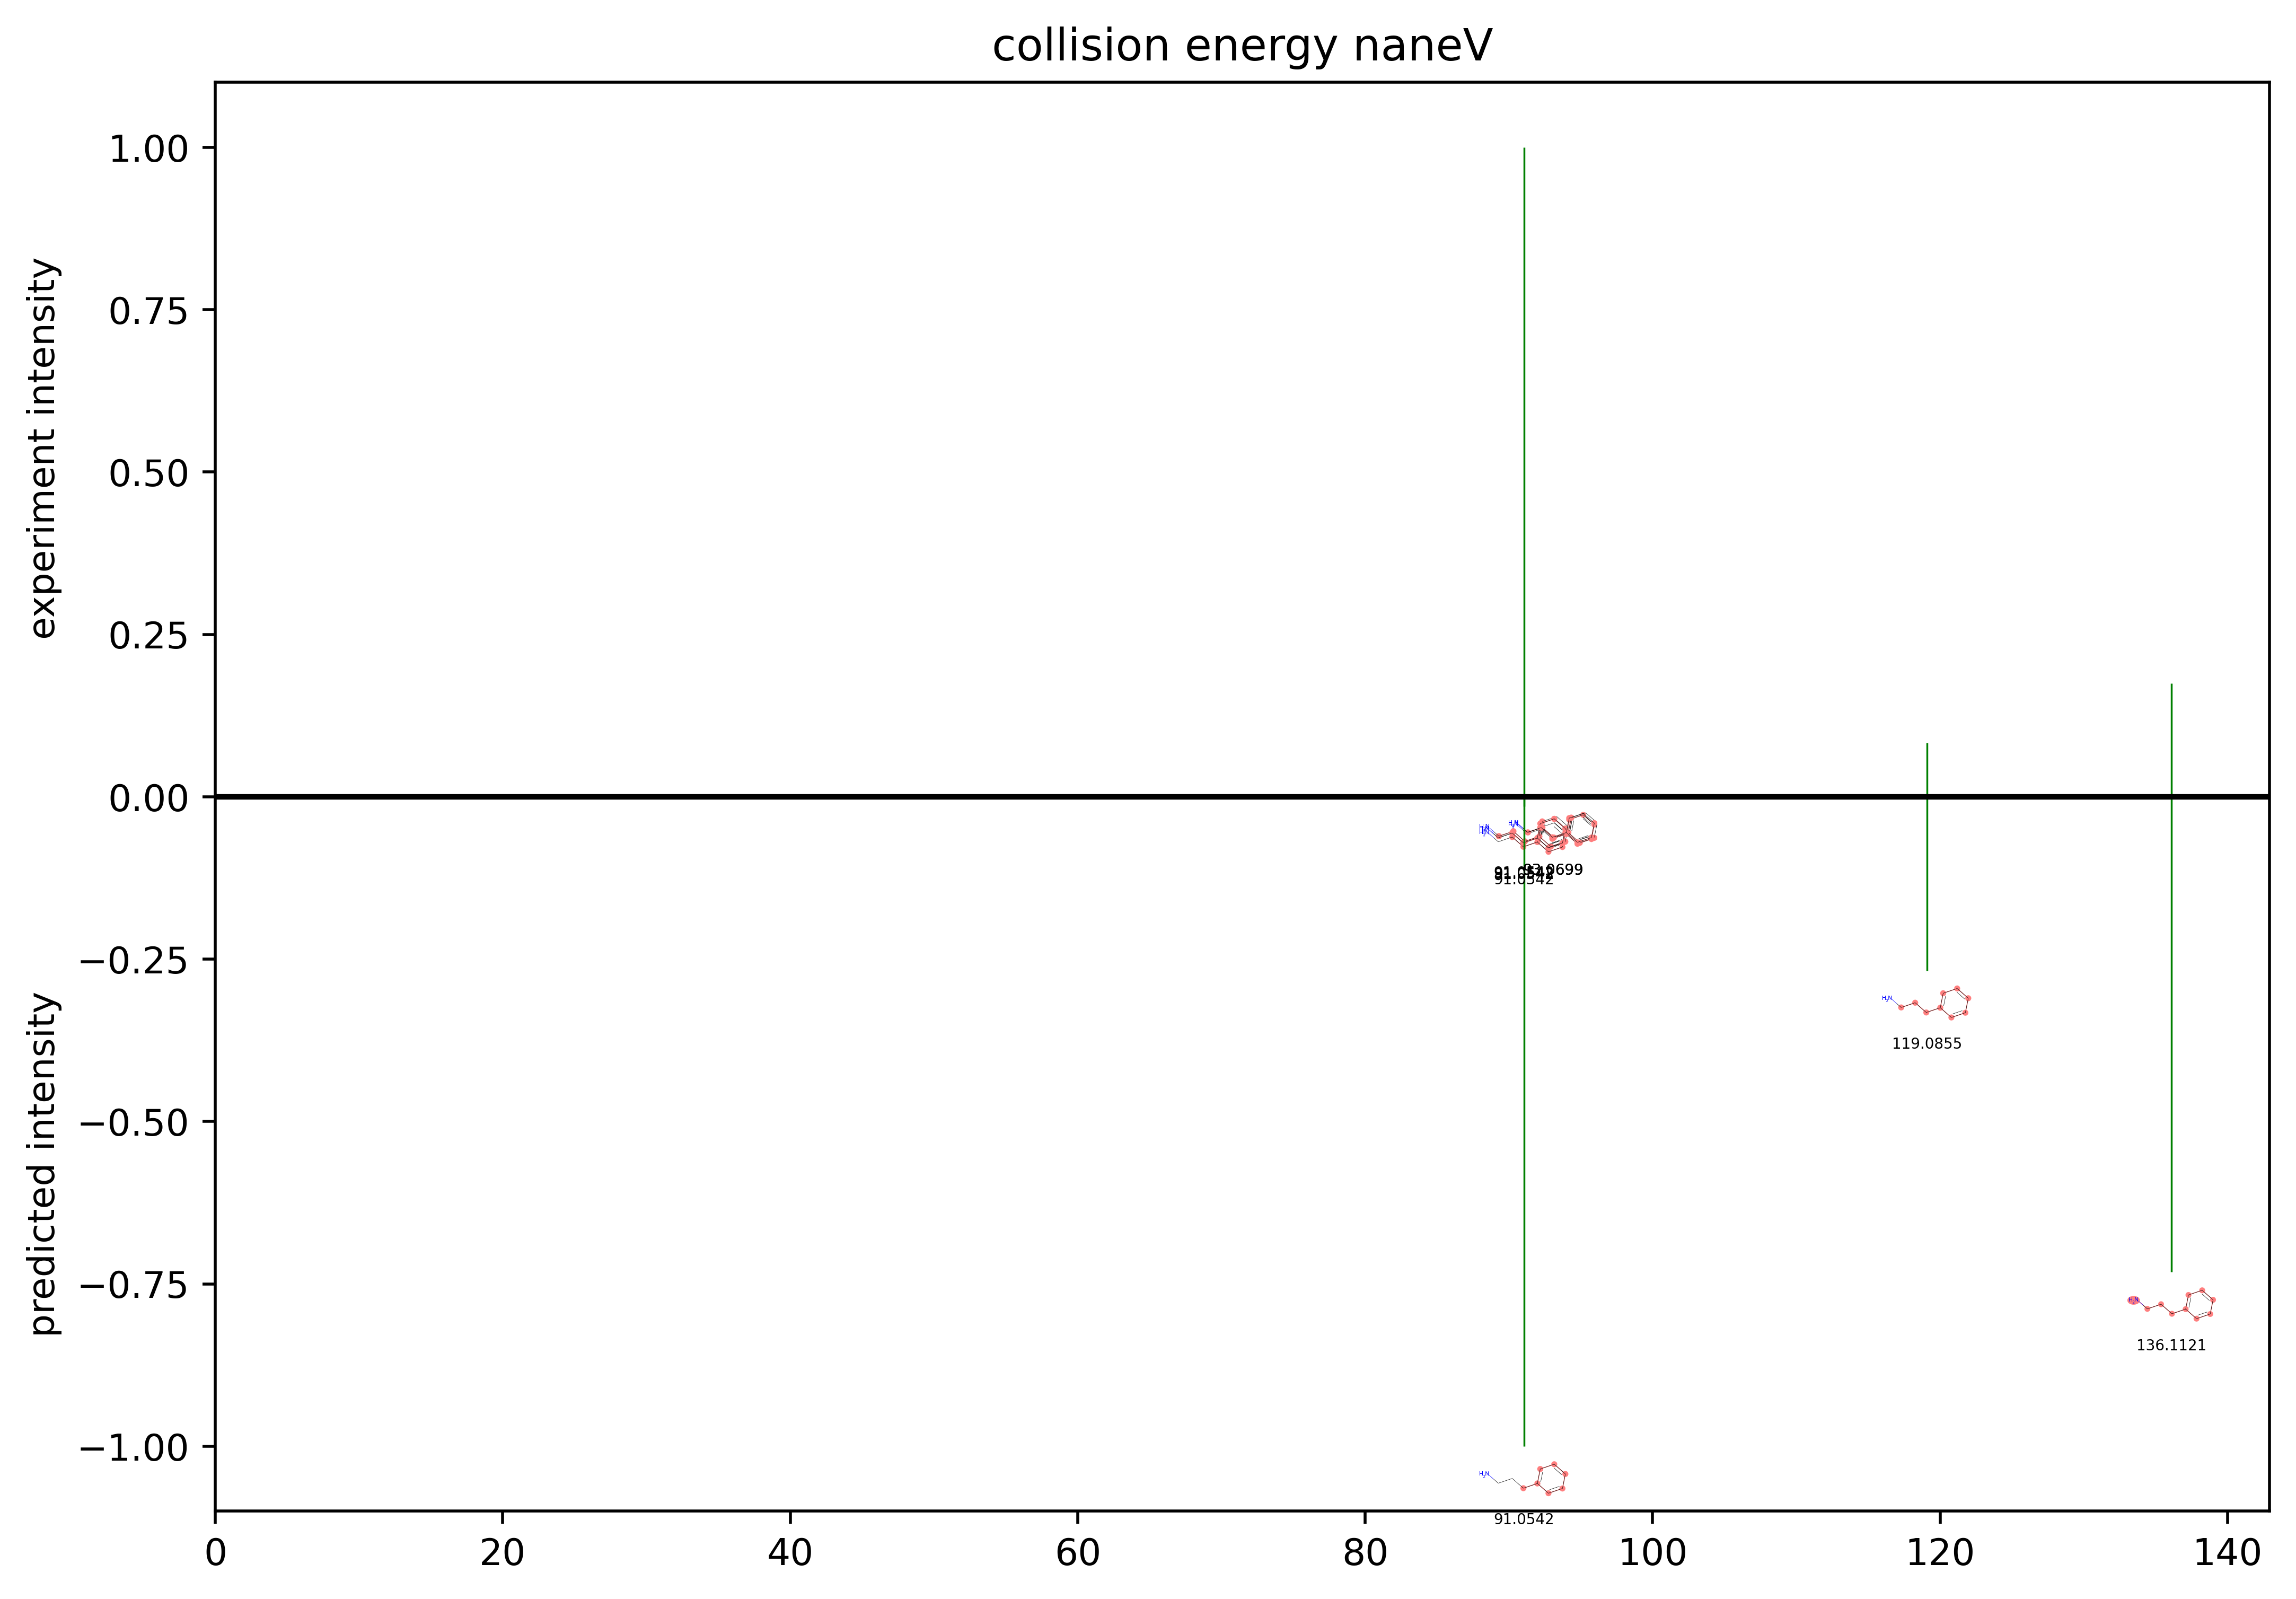

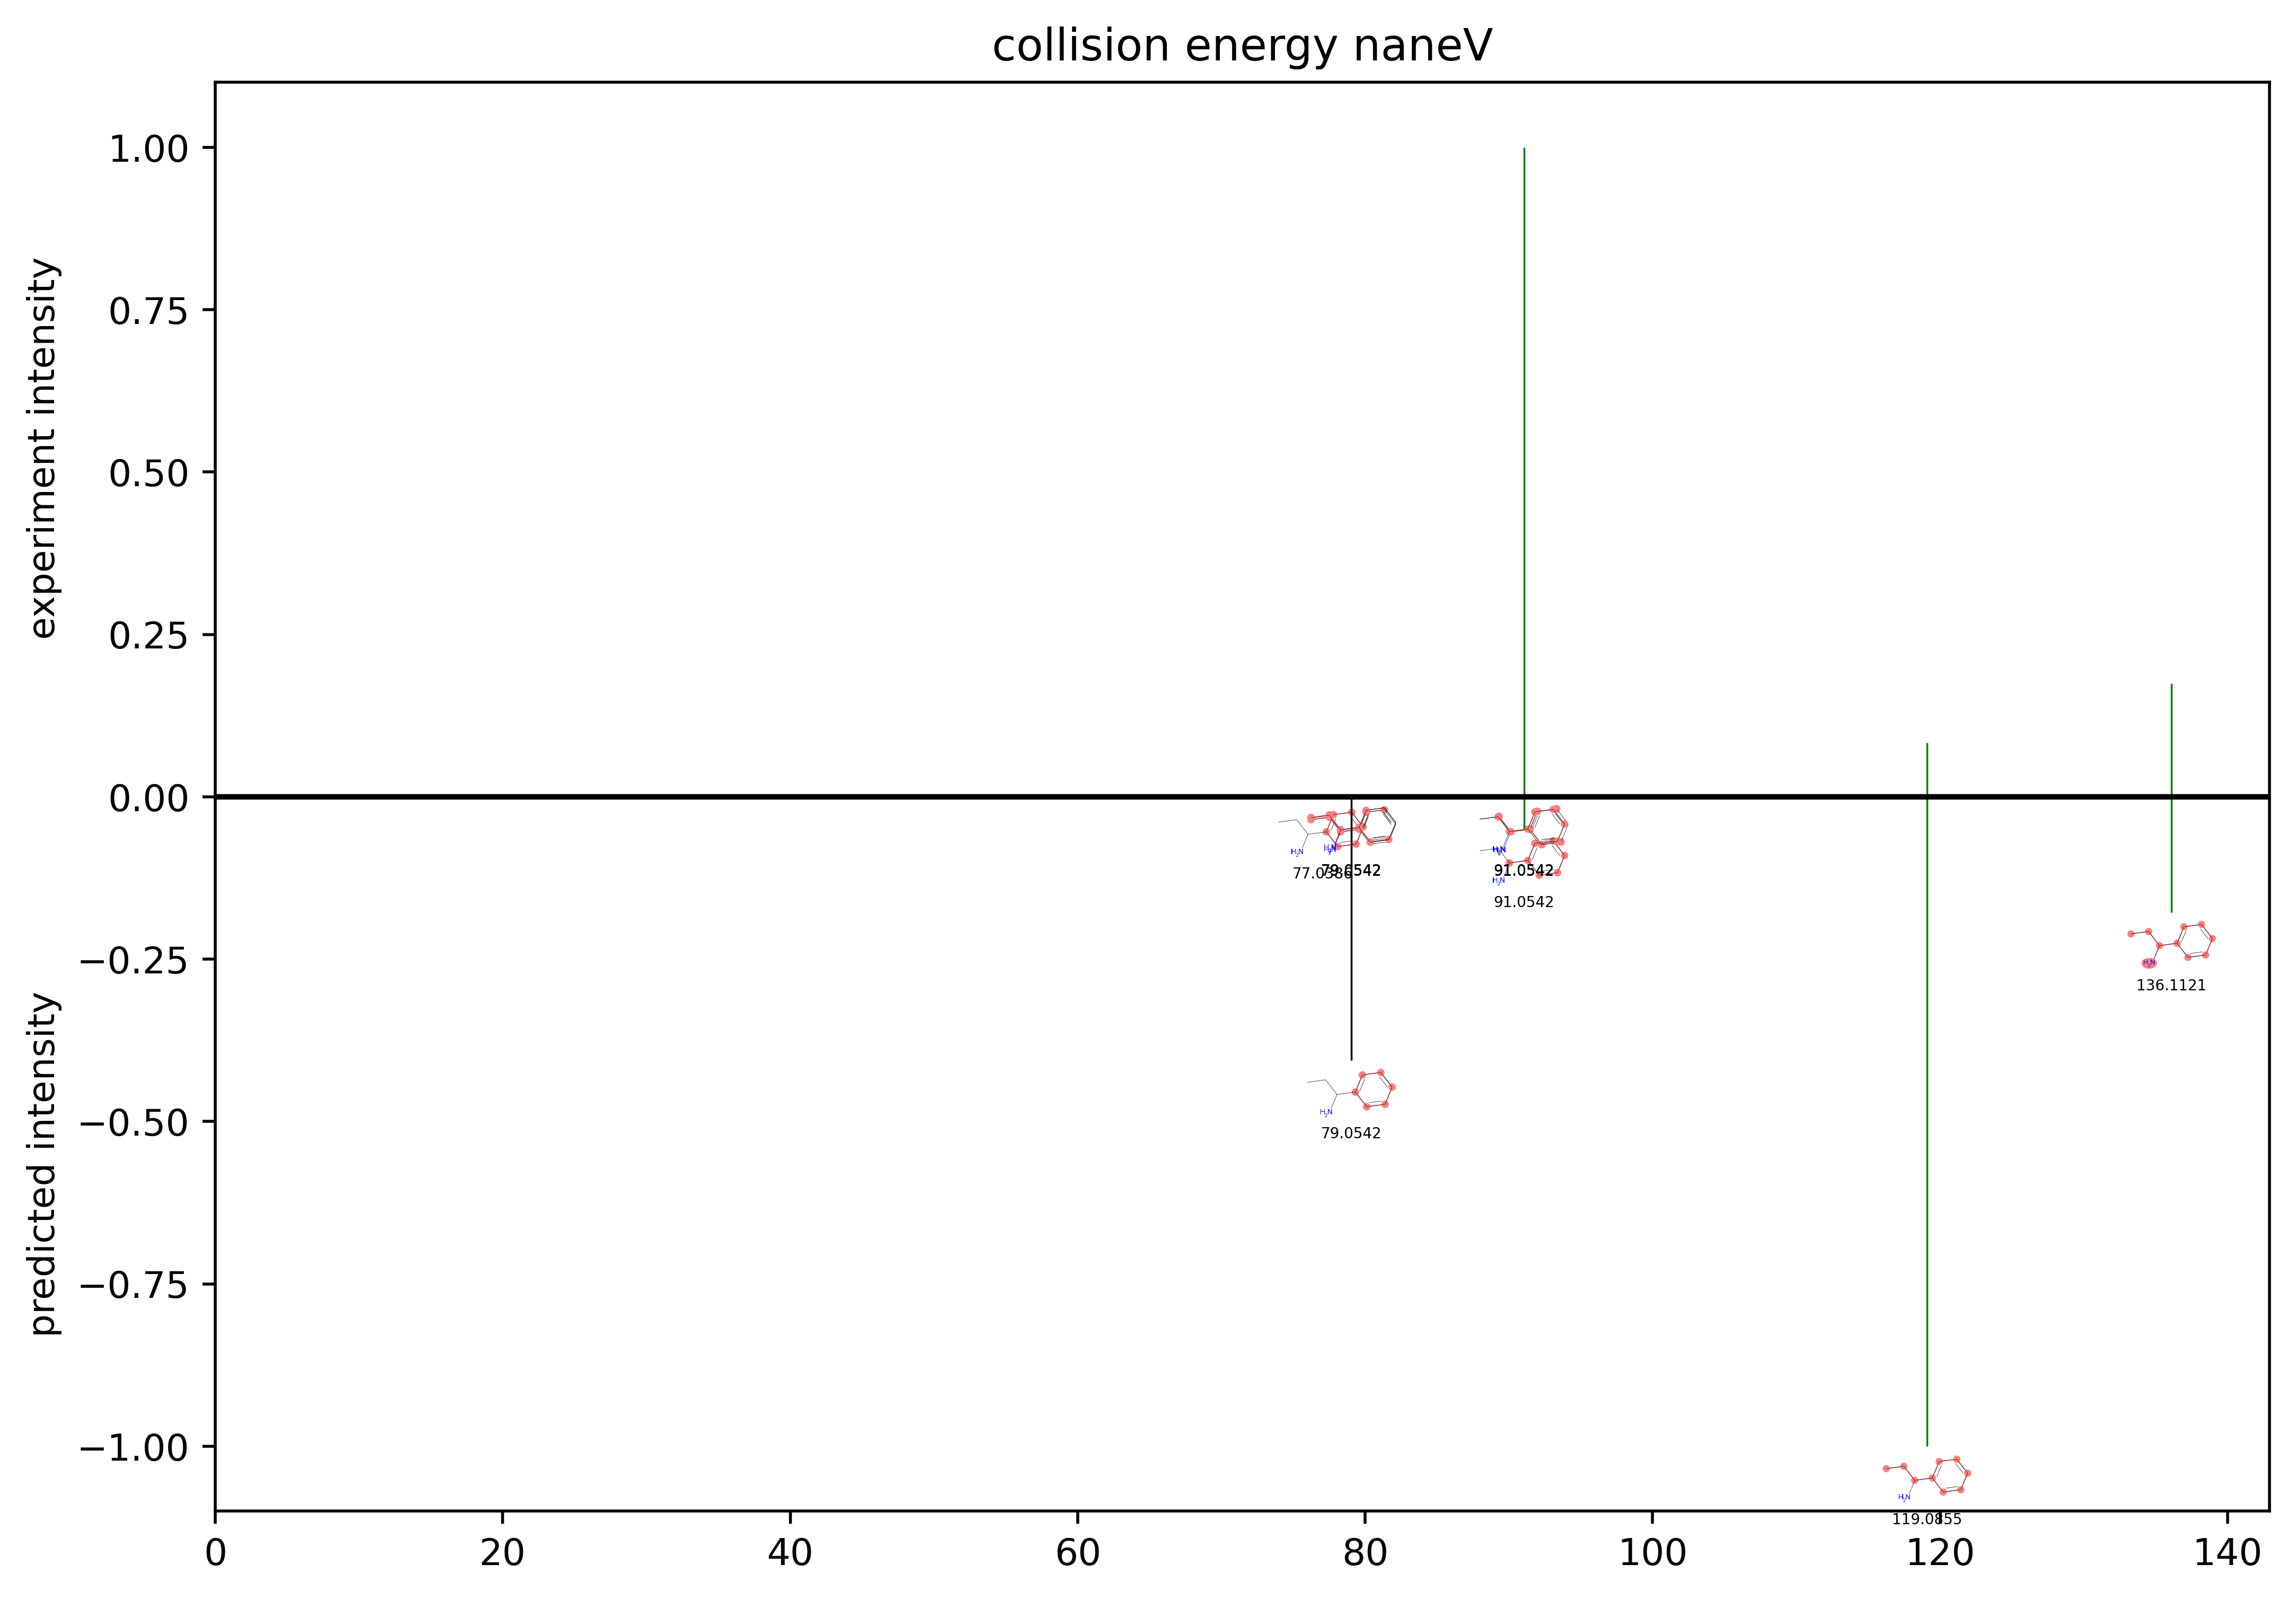

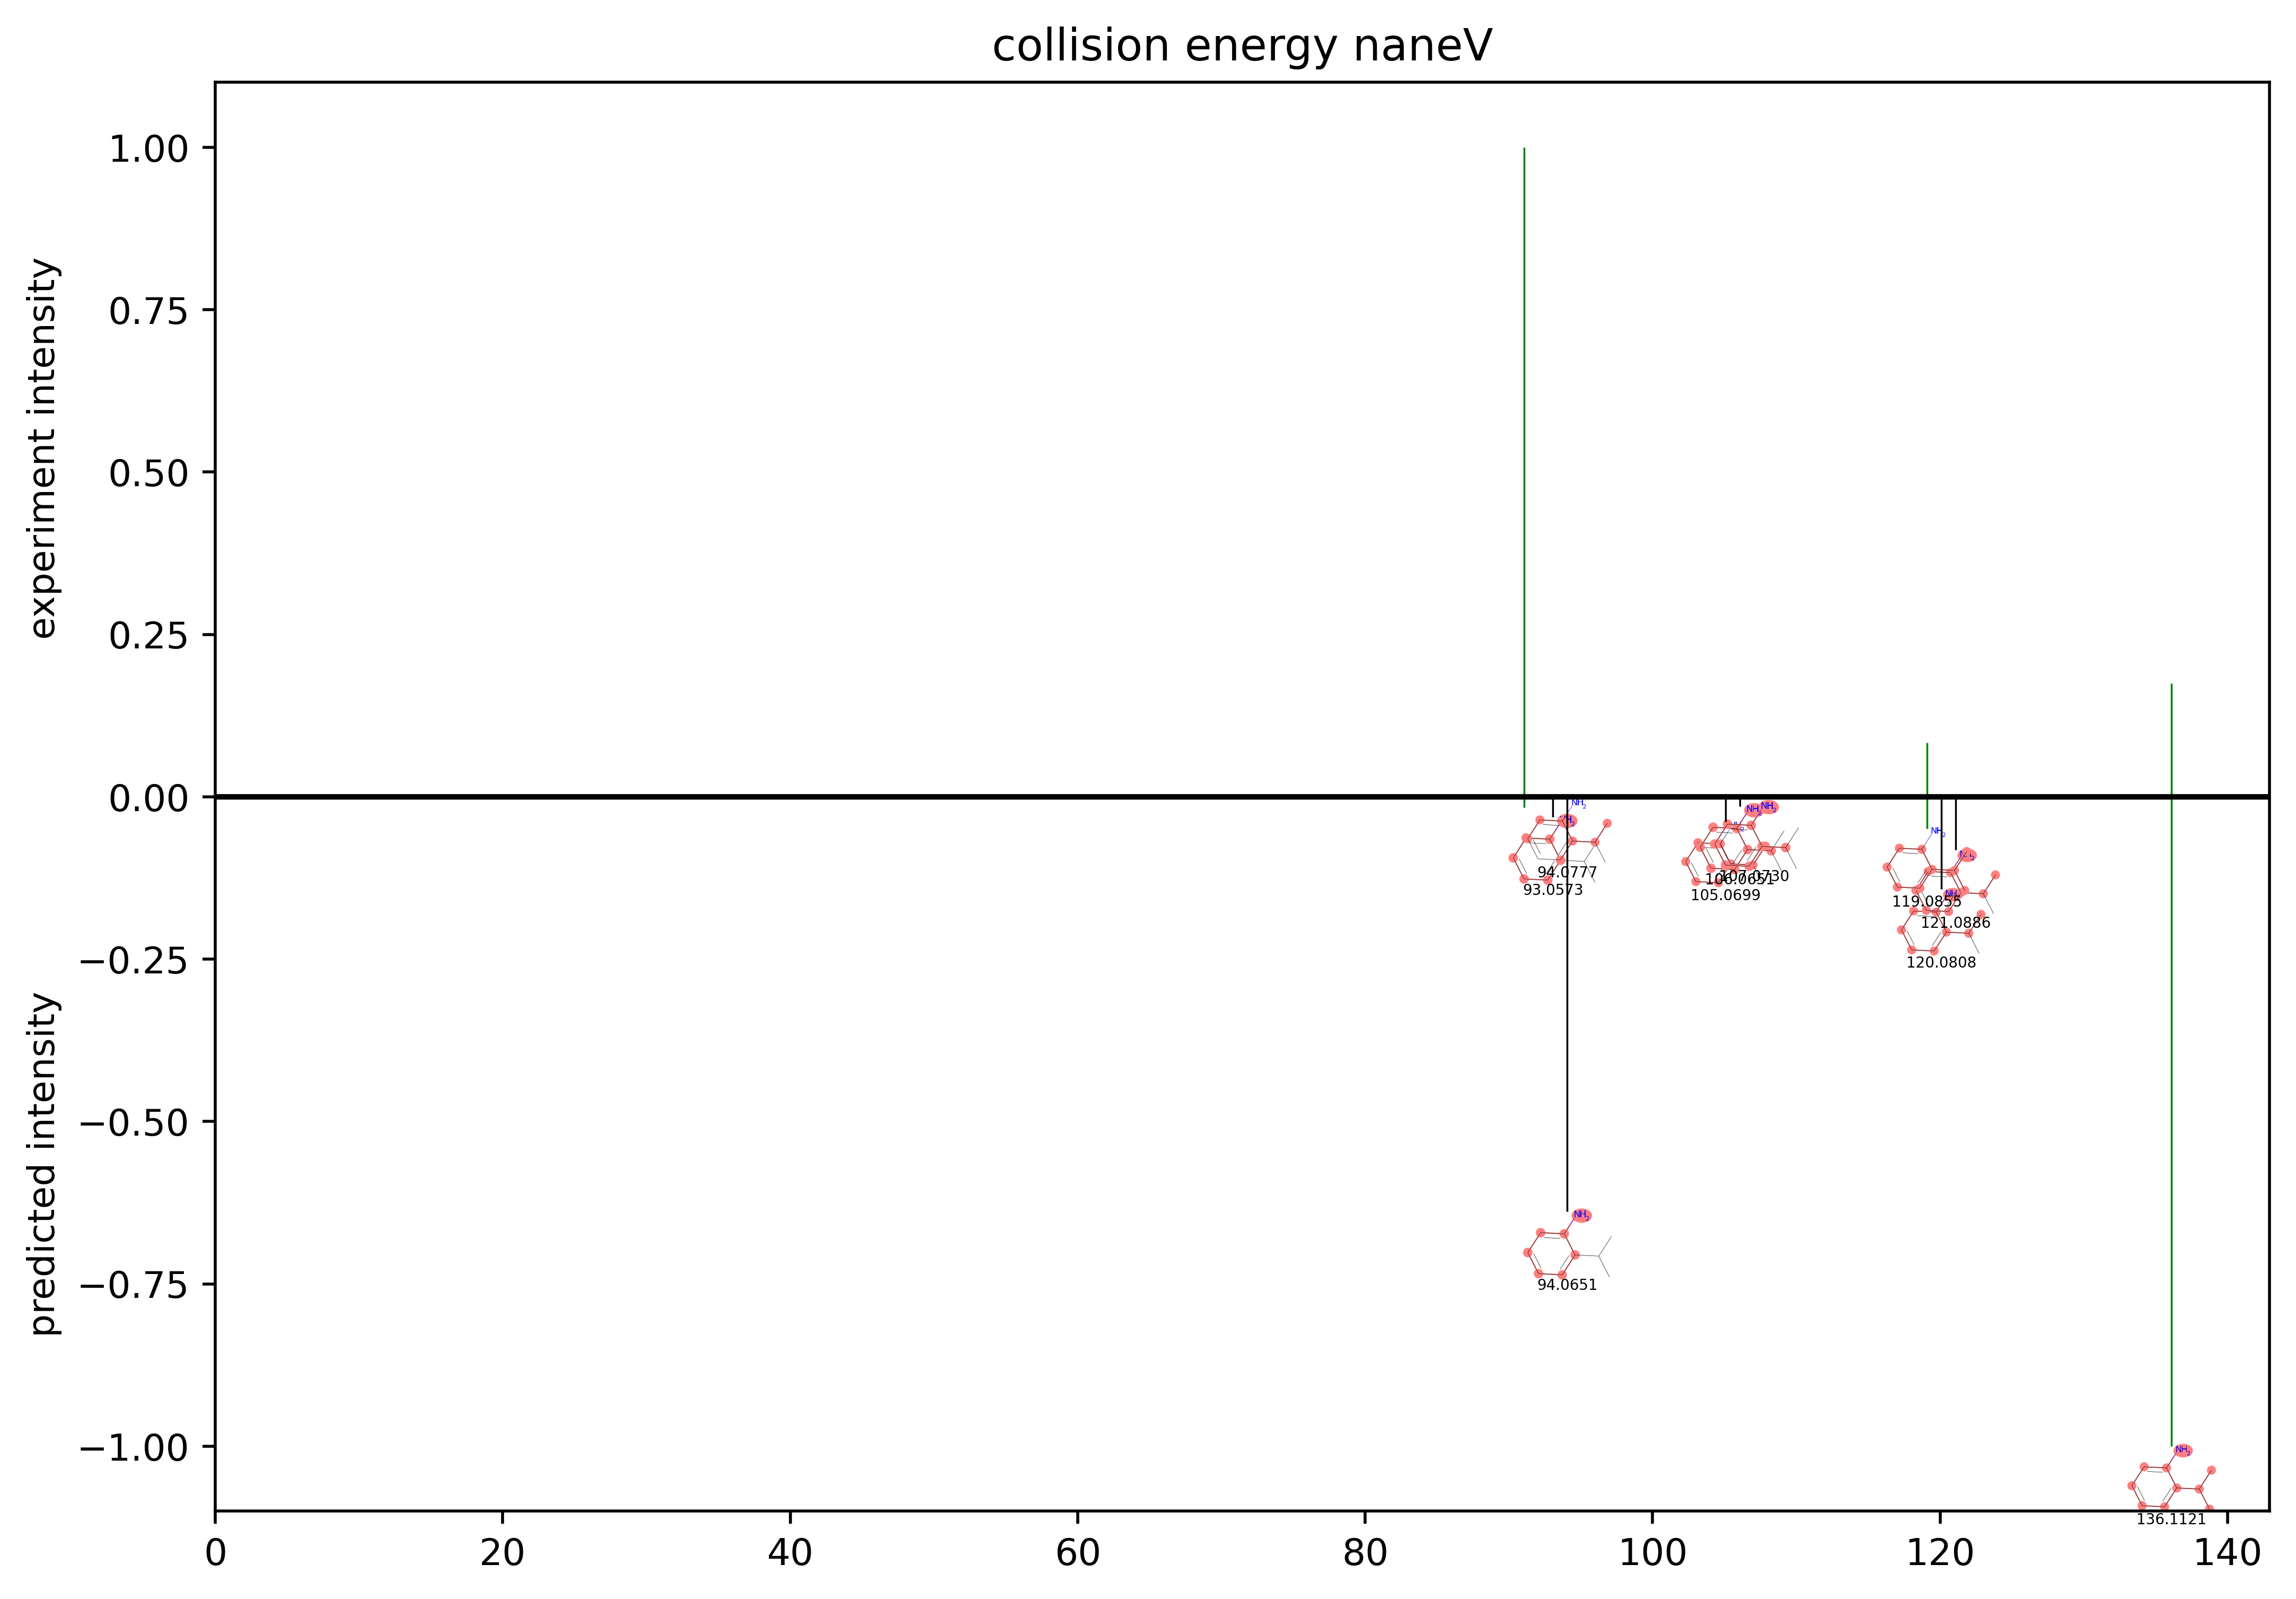

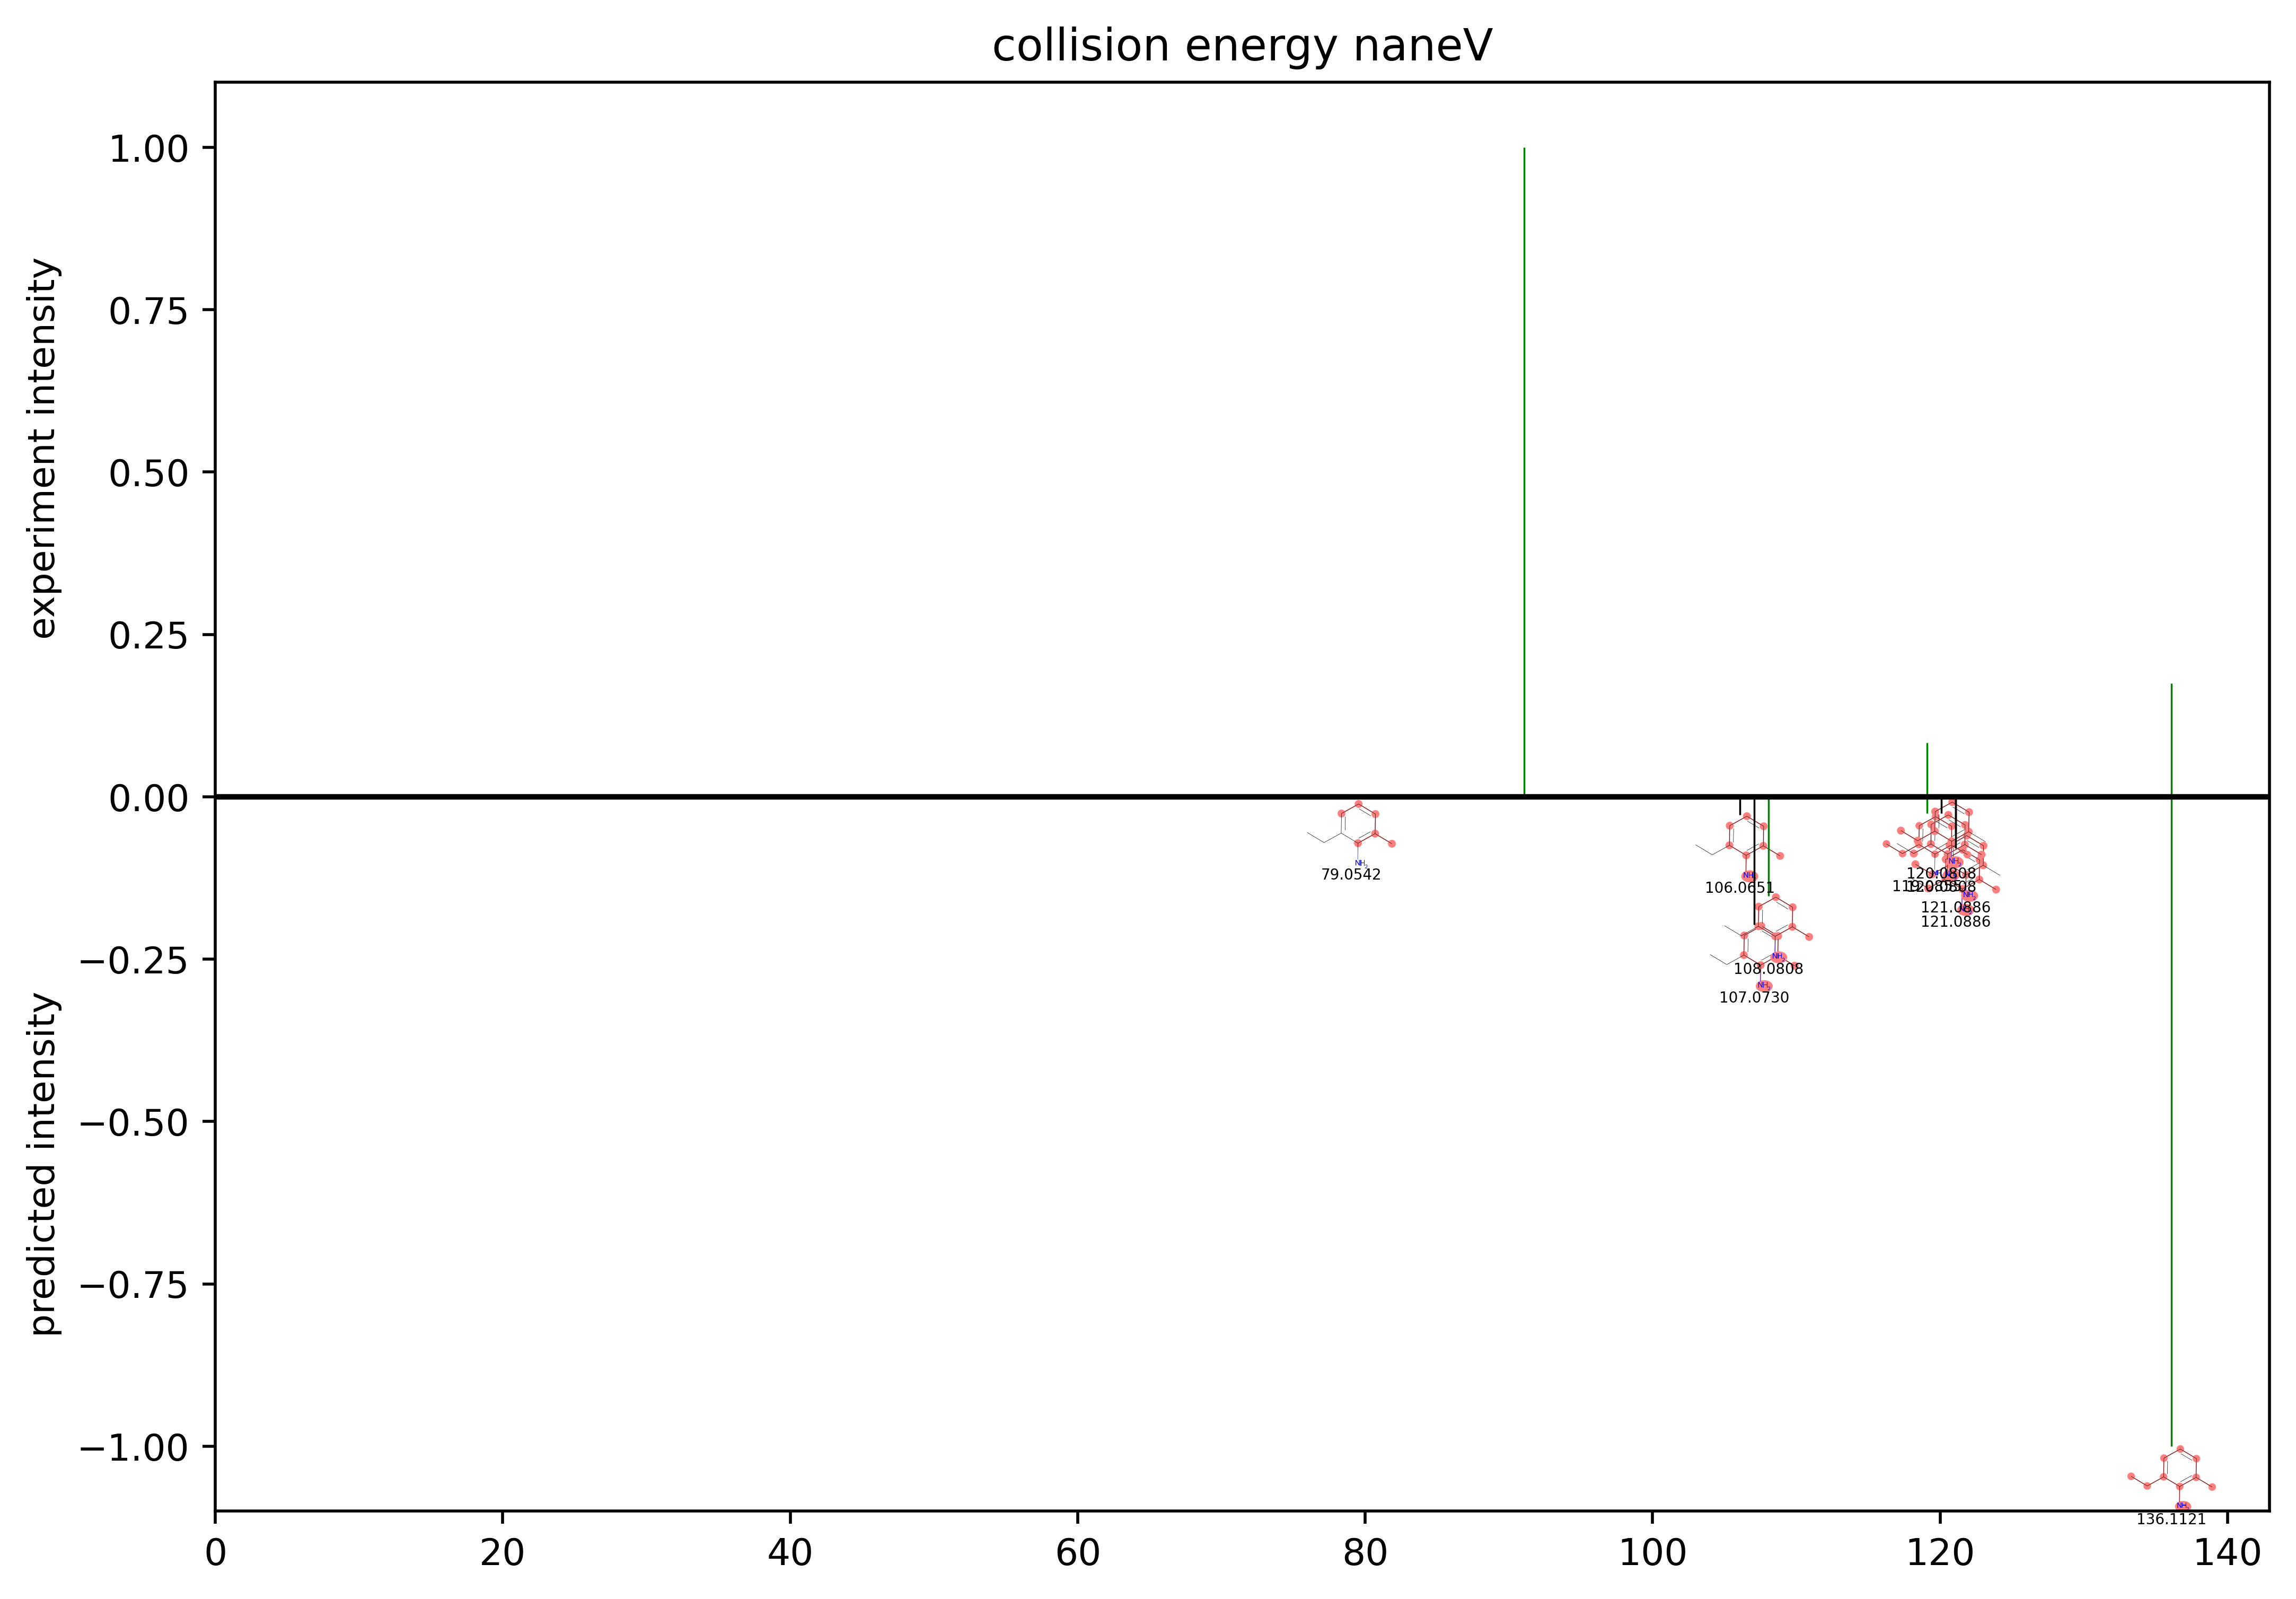

In [41]:
feature_id = '381'
spec = {'nan': feat_id_to_specs[feature_id]}
elucidation(feature_id, spec, '[M+H]+', all_smiles, vis_peaks=True, energy=[20, 40, 60])

In [37]:
# Run sirius
feature_id_to_form = form_from_mgf(inp_mgf, **config)

feat_id_to_dict = {}
for feature_id, all_info in tqdm(feature_id_to_form.items()):
    adduct_to_smiles = {}
    for info in all_info:
        for cand_form, cand_smi in zip(all_forms, all_smiles):
            diff = common.formula_difference(info['form'], cand_form)
            if len(diff) == 0:  # same formula
                if info['adduct'] in adduct_to_smiles:
                    adduct_to_smiles[info['adduct']].append(cand_smi)
                else:
                    adduct_to_smiles[info['adduct']] = [cand_smi]
    if len(adduct_to_smiles) > 0:
        # remove duplicate inchikey
        for adduct, smiles in adduct_to_smiles.items():
            inchikeys = [common.inchikey_from_smiles(smi) for smi in smiles]
            _, uniq_idx = np.unique(inchikeys, return_index=True)
            adduct_to_smiles[adduct] = np.array(smiles)[uniq_idx].tolist()

        feat_id_to_dict[feature_id] = {
            'feature_id': feature_id,
            'spec': {'nan': feat_id_to_specs[feature_id]},
            'adduct_to_smiles': adduct_to_smiles,
        }

100%|██████████| 33/33 [00:00<00:00, 6591.68it/s]


In [38]:
feat_id_to_dict

{'480': {'feature_id': '480',
  'spec': {'nan': array([[5.10232700e+01, 7.40000000e-02],
          [5.30024300e+01, 1.04000000e-01],
          [5.30388220e+01, 2.20000000e-01],
          [6.50385660e+01, 4.75000000e-01],
          [7.69330370e+01, 2.67000000e-01],
          [7.70387030e+01, 1.21000000e-01],
          [7.80466130e+01, 6.20000000e-02],
          [7.90541310e+01, 5.10000000e-01],
          [7.90802400e+01, 4.60000000e-02],
          [9.10542690e+01, 2.82760000e+01],
          [9.10572390e+01, 9.60000000e-02],
          [9.19550550e+01, 5.40000000e-02],
          [9.30572950e+01, 1.05600000e+00],
          [9.30699200e+01, 5.53000000e-01],
          [9.40650890e+01, 7.82300000e+00],
          [9.49433560e+01, 6.50000000e-02],
          [9.50491270e+01, 3.71000000e-01],
          [1.03054181e+02, 1.70900000e+00],
          [1.04062128e+02, 1.00000000e-01],
          [1.05044981e+02, 5.80000000e-02],
          [1.06065121e+02, 6.36500000e+00],
          [1.09196534e+02, 6.20